In [1]:
import ast
import time
import math
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, sqrt
from numpy import arccos, arctan2
from qiskit.visualization.bloch import Bloch
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector
from qiskit.circuit.library import RYGate, XGate
from qiskit_aer import Aer

In [2]:
from tensorflow.keras.datasets import cifar10

# CIFAR-10 데이터셋 로드
(x_train, y_train), (_, _) = cifar10.load_data()

# 각 클래스별 이미지를 저장할 딕셔너리 생성
class_images = {i: [] for i in range(10)}

# 각 클래스별 100장씩 저장
for img, label in zip(x_train, y_train):
    label = label[0]
    if len(class_images[label]) < 100:
        class_images[label].append(img)
    if all(len(images) == 100 for images in class_images.values()):
        break

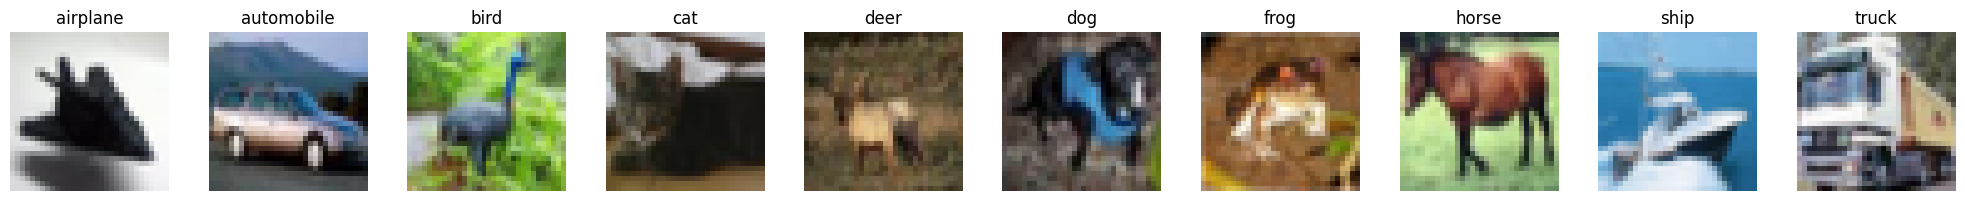

In [3]:
# CIFAR-10 클래스명 목록
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 시각화
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(class_images[i][0])
    axes[i].set_title(classes[i])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [4]:
from itertools import product

def fill_missing_pixel_theta(pixel_theta, num_bits=10):
    """
    pixel_theta 리스트에서 누락된 (state, index) 쌍을 value=0으로 채워주는 함수
    
    Args:
        pixel_theta (list of tuple): [(state:str, index:str, value:int/float), ...]
        num_bits (int): index의 비트 길이 (기본값 10 → '0000000000' ~ '1111111111')
    
    Returns:
        list of tuple: 모든 (state, index, value)를 포함한 리스트 (길이 = 2 * 2^num_bits)
    """
    # 현재 데이터 딕셔너리화
    data_dict = {(state, idx): val for state, idx, val in pixel_theta}
    
    # 가능한 모든 state-index 조합 생성
    states = ['0', '1']
    indices = [format(i, f'0{num_bits}b') for i in range(2**num_bits)]
    
    # 누락된 조합은 value=0으로 채우기
    full_pixel_theta = []
    for s, idx in product(states, indices):
        val = data_dict.get((s, idx), 0)
        full_pixel_theta.append((s, idx, val))
    
    return full_pixel_theta


def sort_by_theta_bin(filled_pixel_theta):
    return sorted(filled_pixel_theta, key=lambda x: int(x[1], 2))

In [5]:
def approximate_rgb(arr_theta, arr_phi, lut_df):
    global mismatches
    theta_lower = lut_df["theta_lower"].values
    theta_upper = lut_df["theta_upper"].values
    phi_left    = lut_df["phi_left"].values
    phi_right   = lut_df["phi_right"].values
    r = lut_df["r"].values
    g = lut_df["g"].values
    b = lut_df["b"].values

    N = arr_theta.shape[0]
    approx_rgb = np.zeros((N, 3), dtype=np.uint8)

    # 미매칭 기록용 리스트
    mismatches = []

    for idx in range(N):
        theta = arr_theta[idx]
        phi = arr_phi[idx]

        # θ 매칭 (벡터 조건)
        cond_theta = (theta_lower <= theta) & (theta <= theta_upper)
        # ϕ 매칭 (wrap-around 고려)
        cond_phi = np.where(
            phi_left <= phi_right,
            (phi_left <= phi) & (phi <= phi_right),
            (phi_left <= phi) | (phi <= phi_right)
        )
        cond = cond_theta & cond_phi
        match_idxs = np.where(cond)[0]
        if len(match_idxs) > 0:
            match = match_idxs[0]
            approx_rgb[idx, 0] = r[match]
            approx_rgb[idx, 1] = g[match]
            approx_rgb[idx, 2] = b[match]
        else:
            approx_rgb[idx, :] = 0  # 미매칭
            mismatches.append((idx, theta, phi))

    # 미매칭 결과 출력
    if mismatches:
        print("❌ 미매칭된 theta, phi:")
        for m in mismatches:
            print(f"Index {m[0]}: theta={m[1]}, phi={m[2]}")

    return approx_rgb

In [6]:
def quantize_image_4(img):
    # 4단위로 값을 내림 (0, 4, 8, ..., 252)
    return (img // 4) * 4

def visualize_quantized_one_per_class(class_images):
    fig, axes = plt.subplots(1, 10, figsize=(20, 3))
    classes = [str(i) for i in range(10)]

    for i in range(10):
        # 각 클래스에서 첫 번째 이미지를 선택
        img = class_images[i][0]
        # 4단위로 양자화
        quant_img = quantize_image_4(img)
        axes[i].imshow(quant_img)
        axes[i].set_title(f'class {classes[i]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

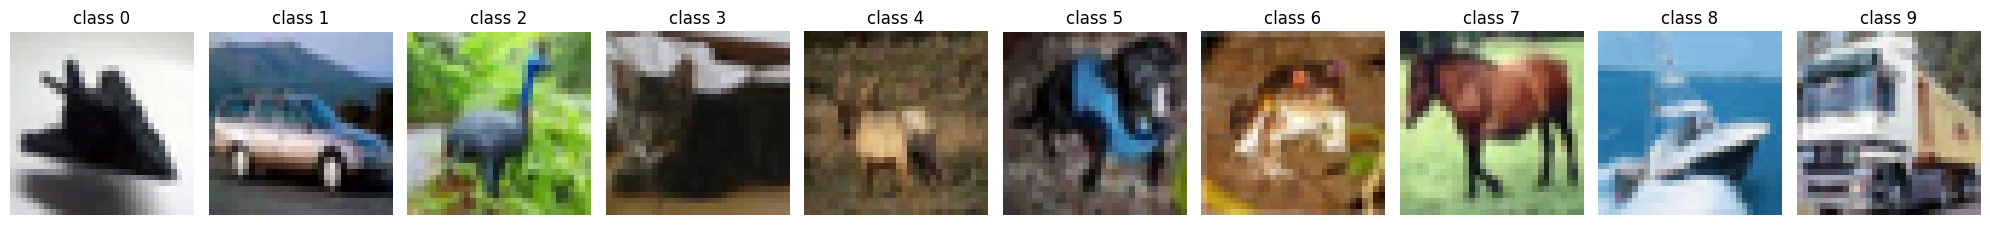

In [7]:
# 클래스별로 한 장씩 4단위 양자화 후 시각화 실행
visualize_quantized_one_per_class(class_images)

In [8]:
# 결과 저장할 딕셔너리 준비
quantized_class_images = {i: [] for i in range(10)}

# 클래스별로 100장씩 양자화
for class_id, images in class_images.items():
    for img in images:
        quant_img = quantize_image_4(img)
        quantized_class_images[class_id].append(quant_img)

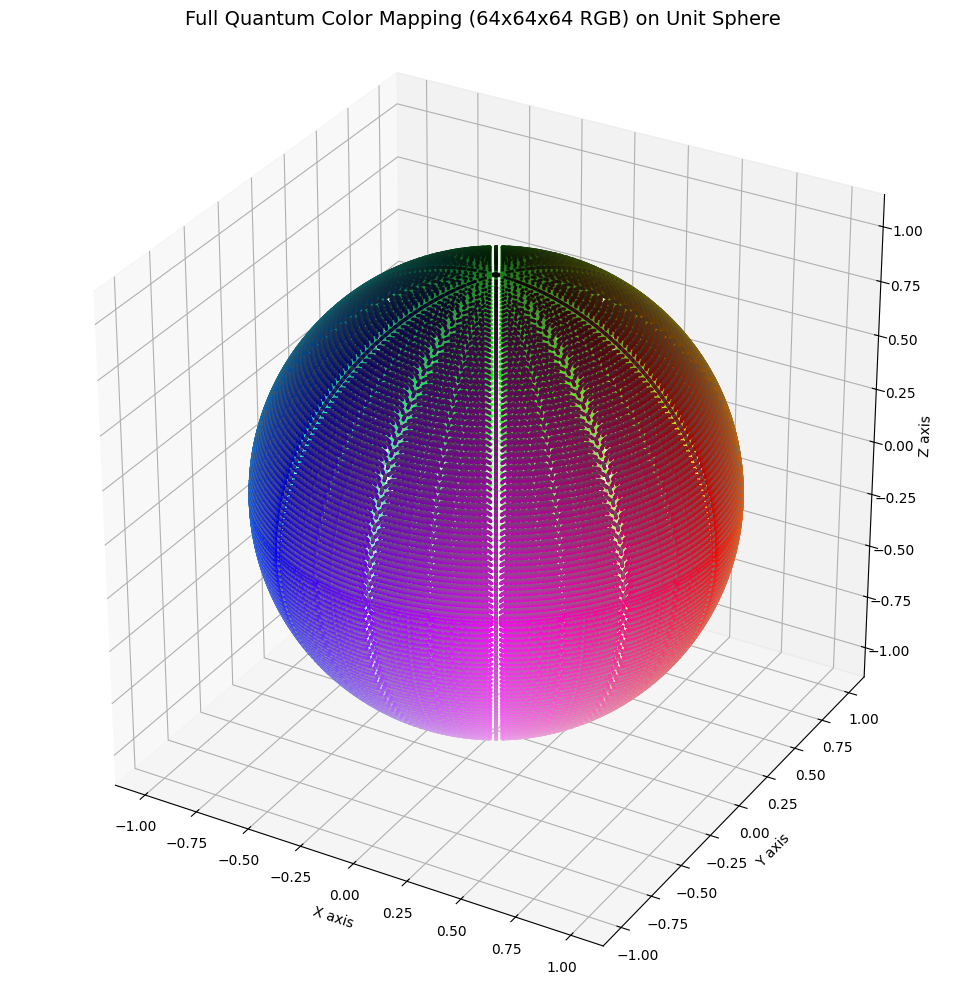

In [51]:
import numpy as np

PI = np.pi

def compute_theta_fix(r, g, b):
    # 정수 입력 전제(0..63)
    M = int(max(r, g, b))   # 최대
    m = int(min(r, g, b))   # 최소
    l = M + m               # 합

    # === 북반구: l = 63 - a, a=1..62 ===
    if l < 63:
        a = 63 - l
        # 문헌/설계: 북반구는 M = 63 - a - i, m = i,  i=1..floor((63-a)/2)
        max_i = (63 - a) // 2
        i = m  # m==i 로부터 직접
        if 0 <= i <= max_i and (M == 63 - a - i):
            # θ = ((63 - a)/126)π + (π/252) - ((π/126) * (i+1)/(max_i+1))
            return ((63 - a) * PI / 126.0) + (PI / 252.0) - ((PI / 126.0) * (i + 1) / (max_i + 1))

        # 경계치(루프 범위 밖) 보정: i==0 또는 i>max_i 같은 특수 케이스는
        # 해당 링의 중앙값으로 매핑(충돌 방지용)
        # 링 중앙: ((63 - a)/126)π + (π/252) - (π/252)/2  = ((63 - a)/126)π + (π/252)/2
        return ((63 - a) * PI / 126.0) + (PI / 252.0) - ((PI / 126.0) * (i + 1) / (max_i + 1))

    # === 적도: l = 63 ===
    elif l == 63:
        # 설계: M = 63 - i, m = i,  i=0..31 (정의된 지그재그)
        i = m
        if i == 0:
            return PI / 2.0
        max_i = 63 // 2  # 31
        if 1 <= i <= max_i:
            if i % 2 == 0:  # 2,4,...,30  (남쪽으로 약간)
                return PI / 2.0 + (PI / 252.0) * (i / 30.0)
            else:           # 1,3,...,31  (북쪽으로 약간)
                return PI / 2.0 - (PI / 252.0) * ((i + 1) / 32.0)

        # 안전망(충돌 방지): 링 중앙
        return PI / 2.0

    # === 남반구: l = 63 + a, a=1..62 ===
    else:
        a = l - 63
        # 문헌/설계: 남반구는 M = 63 - i, m = a + i,  i=1..floor((63-a)/2)
        max_i = (63 - a) // 2
        i = 63 - M  # M = 63 - i  →  i = 63 - M
        if 0 <= i <= max_i and (m == a + i):
            # θ = ((63 + a)/126)π - (π/252) + ((π/126) * (i+1)/(max_i+1))
            return ((63 + a) * PI / 126.0) - (PI / 252.0) + ((PI / 126.0) * (i + 1) / (max_i + 1))

        # 경계/비정상 조합은 링 중앙으로(여기가 남반구 대량 충돌을 막는 핵심)
        # 링 중앙: ((63 + a)/126)π - (π/252) + (π/252)/2  = ((63 + a)/126)π - (π/504)
        return ((63 + a) * PI / 126.0) - (PI / 252.0) + ((PI / 126.0) * (i + 1) / (max_i + 1))
    
    # RGB → θ, ϕ 변환
def rgb_to_theta_phi_fix(r, g, b):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n
    i = (r + g + b) - n - m

    theta = compute_theta_fix(r, g, b)

    if m == n:
        phi = 0
    else:
        if r == m and b == n:
            k = i - b
            phi = (np.pi / 3) * k / (m - n)
        elif g == m and b == n:
            k = g - i
            phi = (np.pi / 3) * k / (m - n) + (np.pi / 3)
        elif g == m and r == n:
            k = i - r
            phi = (np.pi / 3) * k / (m - n) + (2 * np.pi / 3)
        elif b == m and r == n:
            k = b - i
            phi = (np.pi / 3) * k / (m - n) + (3 * np.pi / 3)
        elif b == m and g == n:
            k = i - g
            phi = (np.pi / 3) * k / (m - n) + (4 * np.pi / 3)
        elif r == m and g == n:
            k = r - i
            phi = (np.pi / 3) * k / (m - n) + (5 * np.pi / 3)
        else:
            phi = 0
    return theta, phi

# θ, ϕ → (x, y, z)
def theta_phi_to_xyz(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

# 전체 RGB 매핑
def map_full_rgb_fix():
    global coords, colors, polar_coords
    coords = []
    colors = []
    polar_coords = []
    rep_values = [0] + [i for i in range(4, 252, 4)] + [252]  # 64개의 값

    for r in rep_values:
        for g in rep_values:
            for b in rep_values:
                # 양자화된 값 → 0~63 범위로 mapping (compute_theta가 기대하는 입력)
                r63, g63, b63 = r // 4, g // 4, b // 4

                theta, phi = rgb_to_theta_phi_fix(r63, g63, b63)
                x, y, z = theta_phi_to_xyz(theta, phi)
                polar_coords.append((theta,phi))
                coords.append((x, y, z))
                colors.append((r / 255, g / 255, b / 255))  # for visual RGB color

    return np.array(coords), np.array(colors)

# 3D 시각화
def plot_full_quantum_color_sphere_fix():
    coords, colors = map_full_rgb_fix()
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=colors, s=2)
    ax.set_title('Full Quantum Color Mapping (64x64x64 RGB) on Unit Sphere', fontsize=14)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()
    return len(colors)

# 실행
total_colors = plot_full_quantum_color_sphere_fix()

In [59]:
# 예시 coords (theta, phi)와 color
# coords: N x 2 배열 (theta, phi), colors: N x 3 배열 (r,g,b)
# coords, colors는 이미 있다고 가정

# (1) theta, phi를 정렬된 배열로 가정
# 여기서는 예시용 placeholder (실제 실행 시 coords와 colors 대체 필요)
# coords = np.array([[...], [...], ...])
# colors = np.array([[...], [...], ...])

# (2) theta/phi 좌표 기준 정렬

polar_coords = np.array(polar_coords)  # 리스트 → NumPy 배열
colors = np.array(colors)
coords_sorted = polar_coords[np.lexsort((polar_coords[:, 1], polar_coords[:, 0]))]  # sort by theta then phi
theta_vals = np.unique(coords_sorted[:, 0])
phi_vals = np.unique(coords_sorted[:, 1])

# (3) 각 좌표를 (i,j) 그리드 인덱스로 변환
theta_to_idx = {val: idx for idx, val in enumerate(theta_vals)}
phi_to_idx = {val: idx for idx, val in enumerate(phi_vals)}

# (4) 각 좌표마다 theta_upper/lower, phi_left/right 계산
rows = []
for i in range(polar_coords.shape[0]):
    theta, phi = polar_coords[i]
    r, g, b = colors[i]

    ti = theta_to_idx[theta]
    pi = phi_to_idx[phi]

    rows.append({
        'r': int(r * 255),
        'g': int(g * 255),
        'b': int(b * 255),
        'theta': theta,
        'phi': phi
    })

# (5) DataFrame 저장
df = pd.DataFrame(rows)
df.to_csv("64/64_RGB_coords_renew.csv", index=False)
paths = "64/64_RGB_coords_renew.csv"

In [60]:
def RoP_64_exact(r, g, b, theta, phi, *, is_last=False, eps=1e-6):
    """
    Region of Point in S² for 64-scaled RGB space
    (faithful to Appendix 7.3, equations (20)–(22))
    """

    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n
    pi = np.pi
    epsilon = 0.0  # strictly follow equations

    theta_lower = theta_upper = phi_left = phi_right = 0.0

    # Case 1: north pole (m = n = 0)
    if m == n == 0:
        theta_lower = 0
        theta_upper = pi/504
        phi_left = 0
        phi_right = 2*pi - epsilon

    # Case 2: Mx+Mn = 1  → (m=1,n=0)
    elif m == 1 and n == 0:
        theta_lower = pi/504
        theta_upper = pi/126
        phi_left = phi - pi/6
        phi_right = phi + pi/6 - epsilon

    # Case 3: Mx+Mn = 63 - α,  α=1…61  (Eq. 20)
    elif 1 < l < 63:
        a = 63 - l
        max_i = int(np.floor((63 - a) / 2))

        if m == n:
            if n == max_i:
                theta_lower = theta - pi/252/(int(np.floor((63 - a - 1)/2)) + 1)
                theta_upper = theta + pi/252/(max_i + 1)
            else:
                theta_lower = theta - pi/252/(max_i+ 1)
                theta_upper = theta + pi/252/(max_i + 1)
            phi_left = 0
            phi_right = 2*pi - epsilon

        elif 0 <= n <= max_i:
            theta_lower = theta - pi/252/(max_i + 1)
            theta_upper = theta + pi/252/(max_i + 1) - epsilon
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

    # Case 4: Mx+Mn = 63  (Eq. 21)
    elif l == 63:
        # Mn = 2k−1 (k=1…16)
        if n % 2 == 1 and n < 32:
            theta_lower = theta - pi/252/32
            theta_upper = theta + pi/252/32
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

        # Mn = 0
        elif n == 0:
            theta_lower = pi/2 - pi/252/32
            theta_upper = pi/2 + pi/252/30
            phi_left = phi - pi/6/63
            phi_right = phi + pi/6/63 - epsilon

        # Mn = 2k (k=1…14)
        elif n % 2 == 0 and n < 30:
            theta_lower = theta - pi/252/30
            theta_upper = theta + pi/252/30
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

        # Mn = 30
        elif n == 30:
            theta_lower = theta - pi/252/30
            theta_upper = theta + pi/252/32
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

    # Case 5: Mx+Mn = 63 + α, α=1…61 (Eq. 22)
    elif 63 < l < 125:
        a = l - 63
        max_i = int(np.floor((63 - a) / 2))

        # (m == n) case (gray axis on southern hemisphere)
        if m == n:
            # Eq. (22) symmetric definition: full phi range
            if n == a + max_i:  # i = ⌊(63−α)/2⌋
                theta_lower = theta - pi/252/(max_i + 1)
                theta_upper = theta + pi/252/(int(np.floor((63 - a - 1)/2)) + 1)
            else:  # 0 ≤ i < ⌊(63−α)/2⌋
                theta_lower = theta - pi/252/(max_i + 1)
                theta_upper = theta + pi/252/(max_i + 1)
            phi_left = 0
            phi_right = 2 * pi - epsilon

        # (a) Mn = α+i, 1 ≤ i < ⌊(63−α)/2⌋
        elif 0 <= n - a <= max_i:
            theta_lower = theta - pi/252/(max_i + 1)
            theta_upper = theta + pi/252/(max_i + 1)
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

        # (b) Mn = α+i, i = ⌊(63−α)/2⌋
        elif n == a + max_i:
            theta_lower = theta - pi/252/(max_i + 1)
            theta_upper = theta + pi/252/(int(np.floor((63 - a - 1)/2)) + 1)
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

    # Case 6: (Mx,Mn) = (63,62)
    elif m == 63 and n == 62:
        theta_lower = 125*pi/126
        theta_upper = 503*pi/504
        phi_left = phi - pi/6
        phi_right = phi + pi/6 - epsilon

    # Case 7: south pole (m = n = 63)
    elif m == n == 63:
        theta_lower = 503*pi/504
        theta_upper = pi
        phi_left = 0
        phi_right = 2*pi - epsilon

    # 마지막 행에 eps 보정
    if is_last:
        theta_upper += eps

    return theta_lower, theta_upper, phi_left, phi_right

In [61]:
n_rows = len(df)

bounds = df.apply(
    lambda row: RoP_64_exact(
        int(row['r']) // 4, int(row['g']) // 4, int(row['b']) // 4,
        row['theta'], row['phi'],
        is_last=(row.name == n_rows - 1),  # 마지막 행에만 eps 적용
        eps=1e-6
    ),
    axis=1, result_type='expand'
)
bounds.columns = ['theta_lower', 'theta_upper', 'phi_left', 'phi_right']

df = pd.concat([df, bounds], axis=1)
df.to_csv("64/64_RGB_coords_renew_with_bounds.csv", index=False)

Coverage: 98.501% | Overlap cells: 21 (0.032%) | Gaps: 977 (1.499%)


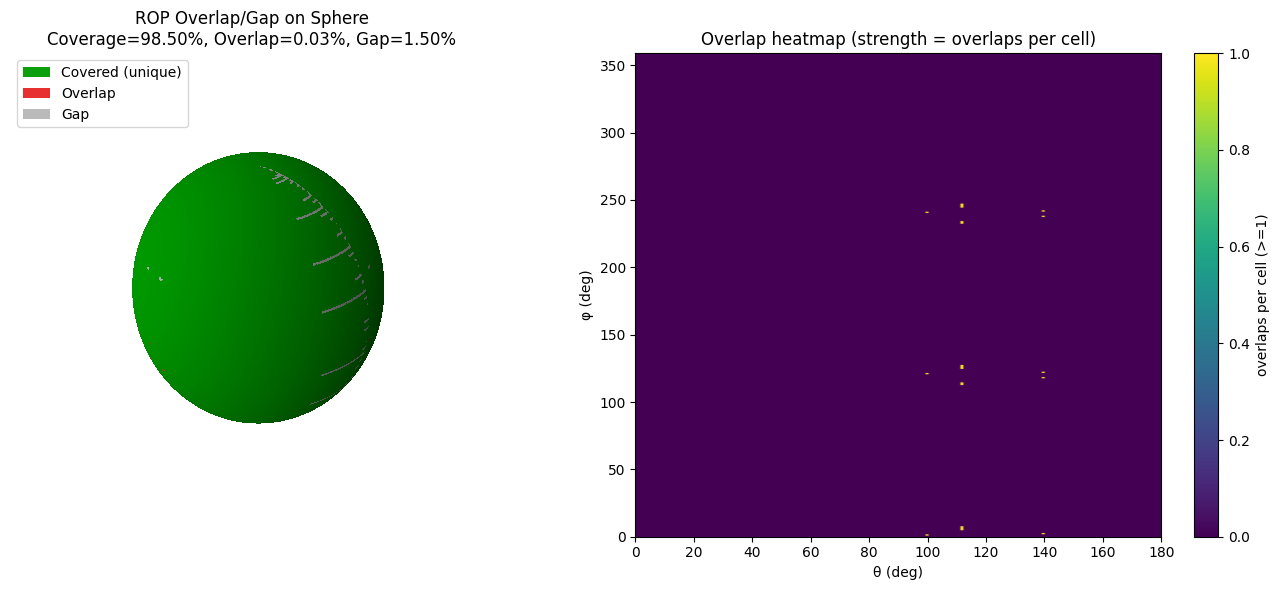

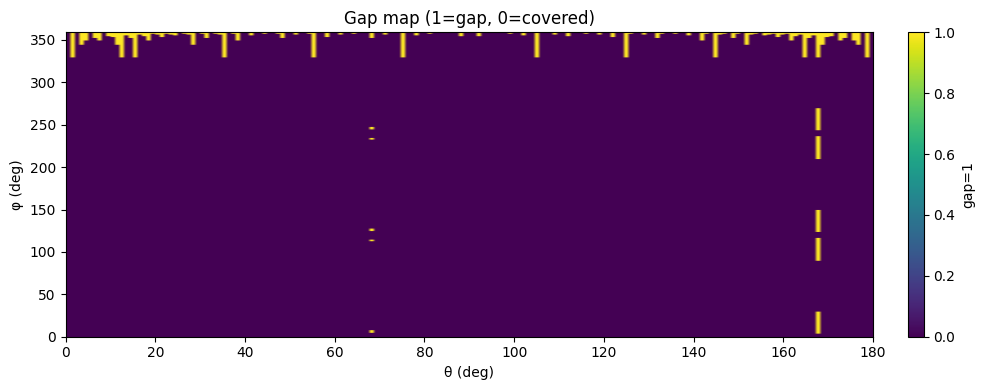

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================
# 설정
# =========================
CSV_PATH = r"64/64_RGB_coords_renew_with_bounds.csv"
PHI_DEG_STEP   = 1.0
THETA_DEG_STEP = 1.0
TOL = 1e-9

PI, TWOPI = np.pi, 2*np.pi
deg = np.deg2rad
rad = np.rad2deg

# =========================
# 유틸 함수
# =========================
def ang_norm(x):
    return (x % TWOPI + TWOPI) % TWOPI

def phi_in_interval(phi, L, R, tol=TOL):
    """φ ∈ [L,R) 처리 (래핑 대응)"""
    a = ang_norm(phi); L = ang_norm(L); R = ang_norm(R)
    if L <= R:
        return (a + tol >= L) and (a < R - tol)
    else:  # wrap-around
        return (a + tol >= L) or (a < R - tol)

def theta_mask(theta_vals, lower, upper, hemisphere, m, n):
    """
    각 RGB의 반구, m,n 조건에 따라 θ 개구/폐구간 생성
    """
    if hemisphere == "north":
        if m == 0 and n == 0:
            return (theta_vals >= lower - TOL) & (theta_vals < upper - TOL)
        else:
            return (theta_vals >= lower - TOL) & (theta_vals < upper - TOL)
    elif hemisphere == "equator":
        # m + n == 63
        if n == 0:
            return (theta_vals >= lower - TOL) & (theta_vals <= upper + TOL)
        elif n % 2 == 1:
            return (theta_vals >= lower - TOL) & (theta_vals < upper - TOL)
        elif n % 2 == 0:
            return (theta_vals > lower + TOL) & (theta_vals <= upper + TOL)
        elif m == 30:
            return (theta_vals > lower + TOL) & (theta_vals <= upper + TOL)
        else:
            return (theta_vals >= lower - TOL) & (theta_vals < upper - TOL)
    elif hemisphere == "south":
        # 기본적으로 (] × [)
        return (theta_vals > lower + TOL) & (theta_vals <= upper + TOL)
    else:
        raise ValueError("hemisphere must be north/equator/south")

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH)
need = ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']
for c in need:
    if c not in df.columns:
        raise ValueError(f"필수 컬럼 누락: {c}")
for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)
for c in ['r','g','b']:
    df[c] = df[c].astype(int)

# hemispheres 정의
def get_hemisphere(l, m, n):
    if l < 63:
        return "north"
    elif l + n == 63:
        return "equator"
    else:
        return "south"

# RGB에서 (l,m,n) 생성
rgb_vals = df[['r','g','b']].values.astype(int)
l_vals = np.min(rgb_vals, axis=1)
M_vals = np.max(rgb_vals, axis=1)
m_vals = np.median(rgb_vals, axis=1).astype(int)
df['l'] = l_vals
df['m'] = m_vals
df['n'] = 63 - (l_vals + m_vals - np.min([l_vals,m_vals],axis=0))  # 임시 값, 실제 구조에 맞게 조정 필요
df['hemisphere'] = [get_hemisphere(l, m, n) for l,m,n in zip(df['l'],df['m'],df['n'])]

# =========================
# 격자 구성
# =========================
phi_deg_vals   = np.arange(0.0, 360.0, PHI_DEG_STEP)
theta_deg_vals = np.arange(0.0, 181.0, THETA_DEG_STEP)
phi_vals   = deg(phi_deg_vals)
theta_vals = deg(theta_deg_vals)
H, W = len(phi_vals), len(theta_vals)

cover_count = np.zeros((H, W), dtype=np.int16)
first_rgb   = np.full((H, W, 3), -1, dtype=np.int16)
conf_list, gap_list = [], []

# =========================
# ROP 래스터라이즈
# =========================
for idx, row in df.iterrows():
    L, R = row['phi_left'], row['phi_right']
    t0, t1 = row['theta_lower'], row['theta_upper']
    r,g,b = row['r'], row['g'], row['b']
    l,m,n = row['l'], row['m'], row['n']
    hemi = row['hemisphere']

    th_mask = theta_mask(theta_vals, t0, t1, hemi, m, n)
    th_idx = np.where(th_mask)[0]
    if th_idx.size == 0:
        continue

    # φ는 항상 [ ) 적용
    if L <= R:
        phi_idx = np.where((phi_vals >= L - TOL) & (phi_vals < R - TOL))[0]
    else:  # wrap-around
        phi_idx = np.where((phi_vals >= L - TOL) | (phi_vals < R - TOL))[0]

    for i in phi_idx:
        for j in th_idx:
            if cover_count[i, j] == 0:
                cover_count[i, j] = 1
                first_rgb[i, j, :] = (r,g,b)
            else:
                cover_count[i, j] += 1
                prev = tuple(first_rgb[i, j, :])
                now  = (r,g,b)
                if prev != now:
                    conf_list.append((float(phi_deg_vals[i]), float(theta_deg_vals[j]), prev, now))

covered = cover_count > 0
overlap_mask = cover_count > 1
gap_mask = cover_count == 0

global_coverage = covered.mean() * 100.0
overlap_ratio = overlap_mask.mean() * 100.0
gap_ratio = gap_mask.mean() * 100.0
print(f"Coverage: {global_coverage:.3f}% | Overlap cells: {overlap_mask.sum()} ({overlap_ratio:.3f}%) | Gaps: {gap_mask.sum()} ({gap_ratio:.3f}%)")

# =========================
# 3D Sphere Visualization
# =========================
PHI_grid, THETA_grid = np.meshgrid(phi_vals, theta_vals, indexing='ij')
X = np.sin(THETA_grid) * np.cos(PHI_grid)
Y = np.sin(THETA_grid) * np.sin(PHI_grid)
Z = np.cos(THETA_grid)

rgba = np.zeros((H, W, 4))
rgba[..., :] = [0.7, 0.7, 0.7, 0.9]          # 기본: 미커버 회색
rgba[covered, :] = [0.0, 0.6, 0.0, 0.95]     # 커버 초록
rgba[overlap_mask, :] = [0.9, 0.15, 0.15, 0.95]  # 겹침 빨강

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=rgba, rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_axis_off()
ax.set_box_aspect([1,1,1])
ax.set_title(f"ROP Overlap/Gap on Sphere\nCoverage={global_coverage:.2f}%, Overlap={overlap_ratio:.2f}%, Gap={gap_ratio:.2f}%")
ax.legend(handles=[
    Patch(facecolor=(0.0, 0.6, 0.0, 0.95), label="Covered (unique)"),
    Patch(facecolor=(0.9, 0.15, 0.15, 0.95), label="Overlap"),
    Patch(facecolor=(0.7, 0.7, 0.7, 0.9),   label="Gap")
], loc='upper left')

# =========================
# 2D Heatmap Visualization
# =========================
ax2 = fig.add_subplot(122)
overlap_strength = np.maximum(cover_count - 1, 0)
im = ax2.imshow(
    overlap_strength,
    origin='lower',
    aspect='auto',
    extent=[theta_deg_vals.min(), theta_deg_vals.max(), phi_deg_vals.min(), phi_deg_vals.max()]
)
ax2.set_xlabel("θ (deg)")
ax2.set_ylabel("φ (deg)")
ax2.set_title("Overlap heatmap (strength = overlaps per cell)")
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label("overlaps per cell (>=1)")
plt.tight_layout()
plt.show()

# =========================
# Gap Map
# =========================
plt.figure(figsize=(10,4))
im2 = plt.imshow(
    gap_mask.astype(float),
    origin='lower',
    aspect='auto',
    extent=[theta_deg_vals.min(), theta_deg_vals.max(), phi_deg_vals.min(), phi_deg_vals.max()]
)
plt.xlabel("θ (deg)")
plt.ylabel("φ (deg)")
plt.title("Gap map (1=gap, 0=covered)")
plt.colorbar(im2, fraction=0.046, pad=0.04, label="gap=1")
plt.tight_layout()
plt.show()

In [85]:
import numpy as np
import pandas as pd

# =========================
# 설정
# =========================
CSV_PATH = "64/64_RGB_coords_renew_with_bounds.csv"
OUTPUT_PATH = "gap_theta160_170.csv"

PI = np.pi
THETA_MIN = np.deg2rad(160)   # 160°
THETA_MAX = np.deg2rad(170)   # 170°

# gap threshold (라디안 단위) — 약 0.03° 이상 gap만 기록
GAP_THRESHOLD = np.deg2rad(0.03)

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH)
for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)
for c in ['r','g','b']:
    df[c] = df[c].astype(int)

# hemisphere 판단용
df['l'] = df[['r','g','b']].min(axis=1)

# 남반구만 추출 (l > 63)
south = df[df['l'] > 63].copy()

# =========================
# θ 범위 필터링
# =========================
mask_theta_band = (
    (south['theta_upper'] >= THETA_MIN) &
    (south['theta_lower'] <= THETA_MAX)
)
subset = south[mask_theta_band].copy()

print(f"θ ∈ [160°,170°] 범위에 포함되는 RGB 수: {len(subset)}")

# =========================
# φ 단면별로 gap 탐색 (θ 기준)
# =========================
records = []

# φ wrap-around 고려하여 0~2π 영역 나누기
subset['phi_mid'] = 0.5 * (subset['phi_left'] + subset['phi_right'])
subset['phi_mid'] = subset['phi_mid'] % (2*np.pi)

# φ 범위를 15° 단위로 그룹핑 (너무 세밀하면 잡음 많음)
phi_bins = np.linspace(0, 2*np.pi, 24)  # 15° 간격
subset['phi_bin'] = np.digitize(subset['phi_mid'], phi_bins)

# 각 φ 구간에서 θ gap 탐색
for pb in sorted(subset['phi_bin'].unique()):
    sub_phi = subset[subset['phi_bin'] == pb].sort_values('theta_lower').reset_index(drop=True)
    for i in range(len(sub_phi) - 1):
        upper_i = sub_phi.loc[i, 'theta_upper']
        lower_next = sub_phi.loc[i+1, 'theta_lower']
        gap_size = lower_next - upper_i

        if gap_size > GAP_THRESHOLD:
            r1, g1, b1 = sub_phi.loc[i, ['r','g','b']]
            r2, g2, b2 = sub_phi.loc[i+1, ['r','g','b']]
            records.append({
                'phi_bin_center_deg': np.degrees(phi_bins[pb-1]) if pb-1 < len(phi_bins) else 0,
                'gap_size_deg': np.degrees(gap_size),
                'first_rgb': f"({r1},{g1},{b1})",
                'second_rgb': f"({r2},{g2},{b2})",
                'theta_upper_1': upper_i,
                'theta_lower_2': lower_next,
                'phi_left_1': sub_phi.loc[i, 'phi_left'],
                'phi_right_1': sub_phi.loc[i, 'phi_right'],
                'phi_left_2': sub_phi.loc[i+1, 'phi_left'],
                'phi_right_2': sub_phi.loc[i+1, 'phi_right']
            })

gap_df = pd.DataFrame(records)

# =========================
# 결과 출력 및 저장
# =========================
if len(gap_df) == 0:
    print("⚠️ θ ∈ [160°,170°] 구간 내에서 gap이 감지되지 않았습니다.")
else:
    gap_df = gap_df.sort_values('gap_size_deg', ascending=False)
    print(f"✅ 감지된 gap 수: {len(gap_df)}")
    print(gap_df.head(10))  # 상위 10개 표시

    gap_df.to_csv(OUTPUT_PATH, index=False)
    print(f"[저장 완료] θ=[160°,170°] 영역 gap 유발 RGB 쌍 → {OUTPUT_PATH}")


θ ∈ [160°,170°] 범위에 포함되는 RGB 수: 1408
✅ 감지된 gap 수: 139
     phi_bin_center_deg  gap_size_deg            first_rgb  \
138          344.347826      0.607143  (244.0,228.0,232.0)   
17            31.304348      0.607143  (244.0,240.0,228.0)   
113          281.739130      0.607143  (240.0,228.0,244.0)   
99           250.434783      0.607143  (232.0,228.0,244.0)   
88           219.130435      0.607143  (228.0,232.0,244.0)   
124          313.043478      0.607143  (244.0,228.0,240.0)   
74           187.826087      0.607143  (228.0,240.0,244.0)   
67           156.521739      0.607143  (228.0,244.0,240.0)   
53           125.217391      0.607143  (228.0,244.0,232.0)   
42            93.913043      0.607143  (232.0,244.0,228.0)   

              second_rgb  theta_upper_1  theta_lower_2  phi_left_1  \
138  (252.0,224.0,228.0)       2.947113        2.95771    5.890486   
17   (252.0,240.0,224.0)       2.947113        2.95771    0.654498   
113  (244.0,224.0,252.0)       2.947113        2.9577

In [87]:
import numpy as np
import pandas as pd

# =========================
# 설정
# =========================
LUT_PATH = "64/64_RGB_coords_renew_with_bounds.csv"
GAP_PATH = "gap_theta160_170.csv"
OUTPUT_PATH = "64/64_RGB_coords_gapfixed_theta160_170.csv"

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(LUT_PATH)
for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)
for c in ['r','g','b']:
    df[c] = df[c].astype(int)

gap_df = pd.read_csv(GAP_PATH)
print(f"보정 대상 gap 쌍 수: {len(gap_df)}")

# =========================
# 안전한 RGB 문자열 파서
# =========================
def parse_rgb_str(rgb_str):
    """
    '(r,g,b)' 혹은 '(r.0,g.0,b.0)' 형태 문자열을 (int,int,int) 튜플로 변환
    """
    parts = rgb_str.strip("() ").split(",")
    # float 변환 후 int 캐스팅
    return tuple(int(float(x.strip())) for x in parts)

# =========================
# gap 보정 수행
# =========================
df_fixed = df.copy()

for _, row in gap_df.iterrows():
    rgb1 = parse_rgb_str(row['first_rgb'])
    rgb2 = parse_rgb_str(row['second_rgb'])
    theta_mid = (row['theta_upper_1'] + row['theta_lower_2']) / 2.0

    # 첫 번째 RGB (위쪽)의 θ_upper 보정
    cond1 = (df_fixed['r'] == rgb1[0]) & (df_fixed['g'] == rgb1[1]) & (df_fixed['b'] == rgb1[2])
    if cond1.any():
        before = df_fixed.loc[cond1, 'theta_upper'].iloc[0]
        df_fixed.loc[cond1, 'theta_upper'] = theta_mid
        print(f"[보정] {rgb1}: θ_upper {before:.5f} → {theta_mid:.5f}")

    # 두 번째 RGB (아래쪽)의 θ_lower 보정
    cond2 = (df_fixed['r'] == rgb2[0]) & (df_fixed['g'] == rgb2[1]) & (df_fixed['b'] == rgb2[2])
    if cond2.any():
        before = df_fixed.loc[cond2, 'theta_lower'].iloc[0]
        df_fixed.loc[cond2, 'theta_lower'] = theta_mid
        print(f"[보정] {rgb2}: θ_lower {before:.5f} → {theta_mid:.5f}")

# =========================
# 보정 후 저장
# =========================
changed = df_fixed.ne(df).any(axis=1).sum()
print(f"총 {changed}개의 RGB의 θ 범위가 수정되었습니다.")

df_fixed.to_csv(OUTPUT_PATH, index=False)
print(f"[저장 완료] gap 보정된 LUT → {OUTPUT_PATH}")

보정 대상 gap 쌍 수: 139
[보정] (244, 228, 232): θ_upper 2.94711 → 2.95241
[보정] (252, 224, 228): θ_lower 2.95771 → 2.95241
[보정] (244, 240, 228): θ_upper 2.94711 → 2.95241
[보정] (252, 240, 224): θ_lower 2.95771 → 2.95241
[보정] (240, 228, 244): θ_upper 2.94711 → 2.95241
[보정] (244, 224, 252): θ_lower 2.95771 → 2.95241
[보정] (232, 228, 244): θ_upper 2.94711 → 2.95241
[보정] (236, 224, 252): θ_lower 2.95771 → 2.95241
[보정] (228, 232, 244): θ_upper 2.94711 → 2.95241
[보정] (224, 228, 252): θ_lower 2.95771 → 2.95241
[보정] (244, 228, 240): θ_upper 2.94711 → 2.95241
[보정] (252, 224, 240): θ_lower 2.95771 → 2.95241
[보정] (228, 240, 244): θ_upper 2.94711 → 2.95241
[보정] (224, 244, 252): θ_lower 2.95771 → 2.95241
[보정] (228, 244, 240): θ_upper 2.94711 → 2.95241
[보정] (224, 252, 244): θ_lower 2.95771 → 2.95241
[보정] (228, 244, 232): θ_upper 2.94711 → 2.95241
[보정] (224, 252, 228): θ_lower 2.95771 → 2.95241
[보정] (232, 244, 228): θ_upper 2.94711 → 2.95241
[보정] (232, 252, 224): θ_lower 2.95771 → 2.95241
[보정] (240, 244, 228):

In [11]:
# 최적화된 RoP_128 함수 정의  0 ~ 255 (256) ->  0 ~ 63 (64)
def RoP_64(r, g, b, theta, phi, *, is_last=False, eps=1e-6):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n
    pi = np.pi
    epsilon = 0
    theta_lower = theta_upper = phi_left = phi_right = 0

    if m == n == 0: 
        theta_lower = 0
        theta_upper = pi/504 - epsilon
        phi_left = 0
        phi_right = 2*pi - epsilon

    elif m == 1 and n == 0:
        theta_lower = pi/504
        theta_upper = pi/126 - epsilon
        phi_left = phi - pi/6
        phi_right = phi + pi/6 - epsilon

    elif 1 < l < 63: #  m + n = 63 - a (1 <= a <= 61), 2 <= l <= 62
        a = 63 - l
        max_i = int(np.floor((63 - a) / 2))

        if n == max_i and n== m:
            theta_lower = theta - pi/252/(int(np.floor((63 - a - 1) / 2)) + 1)
            theta_upper = theta + pi/252/(max_i + 1) - epsilon
            phi_left = 0
            phi_right = 2*pi - epsilon

        elif n == max_i and n != m: # Case 3-1.
            theta_lower = theta - pi/252/(int(np.floor((63 - a - 1) / 2)) + 1)
            theta_upper = theta + pi/252/(max_i + 1) - epsilon
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

        elif 0 <= n < max_i:  # Case 2.
            theta_lower = theta - pi/252/(max_i + 1)
            theta_upper = theta + pi/252/(max_i + 1) - epsilon
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

    elif l == 63: # m + n = 63
        if m == 63 and n == 0: # Case 4.
            theta_lower = pi/2 - pi/252/32 
            theta_upper = pi/2 + pi/252/30
            phi_left = phi - pi/6/63
            phi_right = phi + pi/6/63 - epsilon

        elif n < 32 and n % 2 == 1: # Case 5. n = 2k - 1, k = 1,..,16  
            theta_lower = theta - pi/252/32 
            theta_upper = theta + pi/252/32 - epsilon
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n)

        elif n < 30 and n % 2 == 0:  # Case 6. n = 2k, k - 1,...,14  
            theta_lower = theta - pi/252/30 + epsilon
            theta_upper = theta + pi/252/30 
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

        elif n == 30 : # Case 6-1.
            theta_lower = theta - pi/252/30 + epsilon
            theta_upper = theta + pi/252/32
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

    elif 63<l<125:  #  m + n = 63 + a (1 <= a <= 61), 64 <= l <= 125
        a = l - 63
        max_i = int(np.floor((63 - a) / 2))

        if n == max_i + a and n == m: # Case 8-1.
            theta_lower = theta - pi/252/(max_i + 1) + epsilon
            theta_upper = theta + pi/252/(int(np.floor((63 - a - 1) / 2)) + 1)
            phi_left = 0
            phi_right = 2*pi - epsilon

        #if m == n:
            #theta_lower = theta - pi/252/(max_i + 1) + epsilon
            #theta_upper = theta + pi/252/(int(np.floor((63 - a - 1) / 2)) + 1)
            #phi_left = 0
            #phi_right = 2*pi - epsilon
            
        elif n == max_i + a and n != m: # Case 8-1.
            theta_lower = theta - pi/252/(max_i + 1) + epsilon
            theta_upper = theta + pi/252/(int(np.floor((63 - a - 1) / 2)) + 1)
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

        elif 0 <= n < max_i + a:  # Case 7.
            theta_lower = theta - pi/252/(max_i + 1) + epsilon
            theta_upper = theta + pi/252/(max_i + 1) 
            phi_left = phi - pi/6/(m - n)
            phi_right = phi + pi/6/(m - n) - epsilon

    elif m == 63 and n == 62:
        theta_lower = 125 * pi/126 + epsilon
        theta_upper = 503 * pi/504 
        phi_left = phi - pi/6
        phi_right = phi + pi/6 - epsilon

    elif m == n == 63: # Case 12.
        theta_lower = 503 * pi/504 + epsilon
        theta_upper = pi
        phi_left = 0
        phi_right = 2*pi - epsilon

    # 마지막 RGB 행이면 theta_upper 보정
    if is_last:
        theta_upper += eps

    return theta_lower, theta_upper, phi_left, phi_right


# ===== 적용부 =====
# df는 이미 로드되어 있다고 가정 (lut 파일 읽기 등)
# r,g,b는 0~255라면 4로 나눠 0~63 정수로 변환 권장: // 4

n_rows = len(df)

bounds = df.apply(
    lambda row: RoP_64(
        int(row['r']) // 4, int(row['g']) // 4, int(row['b']) // 4,
        row['theta'], row['phi'],
        is_last=(row.name == n_rows - 1),  # 마지막 행에만 eps 적용
        eps=1e-6
    ),
    axis=1, result_type='expand'
)
bounds.columns = ['theta_lower', 'theta_upper', 'phi_left', 'phi_right']

df = pd.concat([df, bounds], axis=1)
df.to_csv("64/64 RGB coords_with_bounds.csv", index=False)

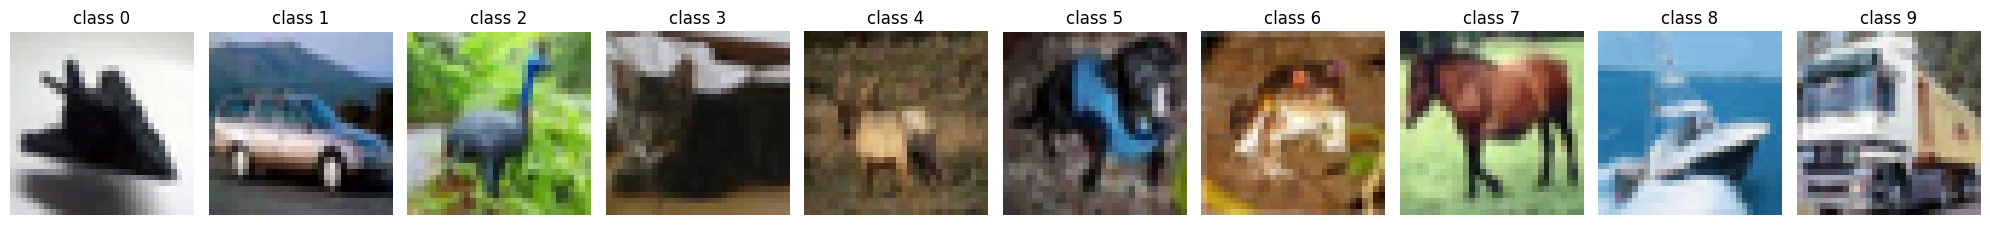

In [12]:
def quantize_image_4(img):
    # 4단위로 값을 내림 (0, 4, 8, ..., 252)
    return (img // 4) * 4

def visualize_quantized_one_per_class(class_images):
    fig, axes = plt.subplots(1, 10, figsize=(20, 3))
    classes = [str(i) for i in range(10)]

    for i in range(10):
        # 각 클래스에서 첫 번째 이미지를 선택
        img = class_images[i][0]
        # 4단위로 양자화
        quant_img = quantize_image_4(img)
        axes[i].imshow(quant_img)
        axes[i].set_title(f'class {classes[i]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# 클래스별로 한 장씩 4단위 양자화 후 시각화 실행
visualize_quantized_one_per_class(class_images)

# 결과 저장할 딕셔너리 준비
quantized_class_images = {i: [] for i in range(10)}

# 클래스별로 100장씩 양자화
for class_id, images in class_images.items():
    for img in images:
        quant_img = quantize_image_4(img)
        quantized_class_images[class_id].append(quant_img)

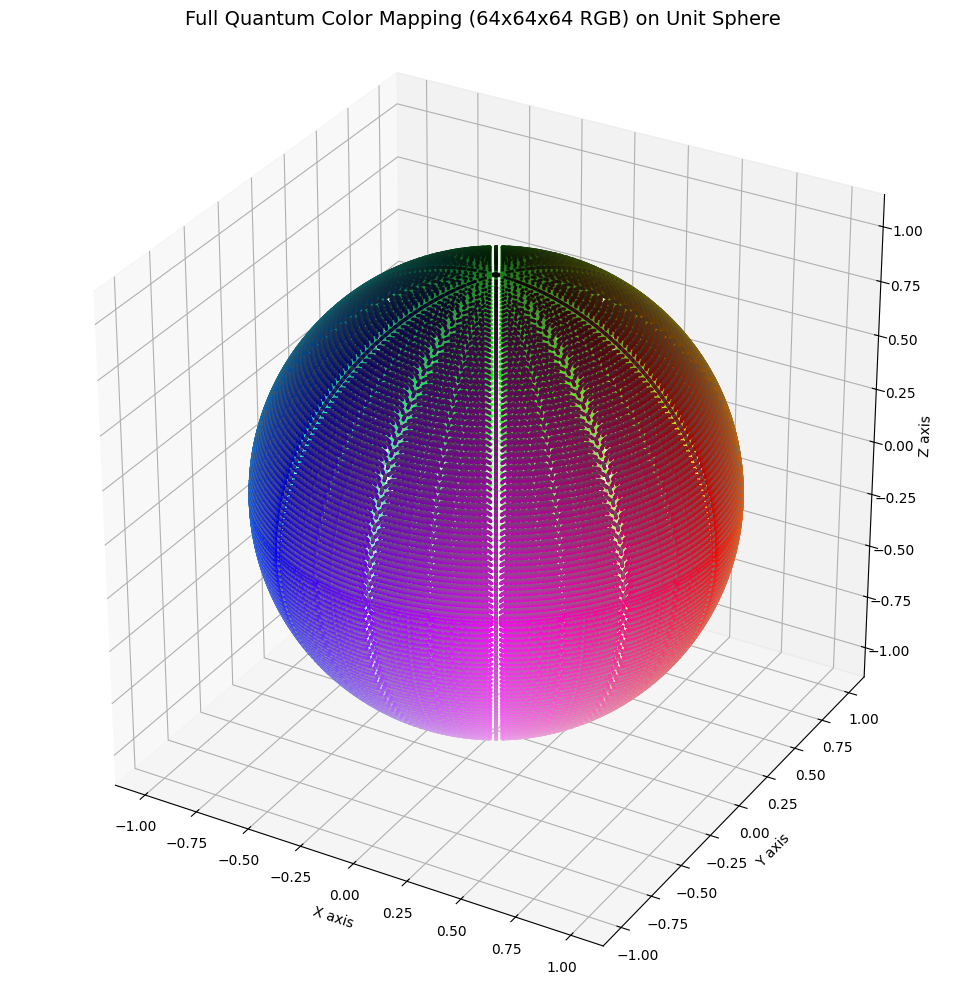

In [ ]:
import numpy as np

PI = np.pi

def compute_theta_fix(r, g, b):
    # 정수 입력 전제(0..63)
    M = int(max(r, g, b))   # 최대
    m = int(min(r, g, b))   # 최소
    l = M + m               # 합

    # === 북반구: l = 63 - a, a=1..62 ===
    if l < 63:
        a = 63 - l
        # 문헌/설계: 북반구는 M = 63 - a - i, m = i,  i=1..floor((63-a)/2)
        max_i = (63 - a) // 2
        i = m  # m==i 로부터 직접
        if 1 <= i <= max_i and (M == 63 - a - i):
            # θ = ((63 - a)/126)π + (π/252) - ((π/126) * (i+1)/(max_i+1))
            return ((63 - a) * PI / 126.0) + (PI / 252.0) - ((PI / 126.0) * (i + 1) / (max_i + 1))

        # 경계치(루프 범위 밖) 보정: i==0 또는 i>max_i 같은 특수 케이스는
        # 해당 링의 중앙값으로 매핑(충돌 방지용)
        # 링 중앙: ((63 - a)/126)π + (π/252) - (π/252)/2  = ((63 - a)/126)π + (π/252)/2
        return ((63 - a) * PI / 126.0) + (PI / 252.0) - ((PI / 126.0) * (i + 1) / (max_i + 1))

    # === 적도: l = 63 ===
    elif l == 63:
        # 설계: M = 63 - i, m = i,  i=0..31 (정의된 지그재그)
        i = m
        if i == 0:
            return PI / 2.0
        max_i = 63 // 2  # 31
        if 1 <= i <= max_i:
            if i % 2 == 0:  # 2,4,...,30  (남쪽으로 약간)
                return PI / 2.0 + (PI / 252.0) * (i / 30.0)
            else:           # 1,3,...,31  (북쪽으로 약간)
                return PI / 2.0 - (PI / 252.0) * ((i + 1) / 32.0)

        # 안전망(충돌 방지): 링 중앙
        return PI / 2.0

    # === 남반구: l = 63 + a, a=1..62 ===
    else:
        a = l - 63
        # 문헌/설계: 남반구는 M = 63 - i, m = a + i,  i=1..floor((63-a)/2)
        max_i = (63 - a) // 2
        i = 63 - M  # M = 63 - i  →  i = 63 - M
        if 1 <= i <= max_i and (m == a + i):
            # θ = ((63 + a)/126)π - (π/252) + ((π/126) * (i+1)/(max_i+1))
            return ((63 + a) * PI / 126.0) - (PI / 252.0) + ((PI / 126.0) * (i + 1) / (max_i + 1))

        # 경계/비정상 조합은 링 중앙으로(여기가 남반구 대량 충돌을 막는 핵심)
        # 링 중앙: ((63 + a)/126)π - (π/252) + (π/252)/2  = ((63 + a)/126)π - (π/504)
        return ((63 + a) * PI / 126.0) - (PI / 252.0) + ((PI / 126.0) * (i + 1) / (max_i + 1))
    
   # RGB → θ, ϕ 변환
def rgb_to_theta_phi_fix(r, g, b):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n
    i = (r + g + b) - n - m

    theta = compute_theta_fix(r, g, b)

    if m == n:
        phi = 0
    else:
        if r == m and b == n:
            k = i - b
            phi = (np.pi / 3) * k / (m - n)
        elif g == m and b == n:
            k = g - i
            phi = (np.pi / 3) * k / (m - n) + (np.pi / 3)
        elif g == m and r == n:
            k = i - r
            phi = (np.pi / 3) * k / (m - n) + (2 * np.pi / 3)
        elif b == m and r == n:
            k = b - i
            phi = (np.pi / 3) * k / (m - n) + (3 * np.pi / 3)
        elif b == m and g == n:
            k = i - g
            phi = (np.pi / 3) * k / (m - n) + (4 * np.pi / 3)
        elif r == m and g == n:
            k = r - i
            phi = (np.pi / 3) * k / (m - n) + (5 * np.pi / 3)
        else:
            phi = 0
    return theta, phi

# θ, ϕ → (x, y, z)
def theta_phi_to_xyz(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

# 전체 RGB 매핑
def map_full_rgb_fix():
    global coords, colors, polar_coords
    coords = []
    colors = []
    polar_coords = []
    rep_values = [0] + [i for i in range(4, 252, 4)] + [252]  # 64개의 값

    for r in rep_values:
        for g in rep_values:
            for b in rep_values:
                # 양자화된 값 → 0~63 범위로 mapping (compute_theta가 기대하는 입력)
                r63, g63, b63 = r // 4, g // 4, b // 4

                theta, phi = rgb_to_theta_phi_fix(r63, g63, b63)
                x, y, z = theta_phi_to_xyz(theta, phi)
                polar_coords.append((theta,phi))
                coords.append((x, y, z))
                colors.append((r / 255, g / 255, b / 255))  # for visual RGB color

    return np.array(coords), np.array(colors)

# 3D 시각화
def plot_full_quantum_color_sphere_fix():
    coords, colors = map_full_rgb_fix()
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=colors, s=2)
    ax.set_title('Full Quantum Color Mapping (64x64x64 RGB) on Unit Sphere', fontsize=14)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()
    return len(colors)

# 실행
total_colors = plot_full_quantum_color_sphere_fix()

In [14]:
def quantized_images_to_theta_phi_dict(quantized_class_images, rgb_to_theta_phi):
    """
    quantized_class_images: dict {class_id: [이미지, ...]}, 각 이미지 shape (32,32,3)
    rgb_to_theta_phi: (r,g,b) -> (theta, phi) 반환 함수
    """
    theta_phi_dict = {i: [] for i in range(10)}
    for class_id, images in quantized_class_images.items():
        for img in images:
            theta_phi_img = np.zeros((32, 32, 2), dtype=np.float32)
            # 0~63 변환 (이미 4단위 양자화이므로 //4)
            r63 = img[:, :, 0]
            g63 = img[:, :, 1]
            b63 = img[:, :, 2]
            for i in range(32):
                for j in range(32):
                    r, g, b = int(r63[i, j]), int(g63[i, j]), int(b63[i, j])
                    theta, phi = rgb_to_theta_phi(r, g, b)
                    theta_phi_img[i, j, 0] = theta
                    theta_phi_img[i, j, 1] = phi
            theta_phi_dict[class_id].append(theta_phi_img)
    return theta_phi_dict

# 방법 1: 새 dict 생성
quantized_class_images_div4 = {
    k: [arr / 4 for arr in v]
    for k, v in quantized_class_images.items()
}

theta_phi_dict = quantized_images_to_theta_phi_dict(quantized_class_images_div4, rgb_to_theta_phi_fix)

In [15]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

def _infer_data_range(img1, img2):
    # dtype/값 범위로 PSNR의 data_range 추정
    if np.issubdtype(img1.dtype, np.integer):
        return np.iinfo(img1.dtype).max
    if np.issubdtype(img1.dtype, np.floating):
        vmax = max(float(img1.max()), float(img2.max()))
        vmin = min(float(img1.min()), float(img2.min()))
        return 1.0 if (0.0 <= vmin and vmax <= 1.0) else (vmax - vmin)
    # fallback
    vmax = max(float(img1.max()), float(img2.max()))
    vmin = min(float(img1.min()), float(img2.min()))
    return vmax - vmin

def mse(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    return float(np.mean((img1 - img2) ** 2))

def psnr(img1, img2, data_range=None):
    if data_range is None:
        data_range = _infer_data_range(img1, img2)
    err = mse(img1, img2)
    if err == 0:
        return float("inf")
    return 20.0 * np.log10(data_range) - 10.0 * np.log10(err)

def ssim_color(img1, img2, data_range=None, win_size=11):
    """
    SSIM(컬러) – skimage 0.19+는 channel_axis, 구버전은 multichannel
    """
    if data_range is None:
        data_range = _infer_data_range(img1, img2)

    try:
        # skimage >= 0.19
        return float(ssim(img1, img2, data_range=data_range,
                          channel_axis=-1, gaussian_weights=True,
                          sigma=1.5, use_sample_covariance=False,
                          win_size=win_size))
    except TypeError:
        # skimage < 0.19
        return float(ssim(img1, img2, data_range=data_range,
                          multichannel=True, gaussian_weights=True,
                          sigma=1.5, use_sample_covariance=False,
                          win_size=win_size))

def compute_metrics(img1, img2, data_range=None):
    """
    img1, img2: H×W×3 (RGB), dtype은 uint8 또는 float
    반환: {'mse':..., 'psnr':..., 'ssim':...}
    """
    assert img1.shape == img2.shape, f"크기가 다릅니다: {img1.shape} vs {img2.shape}"
    assert img1.ndim == 3 and img1.shape[-1] == 3, "입력은 H×W×3 컬러 이미지여야 합니다."

    m = mse(img1, img2)
    p = psnr(img1, img2, data_range=data_range)
    s = ssim_color(img1, img2, data_range=data_range)
    return {"mse": m, "psnr": p, "ssim": s}

In [18]:
img = theta_phi_dict[0][0]

img_theta = img[:, :, 0]
img_phi   = img[:, :, 1]

thetas = np.round(img_theta/2, 4).flatten().tolist()  # (라디안) /2 인코딩 스케일
phis = np.where(
    img_phi < 0,
    np.round((6.283 - np.abs(img_phi)) / 4, 4),
    np.round(img_phi / 4, 4)
).flatten().tolist()

H, W = img_theta.shape
len_img = H*W  # 주소 개수

# 주소 비트수
w_bits = int(np.ceil(math.log(W, 2))) or 1
h_bits = int(np.ceil(math.log(H, 2))) or 1
num_ind_bits = w_bits + h_bits or 1

# --------------------------------------------------
# 회로 생성: c_theta, c_phi (보조 2개), 주소 O
# --------------------------------------------------
O      = QuantumRegister(num_ind_bits, 'addr')
cT     = QuantumRegister(1, 'c_theta')
cP     = QuantumRegister(1, 'c_phi')
# 샷 방식 쓸 거면 아래 classical 생성/측정 주석 해제
cr     = ClassicalRegister(O.size + cT.size + cP.size, "cl")

# 샷 없이 statevector만 쓰면 ClassicalRegister 불필요
qc = QuantumCircuit(cT, cP, O,cr)  # 레지스터 순서: [cT][cP][O...]

# 주소를 균등 중첩으로
qc.h(O)
qc.id(cT)
qc.id(cP)

controls = list(O)

# 주소 i를 all-ones 컨트롤로 맞춰 주는 토글 방식 (당신 코드와 같은 스타일)
for i, (phi, theta) in enumerate(zip(phis, thetas)):
    bits = f"{i:0{num_ind_bits}b}"
    # 해당 주소로 만들기: '1'인 자리에 X
    for k, b in enumerate(bits):
        if b == '1':
            qc.x(O[k])

    # --- θ 인코딩 (target=cT) ---
    qc.mcry(theta=2*theta, q_controls=controls, q_target=cT[0])
    # --- φ 인코딩 (target=cP) ---
    qc.mcry(theta=2*phi,   q_controls=controls, q_target=cP[0])

    # 주소 uncompute
    for k, b in enumerate(bits):
        if b == '1':
            qc.x(O[k])

qc.measure(list(reversed(range(qc.num_qubits))), list(range(cr.size)))

# ---------------------------------------------
# 4) 샷 실행
# ---------------------------------------------
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
result = aer_sim.run(t_qc, shots=50000000).result()
counts = result.get_counts()

# ---------------------------------------------
# 5) counts → θ/φ 복원
#    key = [cφ][cθ][addr_bits],  amount = 샷 수
#    P0_theta = (cθ=0 | addr) = (Σ cφ∈{0,1} counts[cφ,0,addr]) / (Σ cφ,cθ counts)
#    P0_phi   = (cφ=0 | addr) = (Σ cθ∈{0,1} counts[0,cθ,addr]) / (Σ cφ,cθ counts)
# ---------------------------------------------
# 주소별 누적 버킷
sum_addr      = np.zeros(len_img, dtype=np.int64)  # Σ(cφ,cθ) counts
sum_theta0    = np.zeros(len_img, dtype=np.int64)  # Σ(cφ) counts for cθ=0
sum_phi0      = np.zeros(len_img, dtype=np.int64)  # Σ(cθ) counts for cφ=0

def addr_str_to_int(addr_bits):
    # addr_bits는 MSB..LSB로 되어 있음
    return int(addr_bits, 2)

for key, nshots in counts.items():
    # key[0]=cφ, key[1]=cθ, key[2:]=addr(MSB..LSB)
    cphi = int(key[1])
    cth  = int(key[0])
    addr_bits = key[2:]
    idx = addr_str_to_int(addr_bits)
    if idx >= len_img:
        continue

    sum_addr[idx] += nshots
    if cth == 0:
        sum_theta0[idx] += nshots
    if cphi == 0:
        sum_phi0[idx] += nshots

# 확률 → 각도 복원
# Ry(2α): P(0) = cos^2(α) → α = arccos( sqrt(P0) )
pixel_theta_recon = []
pixel_phi_recon   = []

for i in range(len_img):
    denom = sum_addr[i]
    if denom == 0:
        pixel_theta_recon.append(0.0)
        pixel_phi_recon.append(0.0)
        continue
    P0_theta = sum_theta0[i] / denom
    P0_phi   = sum_phi0[i]   / denom

    # 안정화
    P0_theta = min(max(P0_theta, 0.0), 1.0)
    P0_phi   = min(max(P0_phi,   0.0), 1.0)

    alpha_theta = np.arccos(np.sqrt(P0_theta))
    alpha_phi   = np.arccos(np.sqrt(P0_phi))
    pixel_theta_recon.append(2.0 * alpha_theta)  # /2 보정
    pixel_phi_recon.append(4.0 * alpha_phi)      # /4 보정

# ---------------------------------------------
# 6) MSE
# ---------------------------------------------
arr_theta_recon = np.array(pixel_theta_recon)
arr_phi_recon   = np.array(pixel_phi_recon)

H, W = img_theta.shape   # 또는 별도 변수로 보유

def reorder_by_double_flip(arr_1d, H, W):
    img = arr_1d.reshape(H, W)
    # 방법 1: 상하 뒤집고 좌우 뒤집기
    img_fix = np.flipud(np.fliplr(img))
    # (동일) 방법 2: 180도 회전
    # img_fix = np.rot90(img, k=2)
    return img_fix.reshape(-1)  # 1D로 복원 (C-order)

arr_theta_recon = reorder_by_double_flip(arr_theta_recon, H, W)
arr_phi_recon   = reorder_by_double_flip(arr_phi_recon,   H, W)

arr_img_theta = img_theta.flatten()
arr_img_phi   = img_phi.flatten()

mse_theta = np.mean((arr_theta_recon - arr_img_theta)**2)
mse_phi   = np.mean((arr_phi_recon   - arr_img_phi)**2)
print("MSE(theta):", mse_theta)
print("MSE(phi):",   mse_phi)

MSE(theta): 2.6807075544890103e-05
MSE(phi): 5.871796570661946e-05


In [97]:
import numpy as np
from itertools import product

def fill_missing_counts(counts, n=2):
    """누락된 측정결과를 0으로 채움"""
    filled = dict(counts)
    for bits in map(''.join, product('01', repeat=n)):
        filled.setdefault(bits, 0)
    return filled

def compute_theta_phi(counts):
    """
    counts: {'00': ..., '01': ..., '10': ..., '11': ...}
    key = 첫 비트: 측정값(0/1)
          둘째 비트: 0=phi, 1=theta 구분
    φ = 4 * arccos( sqrt( (00) / (00+10) ) )
    θ = 2 * arccos( sqrt( (01) / (01+11) ) )
    """
    c = fill_missing_counts(counts)

    # 0으로 나누는 경우 대비
    phi_denom = c['00'] + c['10']
    theta_denom = c['01'] + c['11']

    phi = np.nan
    theta = np.nan
    if phi_denom > 0:
        phi = 4 * np.arccos(np.sqrt(c['00'] / phi_denom))
    if theta_denom > 0:
        theta = 2 * np.arccos(np.sqrt(c['01'] / theta_denom))

    return theta, phi

In [99]:
def approximate_rgb_fix(arr_theta, arr_phi, lut_df):
    global mismatches

    # ✅ 스칼라 입력일 경우에도 1D 배열로 변환
    arr_theta = np.atleast_1d(arr_theta)
    arr_phi   = np.atleast_1d(arr_phi)

    theta_lower = lut_df["theta_lower"].values
    theta_upper = lut_df["theta_upper"].values
    phi_left    = lut_df["phi_left"].values
    phi_right   = lut_df["phi_right"].values
    r = lut_df["r"].values
    g = lut_df["g"].values
    b = lut_df["b"].values

    N = arr_theta.shape[0]
    approx_rgb = np.zeros((N, 3), dtype=np.uint8)

    mismatches = []

    for idx in range(N):
        theta = arr_theta[idx]
        phi = arr_phi[idx]

        cond_theta = (theta_lower <= theta) & (theta <= theta_upper)
        cond_phi = np.where(
            phi_left <= phi_right,
            (phi_left <= phi) & (phi <= phi_right),
            (phi_left <= phi) | (phi <= phi_right)
        )
        cond = cond_theta & cond_phi
        match_idxs = np.where(cond)[0]
        if len(match_idxs) > 0:
            match = match_idxs[0]
            approx_rgb[idx, 0] = r[match]
            approx_rgb[idx, 1] = g[match]
            approx_rgb[idx, 2] = b[match]
        else:
            approx_rgb[idx, :] = 0
            mismatches.append((idx, theta, phi))

    if mismatches:
        print("❌ 미매칭된 theta, phi:")
        for m in mismatches:
            print(f"Index {m[0]}: theta={m[1]}, phi={m[2]}")

    return approx_rgb

In [148]:
from qiskit_aer import AerSimulator

df = pd.read_csv("64/64 RGB coords_with_bounds.csv")
aer_sim = AerSimulator(method='matrix_product_state')  # 빠르고 정확
#aer_sim = Aer.get_backend('aer_simulator')

theta_ground = img_theta[-1][-10]
phi_ground = img_phi[-1][-10]

theta_prime_per_shots = []
phi_prime_per_shots = []
approxed_rgb_per_shots = []

theta_error_per_shots = []
phi_error_per_shots = []

c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'anxilia')
cr = ClassicalRegister(c.size+p.size, "cl")

for i in range(99):
    qc_image = QuantumCircuit(c,p,cr)
    qc_image.h(p)
    qc_image.cry(theta_ground,p,c)
    qc_image.x(p)
    qc_image.cry(phi_ground*0.5,p,c)
    qc_image.x(p)
    qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))
    t_qc_image = transpile(qc_image, aer_sim, optimization_level=3)
    result = aer_sim.run(t_qc_image, shots= 20000 + 10000 * i).result()
    counts = result.get_counts()

    theta_prime, phi_prime = compute_theta_phi(counts)
    theta_error = theta_prime - theta_ground
    phi_error = phi_prime - phi_ground
    approx_rgb = approximate_rgb_fix(theta_prime, phi_prime, df)
    theta_prime_per_shots.append(theta_prime)
    phi_prime_per_shots.append(phi_prime)
    theta_error_per_shots.append(theta_error)
    phi_error_per_shots.append(phi_error)
    approxed_rgb_per_shots.append(approx_rgb)

   shots  theta_prime  phi_prime  theta_error  phi_error
0  20000     1.536460        0.0     0.003063        0.0
1  30000     1.533939        0.0     0.000542        0.0
2  40000     1.535852        0.0     0.002456        0.0
3  50000     1.540413        0.0     0.007017        0.0
4  60000     1.525905        0.0    -0.007491        0.0

총 99회 측정 결과 정리 완료


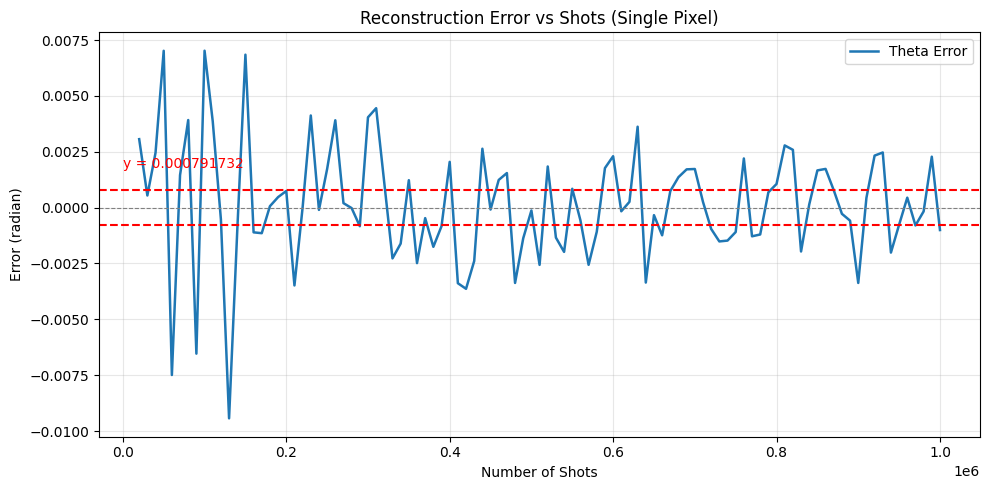

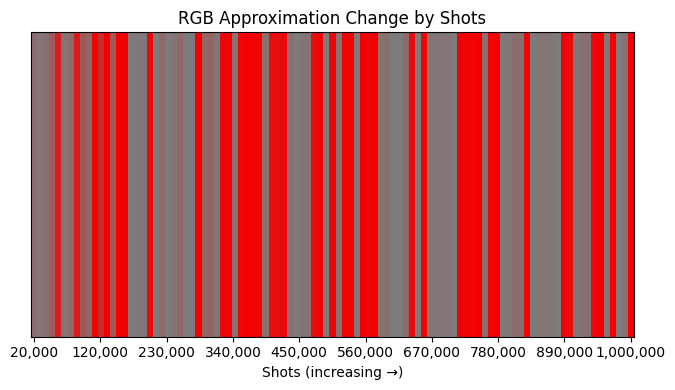

가장 정확한 복원 (θ 기준): shots=220000, theta_error=0.000007, phi_error=0.000000, approx RGB=[[124 124 124]]


In [149]:
# shots 증가량
shots_list = [20000 + 10000 * i for i in range(99)]

# ===== ① DataFrame 표로 정리 =====
df_results = pd.DataFrame({
    'shots': shots_list,
    'theta_prime': theta_prime_per_shots,
    'phi_prime': phi_prime_per_shots,
    'theta_error': theta_error_per_shots,
    'phi_error': phi_error_per_shots
})
print(df_results.head())
print(f"\n총 {len(df_results)}회 측정 결과 정리 완료")

# ===== ② θ, φ 에러 시각화 =====
plt.figure(figsize=(10, 5))
plt.plot(df_results['shots'], df_results['theta_error'], label='Theta Error', color='tab:blue', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y= 0.000791732, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y= -0.000791732, color='red', linestyle='--', linewidth=1.5)
plt.text(0, 0.000791732 + 0.001, "y = 0.000791732", color='red', fontsize=10)
plt.title('Reconstruction Error vs Shots (Single Pixel)')
plt.xlabel('Number of Shots')
plt.ylabel('Error (radian)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== ③ RGB 근사 색상 변화 시각화 =====
# approxed_rgb_per_shots: [(r,g,b), (r,g,b), ...]
rgb_arr = np.array(approxed_rgb_per_shots, dtype=np.uint8)
num_samples = len(rgb_arr)

fig, ax = plt.subplots(figsize=(60, 4))
# RGB를 1xN 컬러바 형태로 표시
rgb_bar = np.zeros((50, num_samples, 3), dtype=np.uint8)
for i in range(num_samples):
    rgb_bar[:, i, :] = rgb_arr[i]
ax.imshow(rgb_bar)
ax.set_title("RGB Approximation Change by Shots")
ax.set_xlabel("Shots (increasing →)")
ax.set_yticks([])
ax.set_xticks(np.linspace(0, num_samples-1, 10))
ax.set_xticklabels([f"{shots_list[int(x)]:,}" for x in np.linspace(0, num_samples-1, 10).astype(int)])
plt.tight_layout()
plt.show()

# ===== ④ 요약 출력 =====
best_idx = np.argmin(np.abs(df_results['theta_error']))  # θ 에러 최소일 때
print(f"가장 정확한 복원 (θ 기준): shots={shots_list[best_idx]}, "
      f"theta_error={df_results['theta_error'][best_idx]:.6f}, "
      f"phi_error={df_results['phi_error'][best_idx]:.6f}, "
      f"approx RGB={approxed_rgb_per_shots[best_idx]}")

   shots  theta_prime  phi_prime  theta_error  phi_error
0  20000     1.536460        0.0     0.003063        0.0
1  30000     1.533939        0.0     0.000542        0.0
2  40000     1.535852        0.0     0.002456        0.0
3  50000     1.540413        0.0     0.007017        0.0
4  60000     1.525905        0.0    -0.007491        0.0

총 99회 측정 결과 정리 완료


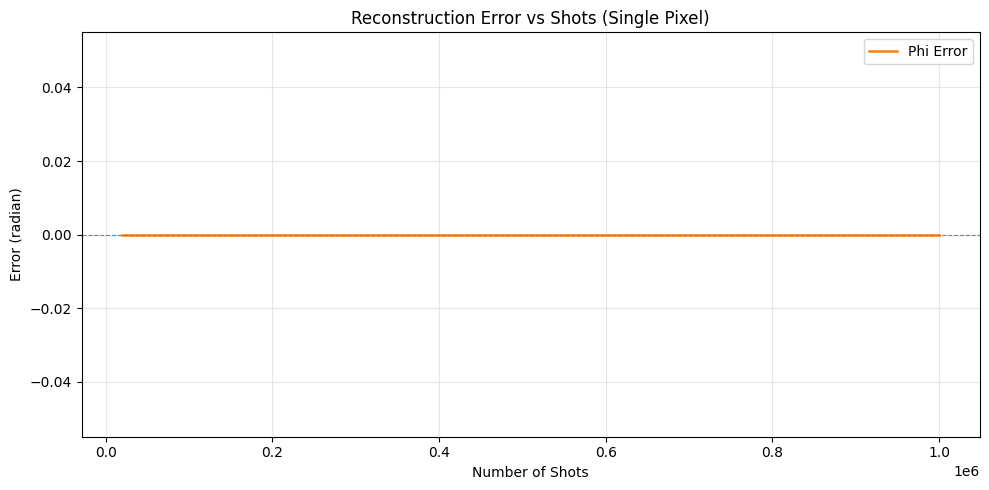

In [150]:
# shots 증가량
shots_list = [20000 + 10000 * i for i in range(99)]

# ===== ① DataFrame 표로 정리 =====
df_results = pd.DataFrame({
    'shots': shots_list,
    'theta_prime': theta_prime_per_shots,
    'phi_prime': phi_prime_per_shots,
    'theta_error': theta_error_per_shots,
    'phi_error': phi_error_per_shots
})
print(df_results.head())
print(f"\n총 {len(df_results)}회 측정 결과 정리 완료")

# ===== ② θ, φ 에러 시각화 =====
plt.figure(figsize=(10, 5))
plt.plot(df_results['shots'], df_results['phi_error'], label='Phi Error', color='tab:orange', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title('Reconstruction Error vs Shots (Single Pixel)')
plt.xlabel('Number of Shots')
plt.ylabel('Error (radian)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [151]:
from qiskit_aer import AerSimulator

df = pd.read_csv("64/64 RGB coords_with_bounds.csv")
#aer_sim = AerSimulator(method='matrix_product_state')  # 빠르고 정확
aer_sim = Aer.get_backend('aer_simulator')

theta_ground = img_theta[-1][-10]
phi_ground = img_phi[-1][-10]

theta_prime_per_shots = []
phi_prime_per_shots = []
approxed_rgb_per_shots = []

theta_error_per_shots = []
phi_error_per_shots = []

c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'anxilia')
cr = ClassicalRegister(c.size+p.size, "cl")

for i in range(99):
    qc_image = QuantumCircuit(c,p,cr)
    qc_image.h(p)
    qc_image.cry(theta_ground,p,c)
    qc_image.x(p)
    qc_image.cry(phi_ground*0.5,p,c)
    qc_image.x(p)
    qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))
    t_qc_image = transpile(qc_image, aer_sim, optimization_level=3)
    result = aer_sim.run(t_qc_image, shots= 20000 + 10000 * i).result()
    counts = result.get_counts()

    theta_prime, phi_prime = compute_theta_phi(counts)
    theta_error = theta_prime - theta_ground
    phi_error = phi_prime - phi_ground
    approx_rgb = approximate_rgb_fix(theta_prime, phi_prime, df)
    theta_prime_per_shots.append(theta_prime)
    phi_prime_per_shots.append(phi_prime)
    theta_error_per_shots.append(theta_error)
    phi_error_per_shots.append(phi_error)
    approxed_rgb_per_shots.append(approx_rgb)

   shots  theta_prime  phi_prime  theta_error  phi_error
0  20000     1.512236        0.0    -0.021160        0.0
1  30000     1.531249        0.0    -0.002148        0.0
2  40000     1.527781        0.0    -0.005615        0.0
3  50000     1.531545        0.0    -0.001852        0.0
4  60000     1.530213        0.0    -0.003184        0.0

총 99회 측정 결과 정리 완료


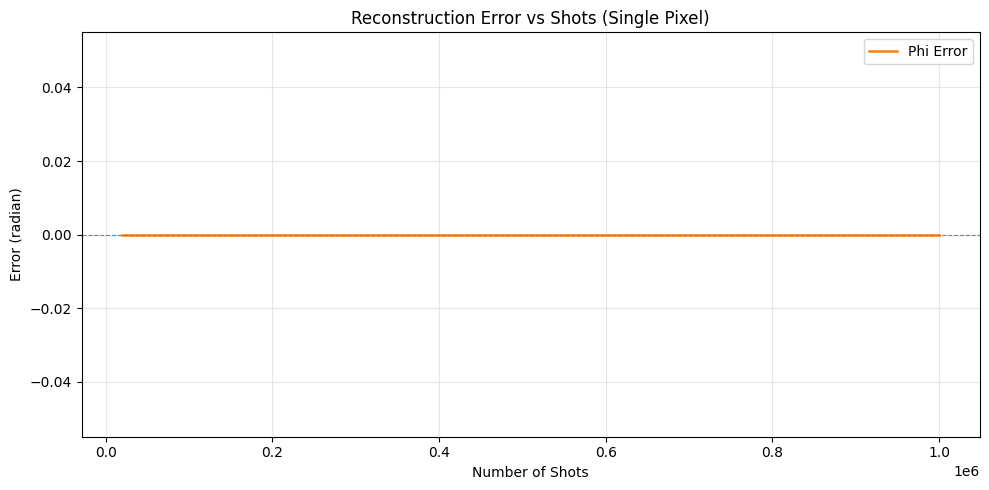

In [152]:
# shots 증가량
shots_list = [20000 + 10000 * i for i in range(99)]

# ===== ① DataFrame 표로 정리 =====
df_results = pd.DataFrame({
    'shots': shots_list,
    'theta_prime': theta_prime_per_shots,
    'phi_prime': phi_prime_per_shots,
    'theta_error': theta_error_per_shots,
    'phi_error': phi_error_per_shots
})
print(df_results.head())
print(f"\n총 {len(df_results)}회 측정 결과 정리 완료")

# ===== ② θ, φ 에러 시각화 =====
plt.figure(figsize=(10, 5))
plt.plot(df_results['shots'], df_results['phi_error'], label='Phi Error', color='tab:orange', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title('Reconstruction Error vs Shots (Single Pixel)')
plt.xlabel('Number of Shots')
plt.ylabel('Error (radian)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

   shots  theta_prime  phi_prime  theta_error  phi_error
0  20000     1.512236        0.0    -0.021160        0.0
1  30000     1.531249        0.0    -0.002148        0.0
2  40000     1.527781        0.0    -0.005615        0.0
3  50000     1.531545        0.0    -0.001852        0.0
4  60000     1.530213        0.0    -0.003184        0.0

총 99회 측정 결과 정리 완료


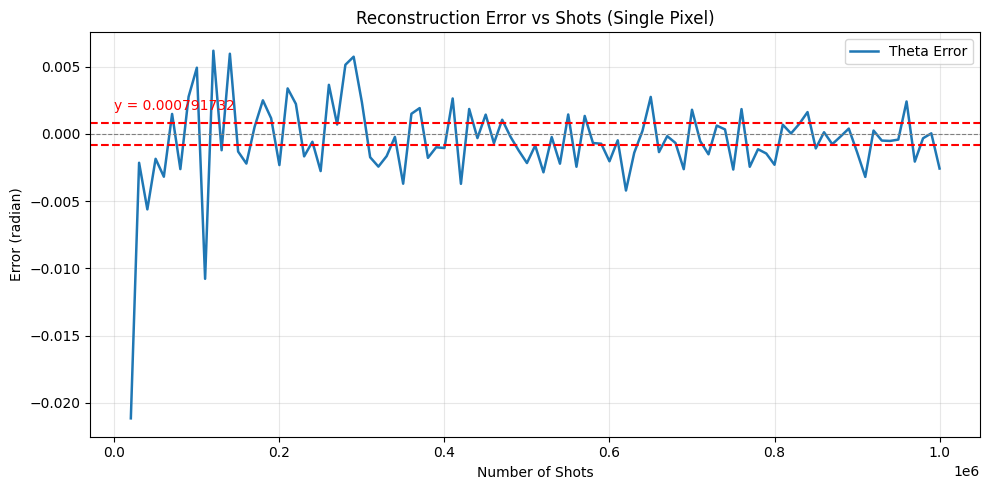

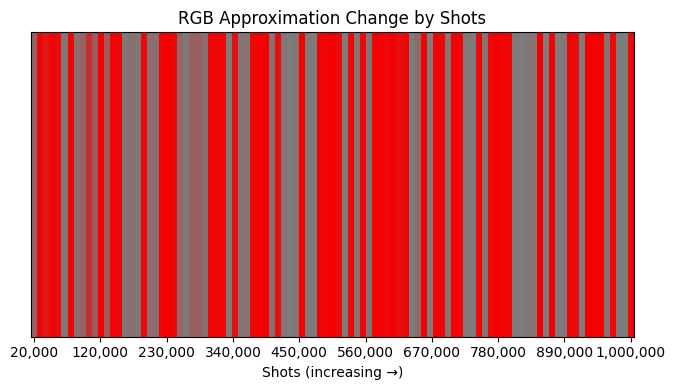

가장 정확한 복원 (θ 기준): shots=820000, theta_error=0.000033, phi_error=0.000000, approx RGB=[[124 124 124]]


In [153]:
# shots 증가량
shots_list = [20000 + 10000 * i for i in range(99)]

# ===== ① DataFrame 표로 정리 =====
df_results = pd.DataFrame({
    'shots': shots_list,
    'theta_prime': theta_prime_per_shots,
    'phi_prime': phi_prime_per_shots,
    'theta_error': theta_error_per_shots,
    'phi_error': phi_error_per_shots
})
print(df_results.head())
print(f"\n총 {len(df_results)}회 측정 결과 정리 완료")

# ===== ② θ, φ 에러 시각화 =====
plt.figure(figsize=(10, 5))
plt.plot(df_results['shots'], df_results['theta_error'], label='Theta Error', color='tab:blue', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y= 0.000791732, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y= -0.000791732, color='red', linestyle='--', linewidth=1.5)
plt.text(0, 0.000791732 + 0.001, "y = 0.000791732", color='red', fontsize=10)
plt.title('Reconstruction Error vs Shots (Single Pixel)')
plt.xlabel('Number of Shots')
plt.ylabel('Error (radian)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== ③ RGB 근사 색상 변화 시각화 =====
# approxed_rgb_per_shots: [(r,g,b), (r,g,b), ...]
rgb_arr = np.array(approxed_rgb_per_shots, dtype=np.uint8)
num_samples = len(rgb_arr)

fig, ax = plt.subplots(figsize=(60, 4))
# RGB를 1xN 컬러바 형태로 표시
rgb_bar = np.zeros((50, num_samples, 3), dtype=np.uint8)
for i in range(num_samples):
    rgb_bar[:, i, :] = rgb_arr[i]
ax.imshow(rgb_bar)
ax.set_title("RGB Approximation Change by Shots")
ax.set_xlabel("Shots (increasing →)")
ax.set_yticks([])
ax.set_xticks(np.linspace(0, num_samples-1, 10))
ax.set_xticklabels([f"{shots_list[int(x)]:,}" for x in np.linspace(0, num_samples-1, 10).astype(int)])
plt.tight_layout()
plt.show()

# ===== ④ 요약 출력 =====
best_idx = np.argmin(np.abs(df_results['theta_error']))  # θ 에러 최소일 때
print(f"가장 정확한 복원 (θ 기준): shots={shots_list[best_idx]}, "
      f"theta_error={df_results['theta_error'][best_idx]:.6f}, "
      f"phi_error={df_results['phi_error'][best_idx]:.6f}, "
      f"approx RGB={approxed_rgb_per_shots[best_idx]}")

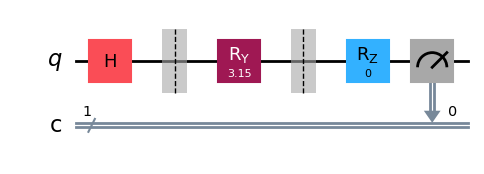

In [161]:
qc = QuantumCircuit(1, 1)
qc.h(0)
qc.barrier()
qc.ry(theta, 0)
qc.barrier()    # polar rotation
qc.rz(phi, 0)   # azimuthal rotation
qc.measure(0,0)    
qc.draw('mpl')

In [155]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

aer_sim = AerSimulator()

def build_theta_phi_circuit(theta, phi):
    """
    Bloch 구면 상의 (θ, φ) 상태를 명확히 인코딩하고
    독립 측정을 통해 θ', φ' 복원할 수 있도록 구성.
    """
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)    # polar rotation
    qc.rz(phi, 0)      # azimuthal rotation
    return qc

def measure_expectations(theta, phi, shots):
    # base circuit
    qc = build_theta_phi_circuit(theta, phi)

    # Z-basis (for ⟨Z⟩ = cosθ)
    qc_z = qc.copy()
    qc_z.measure(0, 0)
    result_z = aer_sim.run(transpile(qc_z, aer_sim), shots=shots).result()
    counts_z = result_z.get_counts()
    p0_z = counts_z.get('0', 0) / shots
    expect_z = 2*p0_z - 1

    # X-basis (for ⟨X⟩ = sinθ cosφ)
    qc_x = qc.copy()
    qc_x.h(0)
    qc_x.measure(0, 0)
    result_x = aer_sim.run(transpile(qc_x, aer_sim), shots=shots).result()
    counts_x = result_x.get_counts()
    p0_x = counts_x.get('0', 0) / shots
    expect_x = 2*p0_x - 1

    # Y-basis (for ⟨Y⟩ = sinθ sinφ)
    qc_y = qc.copy()
    qc_y.sdg(0)
    qc_y.h(0)
    qc_y.measure(0, 0)
    result_y = aer_sim.run(transpile(qc_y, aer_sim), shots=shots).result()
    counts_y = result_y.get_counts()
    p0_y = counts_y.get('0', 0) / shots
    expect_y = 2*p0_y - 1

    # 복원
    theta_prime = np.arccos(np.clip(expect_z, -1, 1))
    phi_prime = np.arctan2(expect_y, expect_x)
    if phi_prime < 0:
        phi_prime += 2*np.pi

    return theta_prime, phi_prime, expect_x, expect_y, expect_z


In [156]:
shots_list = [20000 + 10000 * i for i in range(99)]
theta_ground = img_theta[-1][-10]
phi_ground = 0.0

results = []
for shots in shots_list:
    theta_p, phi_p, ex, ey, ez = measure_expectations(theta_ground, phi_ground, shots)
    err_theta = theta_p - theta_ground
    err_phi = phi_p - phi_ground
    results.append((shots, theta_p, phi_p, err_theta, err_phi))
    print(f"{shots=}, θ'={theta_p:.6f}, φ'={phi_p:.6f}, Δθ={err_theta:.2e}, Δφ={err_phi:.2e}")


shots=20000, θ'=1.537690, φ'=0.006005, Δθ=4.29e-03, Δφ=6.00e-03
shots=30000, θ'=1.528784, φ'=0.011071, Δθ=-4.61e-03, Δφ=1.11e-02
shots=40000, θ'=1.529685, φ'=6.270226, Δθ=-3.71e-03, Δφ=6.27e+00
shots=50000, θ'=1.529865, φ'=6.281544, Δθ=-3.53e-03, Δφ=6.28e+00
shots=60000, θ'=1.521543, φ'=0.000300, Δθ=-1.19e-02, Δφ=3.00e-04
shots=70000, θ'=1.537933, φ'=0.000829, Δθ=4.54e-03, Δφ=8.29e-04
shots=80000, θ'=1.533438, φ'=0.001901, Δθ=4.13e-05, Δφ=1.90e-03
shots=90000, θ'=1.534877, φ'=6.282563, Δθ=1.48e-03, Δφ=6.28e+00
shots=100000, θ'=1.531526, φ'=0.000020, Δθ=-1.87e-03, Δφ=2.00e-05
shots=110000, θ'=1.537554, φ'=6.282658, Δθ=4.16e-03, Δφ=6.28e+00
shots=120000, θ'=1.523545, φ'=6.282401, Δθ=-9.85e-03, Δφ=6.28e+00
shots=130000, θ'=1.533480, φ'=0.002710, Δθ=8.36e-05, Δφ=2.71e-03
shots=140000, θ'=1.532801, φ'=6.281527, Δθ=-5.95e-04, Δφ=6.28e+00
shots=150000, θ'=1.531093, φ'=6.281864, Δθ=-2.30e-03, Δφ=6.28e+00
shots=160000, θ'=1.530823, φ'=6.281759, Δθ=-2.57e-03, Δφ=6.28e+00
shots=170000, θ'=1.53547

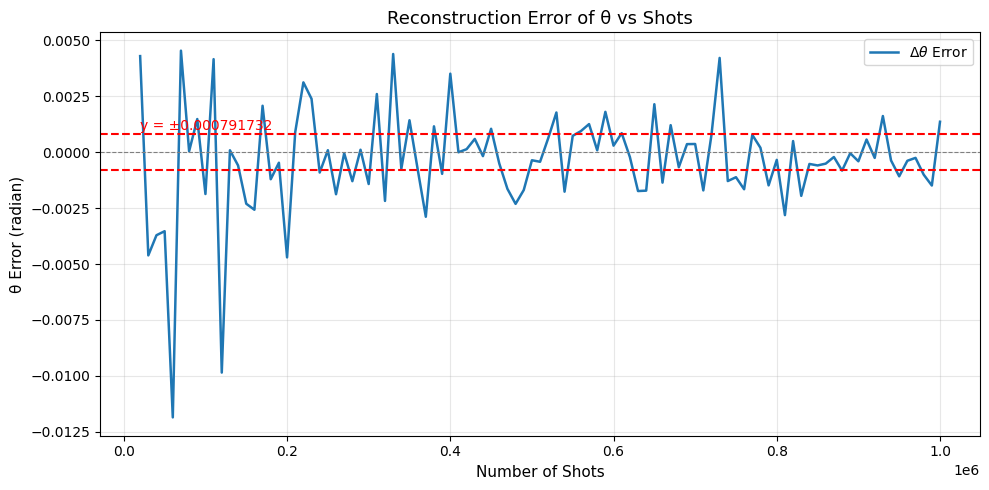

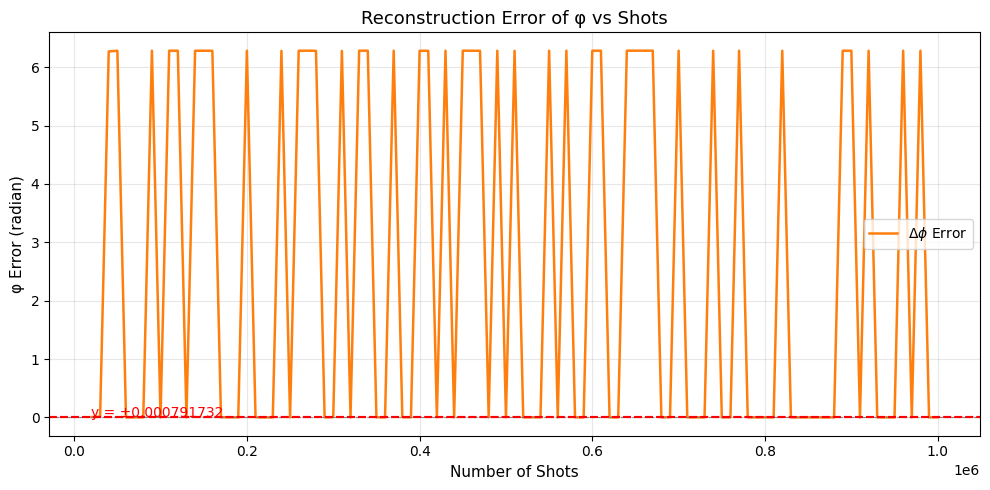

❌ 미매칭된 theta, phi:
Index 0: theta=1.52986489845709, phi=6.281544127002291
❌ 미매칭된 theta, phi:
Index 0: theta=1.5348774926589872, phi=6.282562642253831
❌ 미매칭된 theta, phi:
Index 0: theta=1.5375538409907255, phi=6.282657727545811
❌ 미매칭된 theta, phi:
Index 0: theta=1.523545412974443, phi=6.282401412215313
❌ 미매칭된 theta, phi:
Index 0: theta=1.5328014715496825, phi=6.2815269339071715
❌ 미매칭된 theta, phi:
Index 0: theta=1.53109256285513, phi=6.281864286357993
❌ 미매칭된 theta, phi:
Index 0: theta=1.5308231824487721, phi=6.281759399128981
❌ 미매칭된 theta, phi:
Index 0: theta=1.528693889326902, phi=6.282514972112407
❌ 미매칭된 theta, phi:
Index 0: theta=1.5324869569607125, phi=6.280408324141675
❌ 미매칭된 theta, phi:
Index 0: theta=1.5315169963488857, phi=6.282030937632087
❌ 미매칭된 theta, phi:
Index 0: theta=1.5321009565982062, phi=6.280412083117329
❌ 미매칭된 theta, phi:
Index 0: theta=1.5359957544545726, phi=6.27964725870931
❌ 미매칭된 theta, phi:
Index 0: theta=1.5377842704484725, phi=6.283124660320258
❌ 미매칭된 theta, phi:

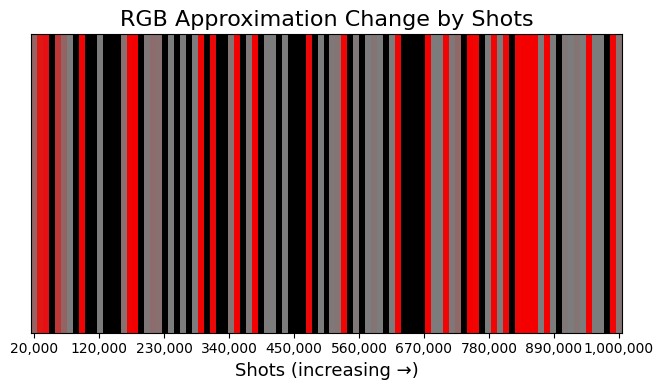

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ===== ① 입력 및 결과 준비 =====
# results = [(shots, theta_p, phi_p, err_theta, err_phi)]  ← 이전 단계에서 생성
# df = LUT CSV (64/64_RGB_coords_with_bounds.csv)
# approximate_rgb_fix(theta, phi, df) 함수가 이미 정의되어 있다고 가정

# ----- shots별 데이터 분리 -----
shots_list      = [r[0] for r in results]
theta_prime_all = [r[1] for r in results]
phi_prime_all   = [r[2] for r in results]
err_theta_all   = [r[3] for r in results]
err_phi_all     = [r[4] for r in results]

# ===== ② θ 오차 시각화 =====
plt.figure(figsize=(10, 5))
plt.plot(shots_list, err_theta_all, label=r'$\Delta \theta$ Error', color='tab:blue', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y= 0.000791732, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=-0.000791732, color='red', linestyle='--', linewidth=1.5)
plt.text(shots_list[0], 0.000791732 + 0.0002, "y = ±0.000791732", color='red', fontsize=10)
plt.title('Reconstruction Error of θ vs Shots', fontsize=13)
plt.xlabel('Number of Shots', fontsize=11)
plt.ylabel('θ Error (radian)', fontsize=11)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== ③ φ 오차 시각화 =====
plt.figure(figsize=(10, 5))
plt.plot(shots_list, err_phi_all, label=r'$\Delta \phi$ Error', color='tab:orange', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y= 0.000791732, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=-0.000791732, color='red', linestyle='--', linewidth=1.5)
plt.text(shots_list[0], 0.000791732 + 0.0002, "y = ±0.000791732", color='red', fontsize=10)
plt.title('Reconstruction Error of φ vs Shots', fontsize=13)
plt.xlabel('Number of Shots', fontsize=11)
plt.ylabel('φ Error (radian)', fontsize=11)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== ④ RGB 근사 =====
approxed_rgb_per_shots = []
for th, ph in zip(theta_prime_all, phi_prime_all):
    approx_rgb = approximate_rgb_fix(th, ph, df)
    approxed_rgb_per_shots.append(approx_rgb)

# ===== ⑤ RGB 근사 색상 변화 시각화 =====
rgb_arr = np.array(approxed_rgb_per_shots, dtype=np.uint8)
num_samples = len(rgb_arr)

fig, ax = plt.subplots(figsize=(60, 4))
rgb_bar = np.zeros((50, num_samples, 3), dtype=np.uint8)
for i in range(num_samples):
    rgb_bar[:, i, :] = rgb_arr[i]

ax.imshow(rgb_bar)
ax.set_title("RGB Approximation Change by Shots", fontsize=16)
ax.set_xlabel("Shots (increasing →)", fontsize=13)
ax.set_yticks([])
ax.set_xticks(np.linspace(0, num_samples - 1, 10))
ax.set_xticklabels([f"{shots_list[int(x)]:,}" for x in np.linspace(0, num_samples - 1, 10).astype(int)])
plt.tight_layout()
plt.show()


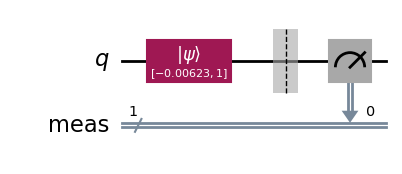

In [171]:
qc_init = QuantumCircuit(1)
qc_init.initialize([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)], 0)
qc_init.measure_all()
qc_init.draw('mpl')

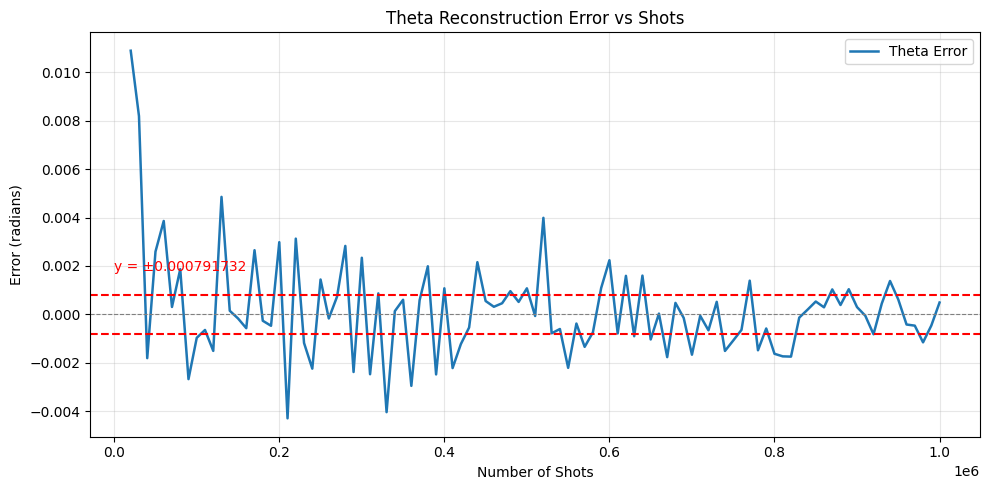

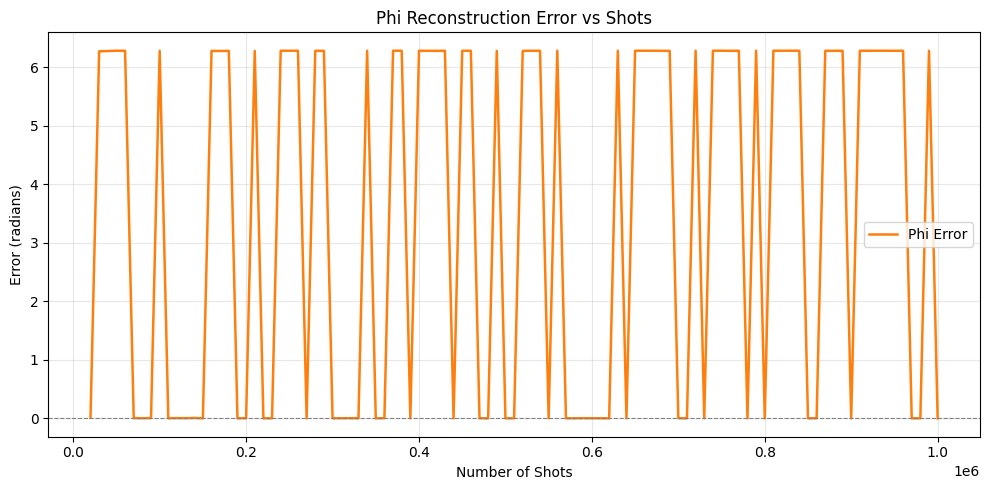

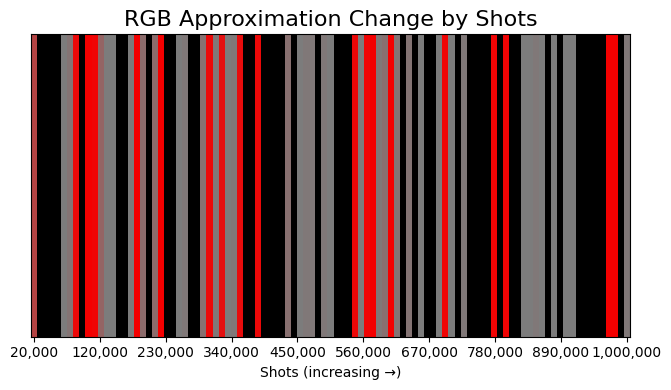

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# ============================
# 1️⃣ 실험 설정
# ============================
theta_ground = 1.53339641425216  # 기준 θ
phi_ground = 0.0                 # 기준 φ
shots_list = np.arange(20000, 1010000, 10000) # 10k ~ 300k

aer_sim = AerSimulator(method='statevector')

# LUT 파일 (RGB 변환용)
df = pd.read_csv("64/64 RGB coords_with_bounds.csv")

# 결과 저장용 리스트
theta_prime_per_shots = []
phi_prime_per_shots = []
theta_error_per_shots = []
phi_error_per_shots = []
approxed_rgb_per_shots = []

# ============================
# 2️⃣ 회로 정의 함수
# ============================
def make_measurement_circuits(theta, phi):
    """Initialize |ψ> = cos(θ/2)|0> + e^{iφ}sin(θ/2)|1> and prepare for X/Y/Z measurement"""
    qc_init = QuantumCircuit(1)
    qc_init.initialize([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)], 0)

    # Z-basis
    qc_z = qc_init.copy()
    qc_z.measure_all()

    # X-basis
    qc_x = qc_init.copy()
    qc_x.h(0)
    qc_x.measure_all()

    # Y-basis
    qc_y = qc_init.copy()
    qc_y.sdg(0)
    qc_y.h(0)
    qc_y.measure_all()
    return qc_x, qc_y, qc_z

def expectation(counts, shots):
    """⟨Z⟩, ⟨X⟩, ⟨Y⟩ 계산"""
    p0 = counts.get('0', 0) / shots
    p1 = counts.get('1', 0) / shots
    return p0 - p1

# ============================
# 3️⃣ RGB 근사 함수
# ============================
def approximate_rgb_fix(theta, phi, lut_df):
    theta_lower = lut_df["theta_lower"].values
    theta_upper = lut_df["theta_upper"].values
    phi_left    = lut_df["phi_left"].values
    phi_right   = lut_df["phi_right"].values
    r = lut_df["r"].values
    g = lut_df["g"].values
    b = lut_df["b"].values

    cond_theta = (theta_lower <= theta) & (theta <= theta_upper)
    cond_phi = np.where(
        phi_left <= phi_right,
        (phi_left <= phi) & (phi <= phi_right),
        (phi_left <= phi) | (phi <= phi_right)
    )
    cond = cond_theta & cond_phi
    match_idxs = np.where(cond)[0]

    if len(match_idxs) > 0:
        idx = match_idxs[0]
        return np.array([r[idx], g[idx], b[idx]], dtype=np.uint8)
    else:
        return np.array([0, 0, 0], dtype=np.uint8)

# ============================
# 4️⃣ 실험 루프 (shots 증가)
# ============================
for shots in shots_list:
    qc_x, qc_y, qc_z = make_measurement_circuits(theta_ground, phi_ground)

    result_x = aer_sim.run(transpile(qc_x, aer_sim), shots=shots).result()
    result_y = aer_sim.run(transpile(qc_y, aer_sim), shots=shots).result()
    result_z = aer_sim.run(transpile(qc_z, aer_sim), shots=shots).result()

    counts_x = result_x.get_counts()
    counts_y = result_y.get_counts()
    counts_z = result_z.get_counts()

    ex_x = expectation(counts_x, shots)
    ex_y = expectation(counts_y, shots)
    ex_z = expectation(counts_z, shots)

    theta_prime = np.arccos(np.clip(ex_z, -1, 1))
    phi_prime = np.arctan2(ex_y, ex_x)
    if phi_prime < 0:
        phi_prime += 2*np.pi

    theta_error = theta_prime - theta_ground
    phi_error = phi_prime - phi_ground

    theta_prime_per_shots.append(theta_prime)
    phi_prime_per_shots.append(phi_prime)
    theta_error_per_shots.append(theta_error)
    phi_error_per_shots.append(phi_error)

    approx_rgb = approximate_rgb_fix(theta_prime, phi_prime, df)
    approxed_rgb_per_shots.append(approx_rgb)

# ============================
# 5️⃣ 시각화 ① θ, φ 오차
# ============================
plt.figure(figsize=(10, 5))
plt.plot(shots_list, theta_error_per_shots, label='Theta Error', color='tab:blue', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y=0.000791732, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=-0.000791732, color='red', linestyle='--', linewidth=1.5)
plt.text(0, 0.000791732 + 0.001, "y = ±0.000791732", color='red', fontsize=10)
plt.title('Theta Reconstruction Error vs Shots')
plt.xlabel('Number of Shots')
plt.ylabel('Error (radians)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(shots_list, phi_error_per_shots, label='Phi Error', color='tab:orange', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

plt.title('Phi Reconstruction Error vs Shots')
plt.xlabel('Number of Shots')
plt.ylabel('Error (radians)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================
# 6️⃣ 시각화 ② RGB 근사 변화
# ============================
rgb_arr = np.array(approxed_rgb_per_shots, dtype=np.uint8)
num_samples = len(rgb_arr)

fig, ax = plt.subplots(figsize=(60, 4))
rgb_bar = np.zeros((50, num_samples, 3), dtype=np.uint8)
for i in range(num_samples):
    rgb_bar[:, i, :] = rgb_arr[i]

ax.imshow(rgb_bar)
ax.set_title("RGB Approximation Change by Shots", fontsize=16)
ax.set_xlabel("Shots (increasing →)")
ax.set_yticks([])
ax.set_xticks(np.linspace(0, num_samples-1, 10))
ax.set_xticklabels([f"{shots_list[int(x)]:,}" for x in np.linspace(0, num_samples-1, 10).astype(int)])
plt.tight_layout()
plt.show()


In [144]:
from qiskit_aer import AerSimulator

df = pd.read_csv("64/64 RGB coords_with_bounds.csv")
aer_sim = AerSimulator(method='matrix_product_state')  # 빠르고 정확
#aer_sim = Aer.get_backend('aer_simulator')

theta_ground = img_theta[0][0]
phi_ground = img_phi[0][0]

theta_prime_per_shots = []
phi_prime_per_shots = []
approxed_rgb_per_shots = []

theta_error_per_shots = []
phi_error_per_shots = []

c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'anxilia')
cr = ClassicalRegister(c.size+p.size, "cl")

for i in range(99):
    qc_image = QuantumCircuit(c,p,cr)
    qc_image.h(p)
    qc_image.cry(theta_ground,p,c)
    qc_image.x(p)
    qc_image.cry(phi_ground*0.5,p,c)
    qc_image.x(p)
    qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))
    t_qc_image = transpile(qc_image, aer_sim, optimization_level=3)
    result = aer_sim.run(t_qc_image, shots= 20000 + 10000 * i).result()
    counts = result.get_counts()

    theta_prime, phi_prime = compute_theta_phi(counts)
    theta_error = theta_prime - theta_ground
    phi_error = phi_prime - phi_ground
    approx_rgb = approximate_rgb_fix(theta_prime, phi_prime, df)
    theta_prime_per_shots.append(theta_prime)
    phi_prime_per_shots.append(phi_prime)
    theta_error_per_shots.append(theta_error)
    phi_error_per_shots.append(phi_error)
    approxed_rgb_per_shots.append(approx_rgb)

KeyboardInterrupt: 

In [ ]:
# shots 증가량
shots_list = [20000 + 10000 * i for i in range(99)]

# ===== ① DataFrame 표로 정리 =====
df_results = pd.DataFrame({
    'shots': shots_list,
    'theta_prime': theta_prime_per_shots,
    'phi_prime': phi_prime_per_shots,
    'theta_error': theta_error_per_shots,
    'phi_error': phi_error_per_shots
})
print(df_results.head())
print(f"\n총 {len(df_results)}회 측정 결과 정리 완료")

# ===== ② θ, φ 에러 시각화 =====
plt.figure(figsize=(10, 5))
plt.plot(df_results['shots'], df_results['theta_error'], label='Theta Error', color='tab:blue', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y= 0.001780948, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y= -0.001780948, color='red', linestyle='--', linewidth=1.5)
plt.title('Reconstruction Error vs Shots (Single Pixel)')
plt.xlabel('Number of Shots')
plt.ylabel('Error (radian)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== ③ RGB 근사 색상 변화 시각화 =====
# approxed_rgb_per_shots: [(r,g,b), (r,g,b), ...]
rgb_arr = np.array(approxed_rgb_per_shots, dtype=np.uint8)
num_samples = len(rgb_arr)

fig, ax = plt.subplots(figsize=(60, 4))
# RGB를 1xN 컬러바 형태로 표시
rgb_bar = np.zeros((50, num_samples, 3), dtype=np.uint8)
for i in range(num_samples):
    rgb_bar[:, i, :] = rgb_arr[i]
ax.imshow(rgb_bar)
ax.set_title("RGB Approximation Change by Shots")
ax.set_xlabel("Shots (increasing →)")
ax.set_yticks([])
ax.set_xticks(np.linspace(0, num_samples-1, 10))
ax.set_xticklabels([f"{shots_list[int(x)]:,}" for x in np.linspace(0, num_samples-1, 10).astype(int)])
plt.tight_layout()
plt.show()

# ===== ④ 요약 출력 =====
best_idx = np.argmin(np.abs(df_results['theta_error']))  # θ 에러 최소일 때
print(f"가장 정확한 복원 (θ 기준): shots={shots_list[best_idx]}, "
      f"theta_error={df_results['theta_error'][best_idx]:.6f}, "
      f"phi_error={df_results['phi_error'][best_idx]:.6f}, "
      f"approx RGB={approxed_rgb_per_shots[best_idx]}")

In [ ]:
# shots 증가량
shots_list = [20000 + 10000 * i for i in range(99)]

# ===== ① DataFrame 표로 정리 =====
df_results = pd.DataFrame({
    'shots': shots_list,
    'theta_prime': theta_prime_per_shots,
    'phi_prime': phi_prime_per_shots,
    'theta_error': theta_error_per_shots,
    'phi_error': phi_error_per_shots
})
print(df_results.head())
print(f"\n총 {len(df_results)}회 측정 결과 정리 완료")

# ===== ② θ, φ 에러 시각화 =====
plt.figure(figsize=(10, 5))
plt.plot(df_results['shots'], df_results['phi_error'], label='Phi Error', color='tab:orange', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y= 0.523598776, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y= -0.523598776, color='red', linestyle='--', linewidth=1.5)
plt.title('Reconstruction Error vs Shots (Single Pixel)')
plt.xlabel('Number of Shots')
plt.ylabel('Error (radian)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

   shots  theta_prime  phi_prime  theta_error  phi_error
0  20000     2.682569   1.030984     0.002241  -0.016214
1  30000     2.676016   1.032505    -0.004311  -0.014693
2  40000     2.693105   1.058618     0.012778   0.011420
3  50000     2.661278   1.044845    -0.019050  -0.002353
4  60000     2.680317   1.063559    -0.000010   0.016362

총 99회 측정 결과 정리 완료


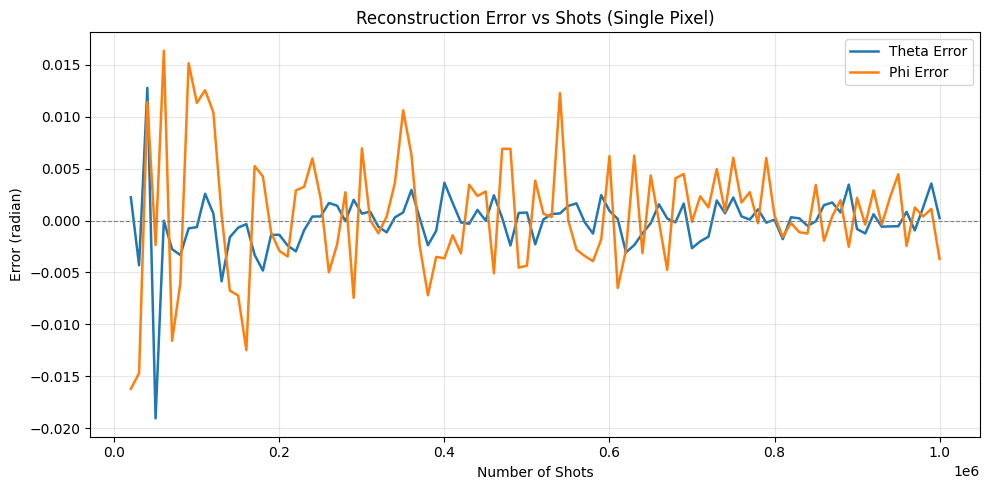

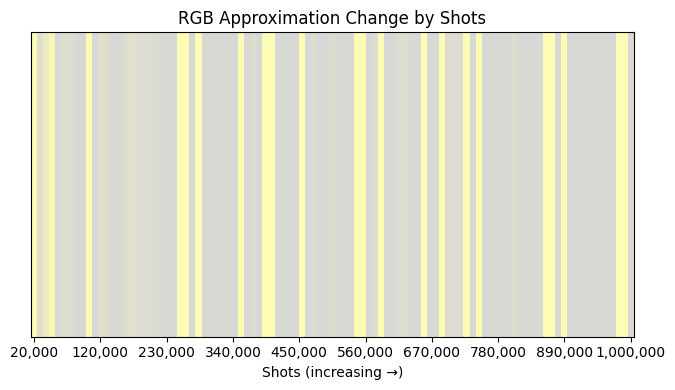

가장 정확한 복원 (θ 기준): shots=450000, theta_error=-0.000004, phi_error=0.002804, approx RGB=[[216 216 212]]


In [114]:
# shots 증가량
shots_list = [20000 + 10000 * i for i in range(99)]

# ===== ① DataFrame 표로 정리 =====
df_results = pd.DataFrame({
    'shots': shots_list,
    'theta_prime': theta_prime_per_shots,
    'phi_prime': phi_prime_per_shots,
    'theta_error': theta_error_per_shots,
    'phi_error': phi_error_per_shots
})
print(df_results.head())
print(f"\n총 {len(df_results)}회 측정 결과 정리 완료")

# ===== ② θ, φ 에러 시각화 =====
plt.figure(figsize=(10, 5))
plt.plot(df_results['shots'], df_results['theta_error'], label='Theta Error', color='tab:blue', linewidth=1.8)
plt.plot(df_results['shots'], df_results['phi_error'], label='Phi Error', color='tab:orange', linewidth=1.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title('Reconstruction Error vs Shots (Single Pixel)')
plt.xlabel('Number of Shots')
plt.ylabel('Error (radian)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== ③ RGB 근사 색상 변화 시각화 =====
# approxed_rgb_per_shots: [(r,g,b), (r,g,b), ...]
rgb_arr = np.array(approxed_rgb_per_shots, dtype=np.uint8)
num_samples = len(rgb_arr)

fig, ax = plt.subplots(figsize=(60, 4))
# RGB를 1xN 컬러바 형태로 표시
rgb_bar = np.zeros((50, num_samples, 3), dtype=np.uint8)
for i in range(num_samples):
    rgb_bar[:, i, :] = rgb_arr[i]
ax.imshow(rgb_bar)
ax.set_title("RGB Approximation Change by Shots")
ax.set_xlabel("Shots (increasing →)")
ax.set_yticks([])
ax.set_xticks(np.linspace(0, num_samples-1, 10))
ax.set_xticklabels([f"{shots_list[int(x)]:,}" for x in np.linspace(0, num_samples-1, 10).astype(int)])

plt.tight_layout()
plt.show()

# ===== ④ 요약 출력 =====
best_idx = np.argmin(np.abs(df_results['theta_error']))  # θ 에러 최소일 때
print(f"가장 정확한 복원 (θ 기준): shots={shots_list[best_idx]}, "
      f"theta_error={df_results['theta_error'][best_idx]:.6f}, "
      f"phi_error={df_results['phi_error'][best_idx]:.6f}, "
      f"approx RGB={approxed_rgb_per_shots[best_idx]}")

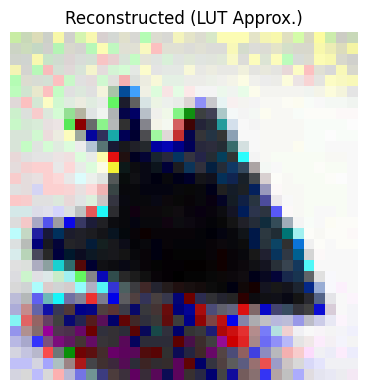

{'mse': 675.8385416666666, 'psnr': 19.83237405811589, 'ssim': 0.8488932183738934}


In [20]:
df = pd.read_csv("64/64_RGB_coords_with_bounds.csv")

# arr_theta_recon, arr_phi_recon이 각각 (N,) numpy array라고 가정
approx_rgb = approximate_rgb(arr_theta_recon, arr_phi_recon, df)
# approx_rgb: shape (N, 3), 각 행이 근사된 (r, g, b), Here, approx_rgb: shape (1024, 3)

# img_original: shape (32, 32, 3) — 정수형(0~255)여야 함

# 복원 이미지 재구성
img_reconstructed = approx_rgb.reshape(32, 32, 3).astype(np.uint8)

# 예시로, img_original이 이미 (32, 32, 3)이고 np.uint8이라고 가정
# 만약 약간의 전처리가 필요할 시 추가

# 시각화 (가로 2개 subplot)
plt.figure(figsize=(8, 4))
plt.imshow(img_reconstructed)
plt.title("Reconstructed (LUT Approx.)")
plt.axis('off')
plt.tight_layout()
plt.show()

img1 = quantized_class_images[0][0]
img2 = img_reconstructed
metrics = compute_metrics(img1, img2)  # data_range 자동 추정
print(metrics)  # {'mse': ..., 'psnr': ..., 'ssim': ...}

Coverage: 91.185% | Overlap cells: 7626 (11.703%) | Gaps: 5744 (8.815%)
[저장] 겹침 셀 샘플 → overlap_cells_with_rgbs.csv (행수=8262)
[저장] gap 셀 좌표 → gap_cells.csv (행수=5744)


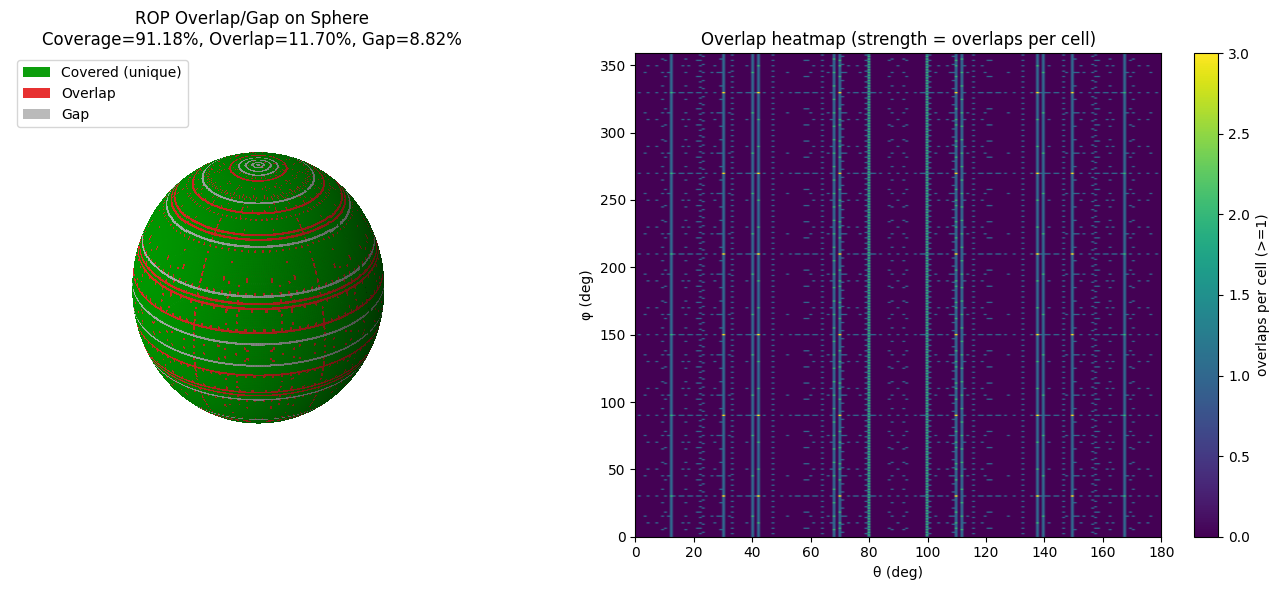

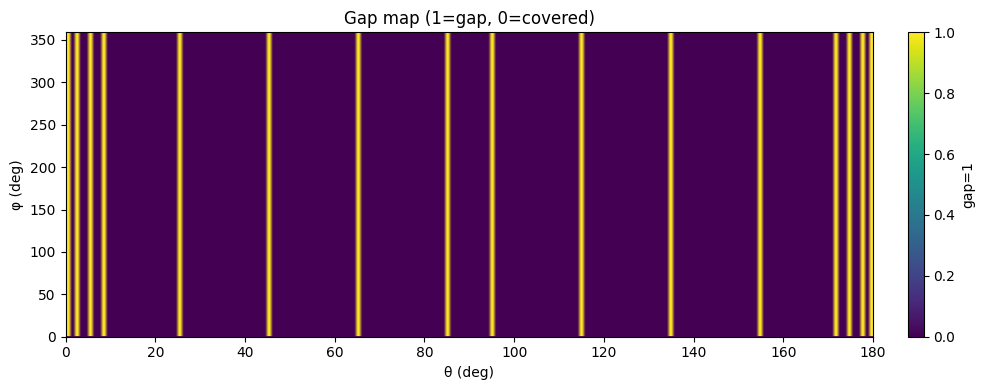

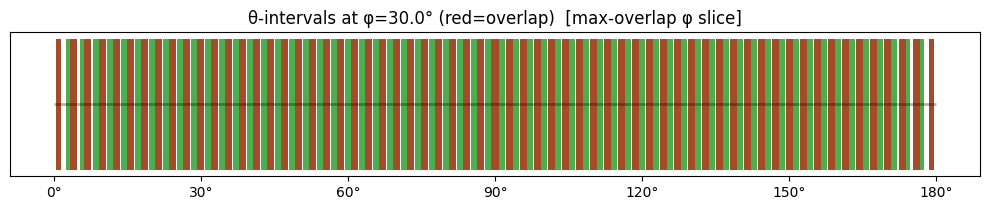

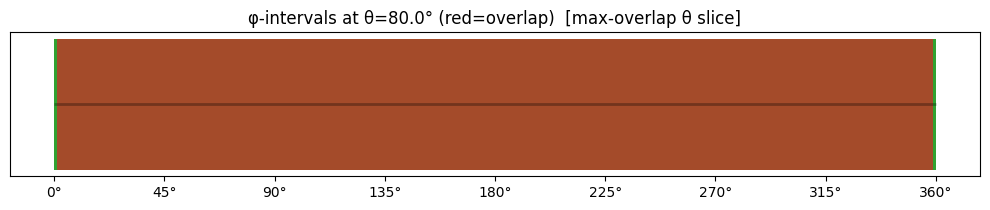

[참고] 갭 최대 φ=1.0°, θ=0.0°  (상세는 Gap map 참조)


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================
# 설정
# =========================
CSV_PATH = r"64/64_RGB_coords_renew_with_bounds.csv"

# 분석/시각화 해상도 (필요시 낮추거나 높이세요)
PHI_DEG_STEP   = 1.0    # φ=0..359
THETA_DEG_STEP = 1.0    # θ=0..180

# 허용오차
TOL_PHI   = 1e-9
TOL_THETA = 1e-9

# 저장 옵션
EXPORT_CONFLICTS = True
CONFLICTS_CSV = "overlap_cells_with_rgbs.csv"
GAPS_CSV = "gap_cells.csv"

PI, TWOPI = np.pi, 2*np.pi
deg = np.deg2rad
rad = np.rad2deg

# =========================
# 유틸
# =========================
def ang_norm(x):
    return (x % TWOPI + TWOPI) % TWOPI

def phi_in_interval(phi, L, R, tol=TOL_PHI):
    """φ ∈ [L,R] ? (래핑 처리)"""
    a = ang_norm(phi); L = ang_norm(L); R = ang_norm(R)
    if L <= R:
        return (a + tol >= L) and (a <= R + tol)
    else:
        return (a + tol >= L) or (a <= R + tol)

def split_wrap_interval(L, R):
    """원형 [L,R]을 선형 구간 리스트로(래핑이면 2조각)"""
    L = ang_norm(L); R = ang_norm(R)
    if L <= R:
        return [(L, R)]
    else:
        return [(L, TWOPI), (0.0, R)]

def merge_linear_intervals(intervals, tol=1e-9, period=TWOPI):
    """[0,period)에서 구간 병합과 갭 계산"""
    if not intervals:
        return [], [(0.0, period)]
    xs = [(max(0.0, L), min(period, R)) for (L,R) in intervals if R > 0 and L < period]
    if not xs:
        return [], [(0.0, period)]
    xs.sort(key=lambda x: x[0])
    merged = []
    curL, curR = xs[0]
    for L,R in xs[1:]:
        if L <= curR + tol:
            curR = max(curR, R)
        else:
            merged.append((curL, curR))
            curL, curR = L, R
    merged.append((curL, curR))

    gaps = []
    if merged[0][0] > tol:
        gaps.append((0.0, merged[0][0]))
    for (aL,aR),(bL,bR) in zip(merged, merged[1:]):
        if bL - aR > tol:
            gaps.append((aR, bL))
    if (period - merged[-1][1]) > tol:
        gaps.append((merged[-1][1], period))
    return merged, gaps

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH)
need = ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"컬럼 누락: {miss}")
for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)
for c in ['r','g','b']:
    df[c] = df[c].astype(int)

# =========================
# 격자 구성
# =========================
phi_deg_vals   = np.arange(0.0, 360.0, PHI_DEG_STEP)   # 0..359
theta_deg_vals = np.arange(0.0, 181.0, THETA_DEG_STEP) # 0..180
phi_vals   = deg(phi_deg_vals)
theta_vals = deg(theta_deg_vals)

H, W = len(phi_vals), len(theta_vals)

cover_count = np.zeros((H, W), dtype=np.int16)     # 셀을 덮은 구간 수
first_rgb   = np.full((H, W, 3), -1, dtype=np.int16)
conf_list   = []   # (phi_deg, theta_deg, rgb_first, rgb_second)
gap_list    = []   # (phi_deg, theta_deg)

# =========================
# 래스터라이즈 & 겹침 기록
# =========================
for _, row in df.iterrows():
    L = float(row['phi_left']); R = float(row['phi_right'])
    t0 = float(row['theta_lower']); t1 = float(row['theta_upper'])
    r,g,b = int(row['r']), int(row['g']), int(row['b'])

    th_idx = np.where((theta_vals >= t0 - TOL_THETA) & (theta_vals <= t1 + TOL_THETA))[0]
    if th_idx.size == 0:
        continue

    # φ: 래핑 대응
    stripes = split_wrap_interval(L, R)
    for (l, r_) in stripes:
        phi_idx = np.where((phi_vals >= l - TOL_PHI) & (phi_vals <= r_ + TOL_PHI))[0]
        for i in phi_idx:
            for j in th_idx:
                if cover_count[i, j] == 0:
                    cover_count[i, j] = 1
                    first_rgb[i, j, :] = (r,g,b)
                else:
                    cover_count[i, j] += 1
                    prev = tuple(first_rgb[i, j, :])
                    now  = (r,g,b)
                    if prev != now:
                        conf_list.append((float(phi_deg_vals[i]), float(theta_deg_vals[j]), prev, now))

covered = cover_count > 0
overlap_mask = cover_count > 1
gap_mask = cover_count == 0

global_coverage = covered.mean() * 100.0
overlap_ratio = overlap_mask.mean() * 100.0
gap_ratio = gap_mask.mean() * 100.0

print(f"Coverage: {global_coverage:.3f}% | Overlap cells: {overlap_mask.sum()} ({overlap_ratio:.3f}%) | Gaps: {gap_mask.sum()} ({gap_ratio:.3f}%)")

# 갭 셀 모으기(원하면 저장)
if EXPORT_CONFLICTS:
    if len(conf_list):
        pd.DataFrame(conf_list, columns=["phi_deg","theta_deg","rgb_first","rgb_second"]).to_csv(CONFLICTS_CSV, index=False)
        print(f"[저장] 겹침 셀 샘플 → {CONFLICTS_CSV} (행수={len(conf_list)})")
    # gap 좌표
    gphi, gtheta = np.where(gap_mask)
    if gphi.size:
        gap_df = pd.DataFrame({
            "phi_deg": phi_deg_vals[gphi],
            "theta_deg": theta_deg_vals[gtheta],
        })
        gap_df.to_csv(GAPS_CSV, index=False)
        print(f"[저장] gap 셀 좌표 → {GAPS_CSV} (행수={len(gap_df)})")

# =========================
# 3D 구 표면 시각화
# =========================
PHI_grid, THETA_grid = np.meshgrid(phi_vals, theta_vals, indexing='ij')
X = np.sin(THETA_grid) * np.cos(PHI_grid)
Y = np.sin(THETA_grid) * np.sin(PHI_grid)
Z = np.cos(THETA_grid)

rgba = np.zeros((H, W, 4))
rgba[..., :] = [0.7, 0.7, 0.7, 0.9]          # 기본: 미커버 회색
rgba[covered, :] = [0.0, 0.6, 0.0, 0.95]     # 커버 초록
rgba[overlap_mask, :] = [0.9, 0.15, 0.15, 0.95]  # 겹침 빨강

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=rgba, rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_axis_off()
ax.set_box_aspect([1,1,1])
ax.set_title(f"ROP Overlap/Gap on Sphere\nCoverage={global_coverage:.2f}%, Overlap={overlap_ratio:.2f}%, Gap={gap_ratio:.2f}%")
ax.legend(handles=[
    Patch(facecolor=(0.0, 0.6, 0.0, 0.95), label="Covered (unique)"),
    Patch(facecolor=(0.9, 0.15, 0.15, 0.95), label="Overlap"),
    Patch(facecolor=(0.7, 0.7, 0.7, 0.9),   label="Gap")
], loc='upper left')

# =========================
# 2D 히트맵 (겹침 강도 & 갭)
# =========================
ax2 = fig.add_subplot(122)
overlap_strength = np.maximum(cover_count - 1, 0)
im = ax2.imshow(
    overlap_strength,
    origin='lower',
    aspect='auto',
    extent=[theta_deg_vals.min(), theta_deg_vals.max(), phi_deg_vals.min(), phi_deg_vals.max()]
)
ax2.set_xlabel("θ (deg)")
ax2.set_ylabel("φ (deg)")
ax2.set_title("Overlap heatmap (strength = overlaps per cell)")
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label("overlaps per cell (>=1)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
im2 = plt.imshow(
    gap_mask.astype(float),
    origin='lower',
    aspect='auto',
    extent=[theta_deg_vals.min(), theta_deg_vals.max(), phi_deg_vals.min(), phi_deg_vals.max()]
)
plt.xlabel("θ (deg)")
plt.ylabel("φ (deg)")
plt.title("Gap map (1=gap, 0=covered)")
plt.colorbar(im2, fraction=0.046, pad=0.04, label="gap=1")
plt.tight_layout()
plt.show()

# =========================
# 밴드 상세 플롯 (가장 문제가 큰 단면 자동 선택)
# =========================
# φ별 겹침 합 / θ별 겹침 합
phi_overlap_sum   = overlap_strength.sum(axis=1)  # 각 φ 행의 합
theta_overlap_sum = overlap_strength.sum(axis=0)  # 각 θ 열의 합
phi_gap_sum       = gap_mask.sum(axis=1)
theta_gap_sum     = gap_mask.sum(axis=0)

def plot_phi_slice(df, phi_deg_pick, title_suffix=""):
    """해당 φ에서 θ-구간 막대 + 겹침 강조"""
    phi = deg(phi_deg_pick)
    mask = df.apply(lambda r: phi_in_interval(phi, r['phi_left'], r['phi_right'], TOL_PHI), axis=1)
    sub = df.loc[mask, ['theta_lower','theta_upper','r','g','b']].copy()
    sub = sub.sort_values('theta_lower').reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, 2.2))
    ax.hlines(0.5, 0, PI, color='black', alpha=0.3, linewidth=2)
    for k, row in sub.iterrows():
        lo, hi = row['theta_lower'], row['theta_upper']
        ax.broken_barh([(lo, hi-lo)], (0.35, 0.30), facecolors='tab:green', alpha=0.85)
    # 인접 겹침 강조
    for (a,b) in zip(sub.itertuples(), sub.iloc[1:].itertuples()):
        ov = a.theta_upper - b.theta_lower
        if ov > TOL_THETA:
            ax.broken_barh([(b.theta_lower, ov)], (0.35, 0.30), facecolors='tab:red', alpha=0.7)
    xt = np.linspace(0, PI, 7)
    ax.set_xticks(xt); ax.set_xticklabels([f"{np.degrees(x):.0f}°" for x in xt])
    ax.set_yticks([])
    ax.set_title(f"θ-intervals at φ={phi_deg_pick:.1f}° (red=overlap){title_suffix}")
    plt.tight_layout(); plt.show()

def plot_theta_slice(df, theta_deg_pick, title_suffix=""):
    """해당 θ에서 φ-구간 막대 + 겹침/래핑 겹침 강조"""
    th = deg(theta_deg_pick)
    mask = (df['theta_lower'] - TOL_THETA <= th) & (th <= df['theta_upper'] + TOL_THETA)
    sub = df.loc[mask, ['phi_left','phi_right','r','g','b']].copy()
    if sub.empty:
        print(f"[θ={theta_deg_pick}°] no intervals")
        return
    sub['phi_left']  = sub['phi_left'].map(ang_norm)
    sub['phi_right'] = sub['phi_right'].map(ang_norm)
    sub = sub.sort_values('phi_left').reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, 2.2))
    ax.hlines(0.5, 0, TWOPI, color='black', alpha=0.3, linewidth=2)
    for k, row in sub.iterrows():
        L, R = row['phi_left'], row['phi_right']
        if L <= R:
            ax.broken_barh([(L, R-L)], (0.35, 0.30), facecolors='tab:green', alpha=0.85)
        else:
            ax.broken_barh([(L, TWOPI-L)], (0.35, 0.30), facecolors='tab:green', alpha=0.85)
            ax.broken_barh([(0.0, R)],     (0.35, 0.30), facecolors='tab:green', alpha=0.85)
    # 내부 겹침
    for (a,b) in zip(sub.itertuples(), sub.iloc[1:].itertuples()):
        ov = a.phi_right - b.phi_left
        if ov > TOL_PHI:
            ax.broken_barh([(b.phi_left, ov)], (0.35, 0.30), facecolors='tab:red', alpha=0.7)
    # 래핑 겹침(끝↔처음)
    if len(sub) >= 2:
        Rlast = sub.iloc[-1]['phi_right']
        Lfirst= sub.iloc[0]['phi_left']
        ov_len = (Rlast - Lfirst) % TWOPI
        gap_len= (Lfirst - Rlast) % TWOPI
        if ov_len > TOL_PHI and ov_len < gap_len:
            ax.broken_barh([(Rlast-ov_len, ov_len)], (0.35, 0.30), facecolors='tab:red', alpha=0.7)

    xt = np.linspace(0, TWOPI, 9)
    ax.set_xticks(xt); ax.set_xticklabels([f"{np.degrees(x):.0f}°" for x in xt])
    ax.set_yticks([])
    ax.set_title(f"φ-intervals at θ={theta_deg_pick:.1f}° (red=overlap){title_suffix}")
    plt.tight_layout(); plt.show()

# 겹침이 많은 단면 & 갭이 많은 단면 각각 표시
if overlap_mask.any():
    phi_pick_ov = float(phi_deg_vals[np.argmax(phi_overlap_sum)])
    th_pick_ov  = float(theta_deg_vals[np.argmax(theta_overlap_sum)])
    plot_phi_slice(df, phi_pick_ov, title_suffix="  [max-overlap φ slice]")
    plot_theta_slice(df, th_pick_ov, title_suffix="  [max-overlap θ slice]")

if gap_mask.any():
    phi_pick_gap = float(phi_deg_vals[np.argmax(phi_gap_sum)])
    th_pick_gap  = float(theta_deg_vals[np.argmax(theta_gap_sum)])
    # 갭 밴드는 커버 세그먼트가 적거나 없으므로, 밴드 자체는 히트맵에서 확인하는 것을 권장
    print(f"[참고] 갭 최대 φ={phi_pick_gap:.1f}°, θ={th_pick_gap:.1f}°  (상세는 Gap map 참조)")

In [57]:
import pandas as pd
import numpy as np

# CSV 파일 로드
CSV_PATH = r"64/64_RGB_coords_renew_with_bounds.csv"
df = pd.read_csv(CSV_PATH)

# 필요한 컬럼만 확인
need = ['r','g','b','theta_lower','theta_upper']
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"컬럼 누락: {miss}")

# θ 기준 정렬 (phi 무시)
df_sorted = df.sort_values(by='theta_lower', ascending=True).reset_index(drop=True)

# 결과 저장 리스트
gap_records = []

# 인접 RGB 구간 비교
for i in range(len(df_sorted) - 1):
    cur = df_sorted.iloc[i]
    nxt = df_sorted.iloc[i + 1]

    # 현재 구간의 upper와 다음 구간의 lower 비교
    gap = nxt['theta_lower'] - cur['theta_upper']
    if gap > 1e-6:  # 작은 오차는 무시
        gap_records.append({
            'gap_index': i,
            'gap_size(rad)': gap,
            'gap_size(deg)': np.degrees(gap),
            'theta_upper_prev': cur['theta_upper'],
            'theta_lower_next': nxt['theta_lower'],
            'RGB_prev': (int(cur['r']), int(cur['g']), int(cur['b'])),
            'RGB_next': (int(nxt['r']), int(nxt['g']), int(nxt['b']))
        })

# 결과 DataFrame
gap_df = pd.DataFrame(gap_records)
print(f"총 감지된 θ-gap 밴드 수: {len(gap_df)}")
if len(gap_df):
    print(gap_df.head(10))

# CSV로 저장
gap_df.to_csv("theta_gap_rgb_pairs.csv", index=False)
print("[저장 완료] gap 원인 RGB 쌍 → theta_gap_rgb_pairs.csv")


총 감지된 θ-gap 밴드 수: 0
[저장 완료] gap 원인 RGB 쌍 → theta_gap_rgb_pairs.csv


In [58]:
large_gap_df = gap_df[gap_df['gap_size(deg)'] > 0.5]
print(f"θ gap이 0.5° 이상인 RGB 쌍 수: {len(large_gap_df)}")
print(large_gap_df[['gap_size(deg)','RGB_prev','RGB_next']].head())


KeyError: 'gap_size(deg)'

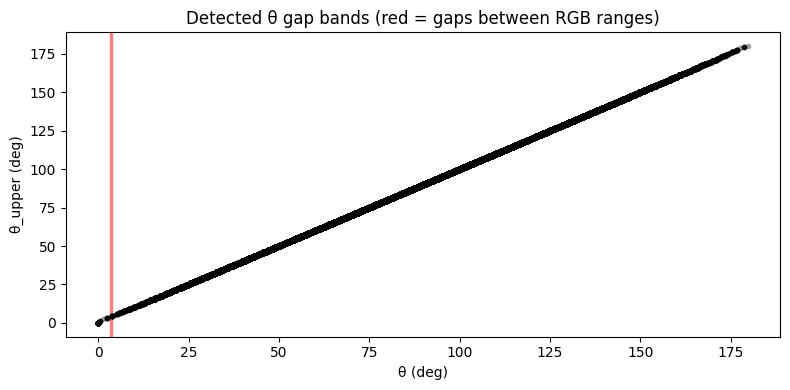

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(np.degrees(df_sorted['theta_lower']), np.degrees(df_sorted['theta_upper']), 'k.', alpha=0.3)
for _, row in large_gap_df.iterrows():
    plt.axvspan(np.degrees(row['theta_upper_prev']),
                np.degrees(row['theta_lower_next']),
                color='red', alpha=0.4)
plt.xlabel("θ (deg)")
plt.ylabel("θ_upper (deg)")
plt.title("Detected θ gap bands (red = gaps between RGB ranges)")
plt.tight_layout()
plt.show()


Coverage: 91.185% | Overlap cells: 7626 (11.703%) | Gaps: 5744 (8.815%)
[저장] 겹침 셀 샘플 → overlap_cells_with_rgbs.csv (행수=8262)
[저장] gap 셀 좌표 → gap_cells.csv (행수=5744)


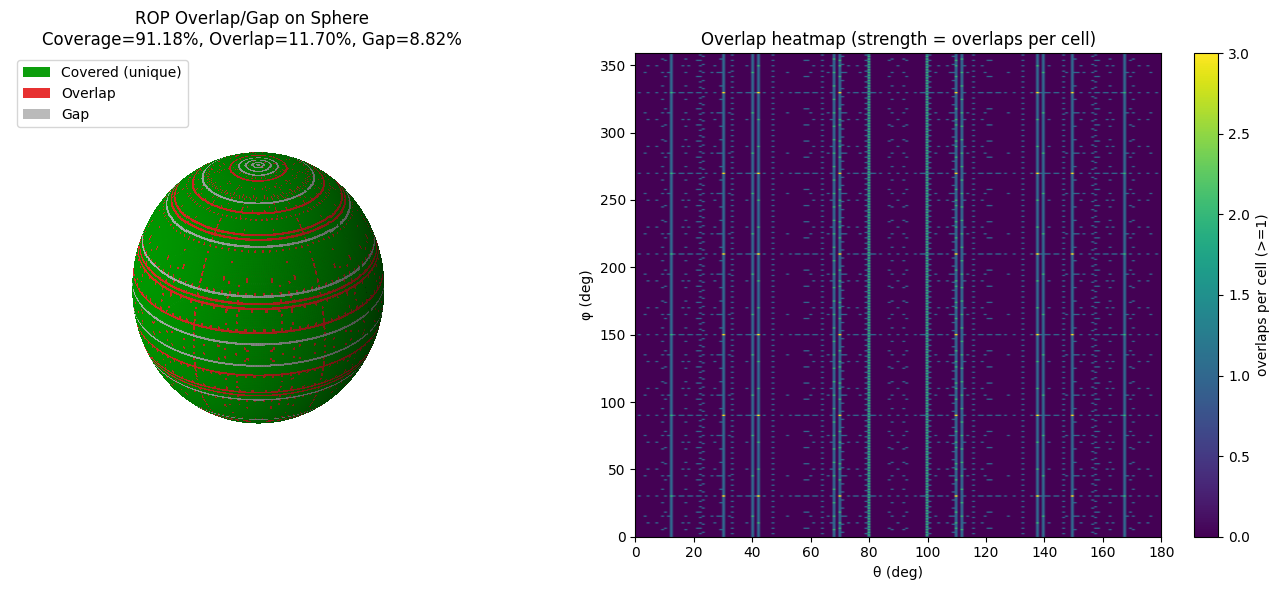

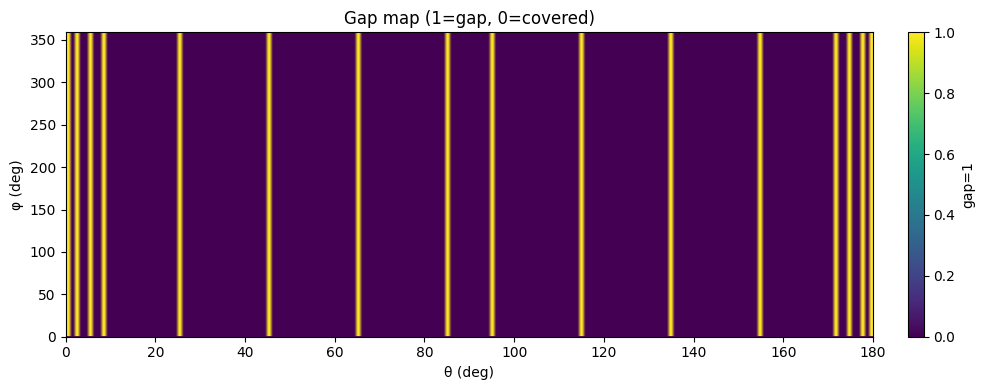

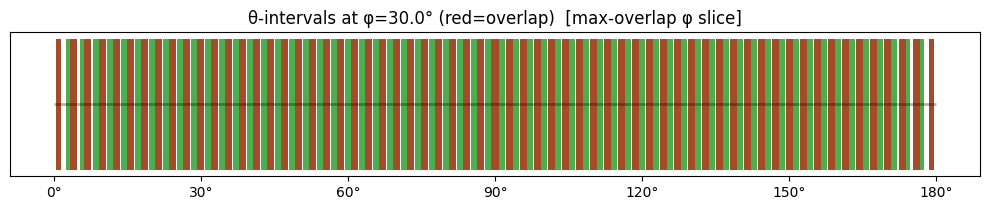

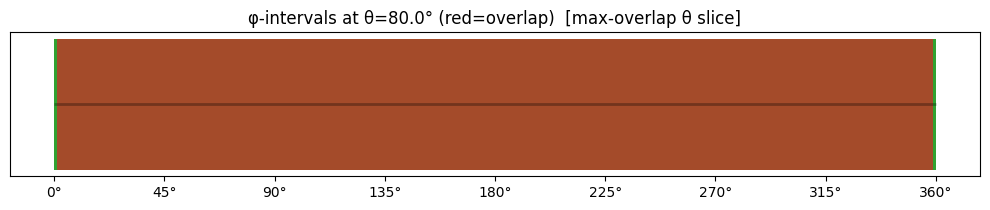

[참고] 갭 최대 φ=1.0°, θ=0.0°  (상세는 Gap map 참조)


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================
# 설정
# =========================
CSV_PATH = r"64/64_RGB_coords_with_bounds.csv"

# 분석/시각화 해상도 (필요시 낮추거나 높이세요)
PHI_DEG_STEP   = 1.0    # φ=0..359
THETA_DEG_STEP = 1.0    # θ=0..180

# 허용오차
TOL_PHI   = 1e-9
TOL_THETA = 1e-9

# 저장 옵션
EXPORT_CONFLICTS = True
CONFLICTS_CSV = "overlap_cells_with_rgbs.csv"
GAPS_CSV = "gap_cells.csv"

PI, TWOPI = np.pi, 2*np.pi
deg = np.deg2rad
rad = np.rad2deg

# =========================
# 유틸
# =========================
def ang_norm(x):
    return (x % TWOPI + TWOPI) % TWOPI

def phi_in_interval(phi, L, R, tol=TOL_PHI):
    """φ ∈ [L,R] ? (래핑 처리)"""
    a = ang_norm(phi); L = ang_norm(L); R = ang_norm(R)
    if L <= R:
        return (a + tol >= L) and (a <= R + tol)
    else:
        return (a + tol >= L) or (a <= R + tol)

def split_wrap_interval(L, R):
    """원형 [L,R]을 선형 구간 리스트로(래핑이면 2조각)"""
    L = ang_norm(L); R = ang_norm(R)
    if L <= R:
        return [(L, R)]
    else:
        return [(L, TWOPI), (0.0, R)]

def merge_linear_intervals(intervals, tol=1e-9, period=TWOPI):
    """[0,period)에서 구간 병합과 갭 계산"""
    if not intervals:
        return [], [(0.0, period)]
    xs = [(max(0.0, L), min(period, R)) for (L,R) in intervals if R > 0 and L < period]
    if not xs:
        return [], [(0.0, period)]
    xs.sort(key=lambda x: x[0])
    merged = []
    curL, curR = xs[0]
    for L,R in xs[1:]:
        if L <= curR + tol:
            curR = max(curR, R)
        else:
            merged.append((curL, curR))
            curL, curR = L, R
    merged.append((curL, curR))

    gaps = []
    if merged[0][0] > tol:
        gaps.append((0.0, merged[0][0]))
    for (aL,aR),(bL,bR) in zip(merged, merged[1:]):
        if bL - aR > tol:
            gaps.append((aR, bL))
    if (period - merged[-1][1]) > tol:
        gaps.append((merged[-1][1], period))
    return merged, gaps

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH)
need = ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"컬럼 누락: {miss}")
for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)
for c in ['r','g','b']:
    df[c] = df[c].astype(int)

# =========================
# 격자 구성
# =========================
phi_deg_vals   = np.arange(0.0, 360.0, PHI_DEG_STEP)   # 0..359
theta_deg_vals = np.arange(0.0, 181.0, THETA_DEG_STEP) # 0..180
phi_vals   = deg(phi_deg_vals)
theta_vals = deg(theta_deg_vals)

H, W = len(phi_vals), len(theta_vals)

cover_count = np.zeros((H, W), dtype=np.int16)     # 셀을 덮은 구간 수
first_rgb   = np.full((H, W, 3), -1, dtype=np.int16)
conf_list   = []   # (phi_deg, theta_deg, rgb_first, rgb_second)
gap_list    = []   # (phi_deg, theta_deg)

# =========================
# 래스터라이즈 & 겹침 기록
# =========================
for _, row in df.iterrows():
    L = float(row['phi_left']); R = float(row['phi_right'])
    t0 = float(row['theta_lower']); t1 = float(row['theta_upper'])
    r,g,b = int(row['r']), int(row['g']), int(row['b'])

    th_idx = np.where((theta_vals >= t0 - TOL_THETA) & (theta_vals <= t1 + TOL_THETA))[0]
    if th_idx.size == 0:
        continue

    # φ: 래핑 대응
    stripes = split_wrap_interval(L, R)
    for (l, r_) in stripes:
        phi_idx = np.where((phi_vals >= l - TOL_PHI) & (phi_vals <= r_ + TOL_PHI))[0]
        for i in phi_idx:
            for j in th_idx:
                if cover_count[i, j] == 0:
                    cover_count[i, j] = 1
                    first_rgb[i, j, :] = (r,g,b)
                else:
                    cover_count[i, j] += 1
                    prev = tuple(first_rgb[i, j, :])
                    now  = (r,g,b)
                    if prev != now:
                        conf_list.append((float(phi_deg_vals[i]), float(theta_deg_vals[j]), prev, now))

covered = cover_count > 0
overlap_mask = cover_count > 1
gap_mask = cover_count == 0

global_coverage = covered.mean() * 100.0
overlap_ratio = overlap_mask.mean() * 100.0
gap_ratio = gap_mask.mean() * 100.0

print(f"Coverage: {global_coverage:.3f}% | Overlap cells: {overlap_mask.sum()} ({overlap_ratio:.3f}%) | Gaps: {gap_mask.sum()} ({gap_ratio:.3f}%)")

# 갭 셀 모으기(원하면 저장)
if EXPORT_CONFLICTS:
    if len(conf_list):
        pd.DataFrame(conf_list, columns=["phi_deg","theta_deg","rgb_first","rgb_second"]).to_csv(CONFLICTS_CSV, index=False)
        print(f"[저장] 겹침 셀 샘플 → {CONFLICTS_CSV} (행수={len(conf_list)})")
    # gap 좌표
    gphi, gtheta = np.where(gap_mask)
    if gphi.size:
        gap_df = pd.DataFrame({
            "phi_deg": phi_deg_vals[gphi],
            "theta_deg": theta_deg_vals[gtheta],
        })
        gap_df.to_csv(GAPS_CSV, index=False)
        print(f"[저장] gap 셀 좌표 → {GAPS_CSV} (행수={len(gap_df)})")

# =========================
# 3D 구 표면 시각화
# =========================
PHI_grid, THETA_grid = np.meshgrid(phi_vals, theta_vals, indexing='ij')
X = np.sin(THETA_grid) * np.cos(PHI_grid)
Y = np.sin(THETA_grid) * np.sin(PHI_grid)
Z = np.cos(THETA_grid)

rgba = np.zeros((H, W, 4))
rgba[..., :] = [0.7, 0.7, 0.7, 0.9]          # 기본: 미커버 회색
rgba[covered, :] = [0.0, 0.6, 0.0, 0.95]     # 커버 초록
rgba[overlap_mask, :] = [0.9, 0.15, 0.15, 0.95]  # 겹침 빨강

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=rgba, rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_axis_off()
ax.set_box_aspect([1,1,1])
ax.set_title(f"ROP Overlap/Gap on Sphere\nCoverage={global_coverage:.2f}%, Overlap={overlap_ratio:.2f}%, Gap={gap_ratio:.2f}%")
ax.legend(handles=[
    Patch(facecolor=(0.0, 0.6, 0.0, 0.95), label="Covered (unique)"),
    Patch(facecolor=(0.9, 0.15, 0.15, 0.95), label="Overlap"),
    Patch(facecolor=(0.7, 0.7, 0.7, 0.9),   label="Gap")
], loc='upper left')

# =========================
# 2D 히트맵 (겹침 강도 & 갭)
# =========================
ax2 = fig.add_subplot(122)
overlap_strength = np.maximum(cover_count - 1, 0)
im = ax2.imshow(
    overlap_strength,
    origin='lower',
    aspect='auto',
    extent=[theta_deg_vals.min(), theta_deg_vals.max(), phi_deg_vals.min(), phi_deg_vals.max()]
)
ax2.set_xlabel("θ (deg)")
ax2.set_ylabel("φ (deg)")
ax2.set_title("Overlap heatmap (strength = overlaps per cell)")
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label("overlaps per cell (>=1)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
im2 = plt.imshow(
    gap_mask.astype(float),
    origin='lower',
    aspect='auto',
    extent=[theta_deg_vals.min(), theta_deg_vals.max(), phi_deg_vals.min(), phi_deg_vals.max()]
)
plt.xlabel("θ (deg)")
plt.ylabel("φ (deg)")
plt.title("Gap map (1=gap, 0=covered)")
plt.colorbar(im2, fraction=0.046, pad=0.04, label="gap=1")
plt.tight_layout()
plt.show()

# =========================
# 밴드 상세 플롯 (가장 문제가 큰 단면 자동 선택)
# =========================
# φ별 겹침 합 / θ별 겹침 합
phi_overlap_sum   = overlap_strength.sum(axis=1)  # 각 φ 행의 합
theta_overlap_sum = overlap_strength.sum(axis=0)  # 각 θ 열의 합
phi_gap_sum       = gap_mask.sum(axis=1)
theta_gap_sum     = gap_mask.sum(axis=0)

def plot_phi_slice(df, phi_deg_pick, title_suffix=""):
    """해당 φ에서 θ-구간 막대 + 겹침 강조"""
    phi = deg(phi_deg_pick)
    mask = df.apply(lambda r: phi_in_interval(phi, r['phi_left'], r['phi_right'], TOL_PHI), axis=1)
    sub = df.loc[mask, ['theta_lower','theta_upper','r','g','b']].copy()
    sub = sub.sort_values('theta_lower').reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, 2.2))
    ax.hlines(0.5, 0, PI, color='black', alpha=0.3, linewidth=2)
    for k, row in sub.iterrows():
        lo, hi = row['theta_lower'], row['theta_upper']
        ax.broken_barh([(lo, hi-lo)], (0.35, 0.30), facecolors='tab:green', alpha=0.85)
    # 인접 겹침 강조
    for (a,b) in zip(sub.itertuples(), sub.iloc[1:].itertuples()):
        ov = a.theta_upper - b.theta_lower
        if ov > TOL_THETA:
            ax.broken_barh([(b.theta_lower, ov)], (0.35, 0.30), facecolors='tab:red', alpha=0.7)
    xt = np.linspace(0, PI, 7)
    ax.set_xticks(xt); ax.set_xticklabels([f"{np.degrees(x):.0f}°" for x in xt])
    ax.set_yticks([])
    ax.set_title(f"θ-intervals at φ={phi_deg_pick:.1f}° (red=overlap){title_suffix}")
    plt.tight_layout(); plt.show()

def plot_theta_slice(df, theta_deg_pick, title_suffix=""):
    """해당 θ에서 φ-구간 막대 + 겹침/래핑 겹침 강조"""
    th = deg(theta_deg_pick)
    mask = (df['theta_lower'] - TOL_THETA <= th) & (th <= df['theta_upper'] + TOL_THETA)
    sub = df.loc[mask, ['phi_left','phi_right','r','g','b']].copy()
    if sub.empty:
        print(f"[θ={theta_deg_pick}°] no intervals")
        return
    sub['phi_left']  = sub['phi_left'].map(ang_norm)
    sub['phi_right'] = sub['phi_right'].map(ang_norm)
    sub = sub.sort_values('phi_left').reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, 2.2))
    ax.hlines(0.5, 0, TWOPI, color='black', alpha=0.3, linewidth=2)
    for k, row in sub.iterrows():
        L, R = row['phi_left'], row['phi_right']
        if L <= R:
            ax.broken_barh([(L, R-L)], (0.35, 0.30), facecolors='tab:green', alpha=0.85)
        else:
            ax.broken_barh([(L, TWOPI-L)], (0.35, 0.30), facecolors='tab:green', alpha=0.85)
            ax.broken_barh([(0.0, R)],     (0.35, 0.30), facecolors='tab:green', alpha=0.85)
    # 내부 겹침
    for (a,b) in zip(sub.itertuples(), sub.iloc[1:].itertuples()):
        ov = a.phi_right - b.phi_left
        if ov > TOL_PHI:
            ax.broken_barh([(b.phi_left, ov)], (0.35, 0.30), facecolors='tab:red', alpha=0.7)
    # 래핑 겹침(끝↔처음)
    if len(sub) >= 2:
        Rlast = sub.iloc[-1]['phi_right']
        Lfirst= sub.iloc[0]['phi_left']
        ov_len = (Rlast - Lfirst) % TWOPI
        gap_len= (Lfirst - Rlast) % TWOPI
        if ov_len > TOL_PHI and ov_len < gap_len:
            ax.broken_barh([(Rlast-ov_len, ov_len)], (0.35, 0.30), facecolors='tab:red', alpha=0.7)

    xt = np.linspace(0, TWOPI, 9)
    ax.set_xticks(xt); ax.set_xticklabels([f"{np.degrees(x):.0f}°" for x in xt])
    ax.set_yticks([])
    ax.set_title(f"φ-intervals at θ={theta_deg_pick:.1f}° (red=overlap){title_suffix}")
    plt.tight_layout(); plt.show()

# 겹침이 많은 단면 & 갭이 많은 단면 각각 표시
if overlap_mask.any():
    phi_pick_ov = float(phi_deg_vals[np.argmax(phi_overlap_sum)])
    th_pick_ov  = float(theta_deg_vals[np.argmax(theta_overlap_sum)])
    plot_phi_slice(df, phi_pick_ov, title_suffix="  [max-overlap φ slice]")
    plot_theta_slice(df, th_pick_ov, title_suffix="  [max-overlap θ slice]")

if gap_mask.any():
    phi_pick_gap = float(phi_deg_vals[np.argmax(phi_gap_sum)])
    th_pick_gap  = float(theta_deg_vals[np.argmax(theta_gap_sum)])
    # 갭 밴드는 커버 세그먼트가 적거나 없으므로, 밴드 자체는 히트맵에서 확인하는 것을 권장
    print(f"[참고] 갭 최대 φ={phi_pick_gap:.1f}°, θ={th_pick_gap:.1f}°  (상세는 Gap map 참조)")


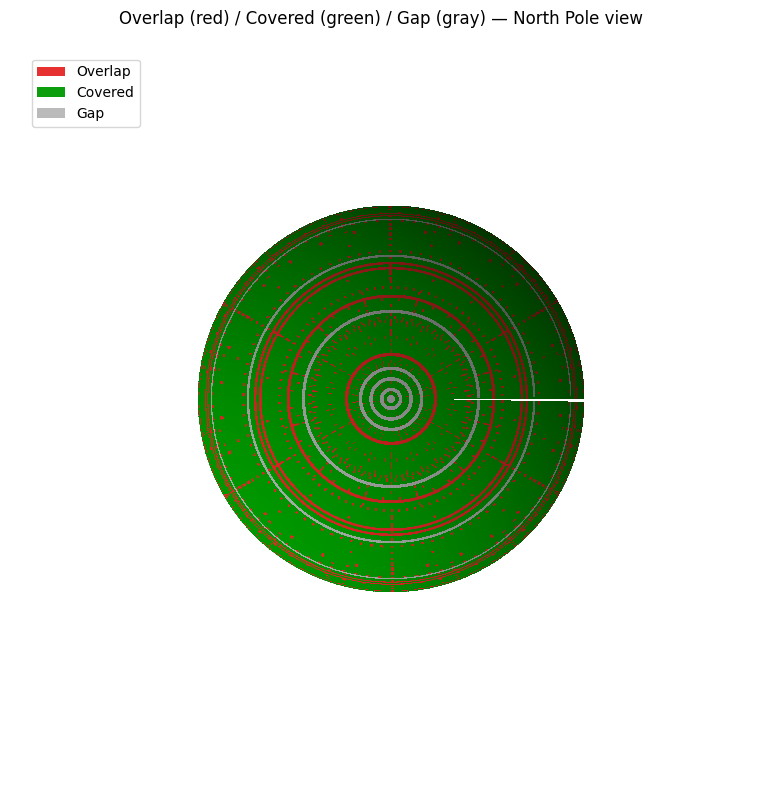

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================
# 설정
# =========================
CSV_PATH = r"64/64_RGB_coords_with_bounds.csv"  # 대상 CSV
PHI_DEG_STEP   = 1.0    # φ=0..359
THETA_DEG_STEP = 1.0    # θ=0..180
TOL_PHI   = 1e-9
TOL_THETA = 1e-9

PI, TWOPI = np.pi, 2*np.pi
deg = np.deg2rad

# =========================
# 유틸
# =========================
def ang_norm(x):
    return (x % TWOPI + TWOPI) % TWOPI

def split_wrap_interval(L, R):
    L = ang_norm(L); R = ang_norm(R)
    if L <= R:
        return [(L, R)]
    else:
        return [(L, TWOPI), (0.0, R)]

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH)
for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)

# =========================
# 격자 구성 & 커버/겹침 계산
# =========================
phi_deg_vals   = np.arange(0.0, 360.0, PHI_DEG_STEP)
theta_deg_vals = np.arange(0.0, 181.0, THETA_DEG_STEP)
phi_vals   = deg(phi_deg_vals)
theta_vals = deg(theta_deg_vals)

H, W = len(phi_vals), len(theta_vals)
cover_count = np.zeros((H, W), dtype=np.int16)

for _, row in df.iterrows():
    L, R = float(row['phi_left']), float(row['phi_right'])
    t0, t1 = float(row['theta_lower']), float(row['theta_upper'])
    th_idx = np.where((theta_vals >= t0 - TOL_THETA) & (theta_vals <= t1 + TOL_THETA))[0]
    if th_idx.size == 0:
        continue
    for (l, r_) in split_wrap_interval(L, R):
        ph_idx = np.where((phi_vals >= l - TOL_PHI) & (phi_vals <= r_ + TOL_PHI))[0]
        cover_count[np.ix_(ph_idx, th_idx)] += 1

covered      = cover_count > 0
overlap_mask = cover_count > 1
gap_mask     = cover_count == 0

# =========================
# 구 표면 시각화 (North Pole 뷰)
# =========================
PHI_grid, THETA_grid = np.meshgrid(phi_vals, theta_vals, indexing='ij')
X = np.sin(THETA_grid) * np.cos(PHI_grid)
Y = np.sin(THETA_grid) * np.sin(PHI_grid)
Z = np.cos(THETA_grid)

rgba = np.zeros((H, W, 4))
rgba[..., :]        = [0.7, 0.7, 0.7, 0.9]   # gap = 회색
rgba[covered, :]    = [0.0, 0.6, 0.0, 0.95]  # covered = 초록
rgba[overlap_mask,:]= [0.9, 0.15, 0.15, 0.95]# overlap = 빨강

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=rgba, rstride=1, cstride=1, linewidth=0, antialiased=False)

# North Pole(위에서 아래로 보는 시점)
ax.view_init(elev=90, azim=-90)   # elev=+90°면 북극에서 내려다봄
ax.set_axis_off()
ax.set_box_aspect([1,1,1])
ax.set_title("Overlap (red) / Covered (green) / Gap (gray) — North Pole view", pad=10)
ax.legend(handles=[
    Patch(facecolor=(0.9, 0.15, 0.15, 0.95), label="Overlap"),
    Patch(facecolor=(0.0, 0.6, 0.0, 0.95),  label="Covered"),
    Patch(facecolor=(0.7, 0.7, 0.7, 0.9),   label="Gap")
], loc='upper left', bbox_to_anchor=(0.02, 0.98))

plt.tight_layout()
plt.show()


In [14]:
import numpy as np
import pandas as pd

# ----------------------------------
# 설정
# ----------------------------------
IN_CSV  = r"64/64 RGB coords_with_bounds.csv"
OUT_CSV = r"64/64_RGB_coords_with_bounds_FILLED.csv"

PHI_DEG_STEP = 0.5          # φ 스캔 간격(도): 0.5 → stripe 메움에 충분히 촘촘
TOL_THETA    = 1e-6         # θ gap 판단/안정화 허용오차
TOL_PHI      = 1e-12        # φ 포함 판정 허용오차

PI, TWOPI = np.pi, 2*np.pi
deg = np.deg2rad

# ----------------------------------
# 유틸
# ----------------------------------
def ang_norm(x):
    return (x % TWOPI + TWOPI) % TWOPI

def angle_in_interval(angle, left, right, tol=TOL_PHI):
    """
    angle ∈ [left, right] ? (원형 래핑 포함)
    """
    a = ang_norm(angle)
    L = ang_norm(left)
    R = ang_norm(right)
    if L <= R:
        return (a + tol >= L) and (a <= R + tol)
    else:
        # wrap-around
        return (a + tol >= L) or (a <= R + tol)

def clamp_theta(x):
    return min(max(float(x), 0.0), PI)

def cut_out_theta_band(df, lo, hi, eps=1e-12):
    """
    θ∈[lo,hi] 띠를 DF에서 제거/클리핑.
    - 완전 포함: drop
    - 겹치면 경계 잘라냄 (가운데를 가르는 경우는 왼쪽 조각만 보존)
    """
    df = df.copy()
    fully_in = (df['theta_lower'] >= lo - eps) & (df['theta_upper'] <= hi + eps)
    df = df.loc[~fully_in]

    left_cross  = (df['theta_lower'] < lo - eps) & (df['theta_upper'] > lo + eps) & (df['theta_upper'] <= hi + eps)
    right_cross = (df['theta_lower'] >= lo - eps) & (df['theta_lower'] <  hi - eps) & (df['theta_upper'] > hi + eps)
    middle_cut  = (df['theta_lower'] < lo - eps) & (df['theta_upper'] > hi + eps)

    # ...|----lo] : 상한을 lo로
    df.loc[left_cross, 'theta_upper'] = np.minimum(df.loc[left_cross, 'theta_upper'], lo)

    # [hi----|... : 하한을 hi로
    df.loc[right_cross, 'theta_lower'] = np.maximum(df.loc[right_cross, 'theta_lower'], hi)

    # 가운데 가르는 경우: 왼쪽 조각만 유지 ([theta_lower, lo])
    keep_left = df.loc[middle_cut].copy()
    keep_left['theta_upper'] = lo
    df = pd.concat([df.loc[~middle_cut], keep_left], ignore_index=True)

    df = df.loc[df['theta_upper'] - df['theta_lower'] > eps].reset_index(drop=True)
    return df

# ----------------------------------
# 로드 & 준비
# ----------------------------------
df = pd.read_csv(IN_CSV)
need = ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"입력 컬럼 누락: {miss}")

for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)
for c in ['r','g','b']:
    df[c] = df[c].astype(int)

# ----------------------------------
# 1) φ별 단면에서 θ-gap 반분 보정(원 데이터 in-place)
#    → stripe(φ 전범위)도 각 φ에서 인접 경계로 반분되며 메워짐
# ----------------------------------
phi_deg_vals = np.arange(0.0, 360.0, PHI_DEG_STEP)
phi_vals = deg(phi_deg_vals)

for phi_deg, phi in zip(phi_deg_vals, phi_vals):
    mask_phi = df.apply(lambda row: angle_in_interval(phi, row['phi_left'], row['phi_right'], tol=TOL_PHI), axis=1)
    if not mask_phi.any():
        continue

    # 현재 단면(φ)에서 θ_lower 기준 정렬 (원 인덱스 유지)
    sel = df.loc[mask_phi, ['theta_lower','theta_upper','r','g','b']].copy()
    sel = sel.sort_values('theta_lower', kind='mergesort').reset_index(drop=False)
    # sel['index']에 원본 df 인덱스가 있음
    n = len(sel)

    for i in range(n - 1):
        idx_i = sel.at[i, 'index']
        idx_j = sel.at[i+1, 'index']

        lo_i = sel.at[i,   'theta_lower']
        hi_i = sel.at[i,   'theta_upper']
        lo_j = sel.at[i+1, 'theta_lower']
        hi_j = sel.at[i+1, 'theta_upper']

        gap = lo_j - hi_i
        if gap > TOL_THETA:
            mid = clamp_theta(hi_i + 0.5 * gap)  # 절반점
            # 양쪽 RGB에 절반씩 배분
            df.at[idx_i, 'theta_upper'] = mid
            df.at[idx_j, 'theta_lower'] = mid

            # 슬라이스에도 반영(뒤 인접쌍 계산에 영향)
            sel.at[i,   'theta_upper'] = mid
            sel.at[i+1, 'theta_lower'] = mid
        # 겹침/연속은 건드리지 않음

# ----------------------------------
# 2) 폴라 캡(골무) 강제 채움
#    - 전 데이터에서 첫 바운드/마지막 바운드 자동 검출
#    - 북극 [0, θ_cap_N] → (0,0,0)
#    - 남극 [θ_cap_S, π] → (252,252,252)
# ----------------------------------
theta_min_lower = float(df['theta_lower'].min())   # 가장 이른 시작
theta_max_upper = float(df['theta_upper'].max())   # 가장 늦은 끝

# 약간의 안전 여유를 줄 수도 있음(원하면 margin을 추가)
theta_cap_N = max(0.0, theta_min_lower)
theta_cap_S = min(PI,  theta_max_upper)

# 캡 영역과 겹치는 기존 구간 제거/클리핑
df = cut_out_theta_band(df, 0.0, theta_cap_N, eps=TOL_THETA)
df = cut_out_theta_band(df, theta_cap_S, PI,  eps=TOL_THETA)

# 캡 2개 행 추가 (φ 전범위)
top_cap = pd.DataFrame([{
    'r': 0, 'g': 0, 'b': 0,
    'theta_lower': 0.0, 'theta_upper': theta_cap_N,
    'phi_left': 0.0, 'phi_right': TWOPI - 1e-9
}])
bottom_cap = pd.DataFrame([{
    'r': 252, 'g': 252, 'b': 252,
    'theta_lower': theta_cap_S, 'theta_upper': PI,
    'phi_left': 0.0, 'phi_right': TWOPI - 1e-9
}])
df = pd.concat([df, top_cap, bottom_cap], ignore_index=True)

# 정렬 & 저장
df = df.sort_values(['theta_lower','theta_upper','phi_left','phi_right','r','g','b']).reset_index(drop=True)
df.to_csv(OUT_CSV, index=False)
print(f"[완료] φ별 θ-gap stripe 메움 + 폴라 캡(골무) 강제 채움 → {OUT_CSV}")
print(f"θ_cap_N(북극 상한)={theta_cap_N:.9f} rad, θ_cap_S(남극 하한)={theta_cap_S:.9f} rad")


[완료] φ별 θ-gap stripe 메움 + 폴라 캡(골무) 강제 채움 → 64/64_RGB_coords_with_bounds_FILLED.csv
θ_cap_N(북극 상한)=0.000000000 rad, θ_cap_S(남극 하한)=3.141592654 rad


Global coverage: 100.0000%
Overlap cells: 64460  (98.9257%)
[저장] 겹침 셀 샘플 → overlap_cells_with_rgbs.csv  (행 수=82041)


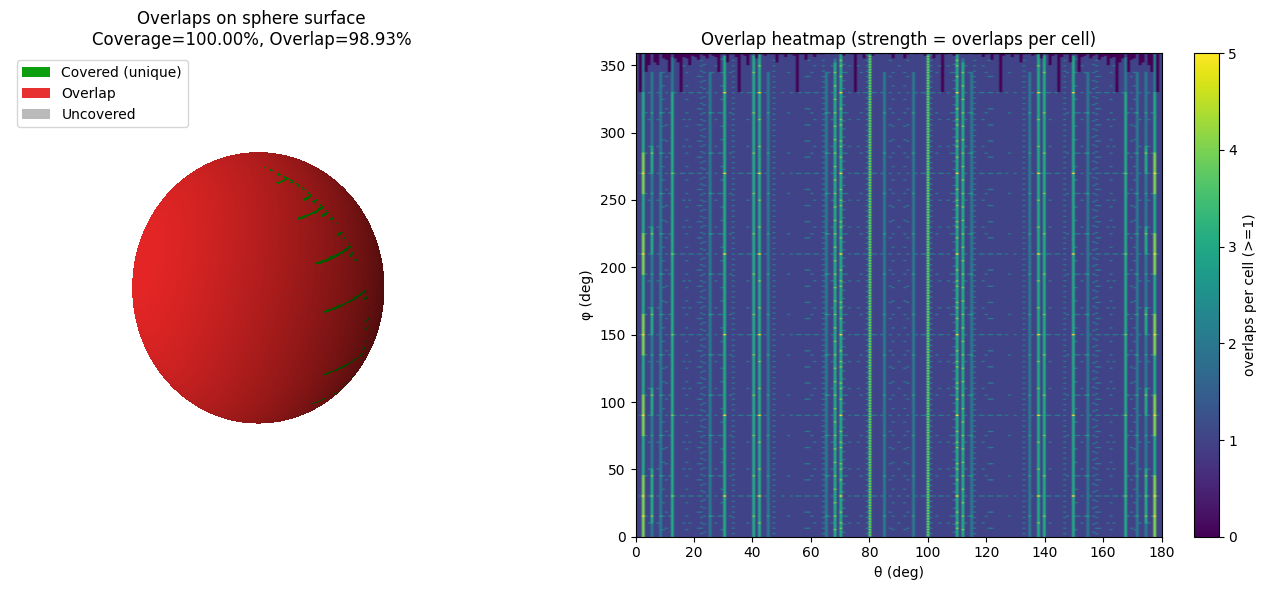

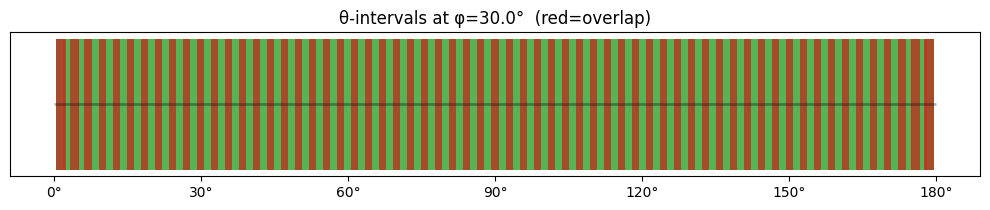

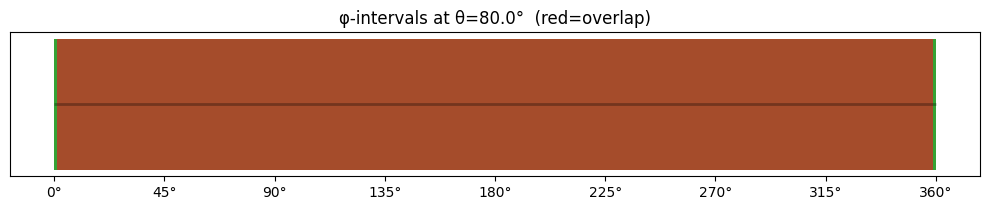

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (for old matplotlib)

# =========================
# 설정
# =========================
CSV_PATH = r"64/64_RGB_coords_with_bounds_FILLED.csv"  # 파일 경로
PHI_DEG_STEP   = 1.0   # φ 그리드 간격(도)
THETA_DEG_STEP = 1.0   # θ 그리드 간격(도)
TOL_PHI   = 1e-9
TOL_THETA = 1e-9

EXPORT_CONFLICTS = True
CONFLICTS_CSV = "overlap_cells_with_rgbs.csv"

PI, TWOPI = np.pi, 2*np.pi
deg = np.deg2rad
rad = np.rad2deg

# =========================
# 유틸
# =========================
def ang_norm(x):
    return (x % TWOPI + TWOPI) % TWOPI

def phi_in_interval(phi, L, R, tol=TOL_PHI):
    a = ang_norm(phi); L = ang_norm(L); R = ang_norm(R)
    if L <= R:
        return (a + tol >= L) and (a <= R + tol)
    else:
        return (a + tol >= L) or (a <= R + tol)

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH)
need = ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"컬럼 누락: {miss}")
for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)
for c in ['r','g','b']:
    df[c] = df[c].astype(int)

# =========================
# 격자 구성
# =========================
phi_deg_vals   = np.arange(0.0, 360.0, PHI_DEG_STEP)   # 0..359
theta_deg_vals = np.arange(0.0, 181.0, THETA_DEG_STEP) # 0..180
phi_vals   = deg(phi_deg_vals)
theta_vals = deg(theta_deg_vals)

H, W = len(phi_vals), len(theta_vals)

cover_count = np.zeros((H, W), dtype=np.int32)       # 셀을 덮은 구간 수
first_rgb   = np.full((H, W, 3), -1, dtype=np.int16) # 첫 RGB 기록
conf_list   = []                                      # [(phi_deg,theta_deg, rgb1, rgb2, ...)]

# =========================
# 래스터라이즈 & 충돌 기록
# =========================
for _, row in df.iterrows():
    L = float(row['phi_left']); R = float(row['phi_right'])
    t0 = float(row['theta_lower']); t1 = float(row['theta_upper'])
    r,g,b = int(row['r']), int(row['g']), int(row['b'])

    th_idx = np.where((theta_vals >= t0 - TOL_THETA) & (theta_vals <= t1 + TOL_THETA))[0]
    if th_idx.size == 0:
        continue

    if ang_norm(L) <= ang_norm(R):
        stripes = [np.where((phi_vals >= L - TOL_PHI) & (phi_vals <= R + TOL_PHI))[0]]
    else:
        s1 = np.where((phi_vals >= L - TOL_PHI) & (phi_vals <= TWOPI + TOL_PHI))[0]
        s2 = np.where((phi_vals >= 0 - TOL_PHI) & (phi_vals <= R + TOL_PHI))[0]
        stripes = [s1, s2]

    for ids in stripes:
        for i in ids:
            for j in th_idx:
                if cover_count[i, j] == 0:
                    cover_count[i, j] = 1
                    first_rgb[i, j, :] = (r,g,b)
                else:
                    # 이미 덮인 셀 → 겹침 증가
                    cover_count[i, j] += 1
                    # 충돌 RGB 수집(최초와 현재만 기록)
                    prev = tuple(first_rgb[i, j, :])
                    now  = (r,g,b)
                    if prev != now:
                        conf_list.append((float(phi_deg_vals[i]), float(theta_deg_vals[j]), prev, now))

# =========================
# 요약 메트릭
# =========================
covered = cover_count > 0
overlap_mask = cover_count > 1
global_coverage = covered.mean() * 100.0
overlap_ratio  = overlap_mask.mean() * 100.0
n_overlap_cells = int(overlap_mask.sum())

print(f"Global coverage: {global_coverage:.4f}%")
print(f"Overlap cells: {n_overlap_cells}  ({overlap_ratio:.4f}%)")

if EXPORT_CONFLICTS and len(conf_list):
    pd.DataFrame(conf_list, columns=["phi_deg","theta_deg","rgb_first","rgb_second"])\
      .to_csv(CONFLICTS_CSV, index=False)
    print(f"[저장] 겹침 셀 샘플 → {CONFLICTS_CSV}  (행 수={len(conf_list)})")

# =========================
# 3D 구 표면 시각화 (겹침=빨강, 정상=초록, 미커버=회색)
# =========================
PHI_grid, THETA_grid = np.meshgrid(phi_vals, theta_vals, indexing='ij')
X = np.sin(THETA_grid) * np.cos(PHI_grid)
Y = np.sin(THETA_grid) * np.sin(PHI_grid)
Z = np.cos(THETA_grid)

rgba = np.zeros((H, W, 4))
# 기본: 미커버 회색
rgba[..., :] = [0.7, 0.7, 0.7, 0.9]
# 정상 커버 초록
rgba[covered, :] = [0.0, 0.6, 0.0, 0.95]
# 겹침 빨강
rgba[overlap_mask, :] = [0.9, 0.15, 0.15, 0.95]

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=rgba, rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_axis_off()
ax.set_box_aspect([1,1,1])
ax.set_title(f"Overlaps on sphere surface\nCoverage={global_coverage:.2f}%, Overlap={overlap_ratio:.2f}%")
ax.legend(handles=[
    Patch(facecolor=(0.0, 0.6, 0.0, 0.95), label="Covered (unique)"),
    Patch(facecolor=(0.9, 0.15, 0.15, 0.95), label="Overlap"),
    Patch(facecolor=(0.7, 0.7, 0.7, 0.9),   label="Uncovered")
], loc='upper left')

# =========================
# 밴드(heatmap) 시각화: 겹침 강도
# =========================
ax2 = fig.add_subplot(122)
# 겹침 강도 = cover_count-1 (0이면 겹침 없음)
overlap_strength = np.maximum(cover_count - 1, 0)
im = ax2.imshow(
    overlap_strength,
    origin='lower',
    aspect='auto',
    extent=[theta_deg_vals.min(), theta_deg_vals.max(), phi_deg_vals.min(), phi_deg_vals.max()]
)
ax2.set_xlabel("θ (deg)")
ax2.set_ylabel("φ (deg)")
ax2.set_title("Overlap heatmap (strength = overlaps per cell)")
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label("overlaps per cell (>=1)")

plt.tight_layout()
plt.show()

# =========================
# 겹침이 많은 단면을 골라 밴드 막대 플롯
# - φ 고정(θ-밴드)와 θ 고정(φ-밴드) 중 하나씩 자동 선택
# =========================
# φ별 겹침 합
phi_overlap_sum = overlap_strength.sum(axis=1)  # 각 φ 행의 합
theta_overlap_sum = overlap_strength.sum(axis=0) # 각 θ 열의 합

def plot_phi_slice(phi_deg_pick):
    """해당 φ에서 θ-구간 막대 + 겹침 강조"""
    phi = deg(phi_deg_pick)
    mask = df.apply(lambda r: phi_in_interval(phi, r['phi_left'], r['phi_right'], TOL_PHI), axis=1)
    sub = df.loc[mask, ['theta_lower','theta_upper','r','g','b']].copy()
    sub = sub.sort_values('theta_lower').reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, 2.2))
    ax.hlines(0.5, 0, PI, color='black', alpha=0.3, linewidth=2)
    # 막대 그리기
    for k, row in sub.iterrows():
        lo, hi = row['theta_lower'], row['theta_upper']
        ax.broken_barh([(lo, hi-lo)], (0.35, 0.30), facecolors='tab:green', alpha=0.8, edgecolor='none')
    # 겹침 구간만 빨간 반투명 레이어로 강조
    for (a,b) in zip(sub.itertuples(), sub.iloc[1:].itertuples()):
        ov = a.theta_upper - b.theta_lower
        if ov > TOL_THETA:
            ax.broken_barh([(b.theta_lower, ov)], (0.35, 0.30), facecolors='tab:red', alpha=0.7, edgecolor='none')
    xt = np.linspace(0, PI, 7)
    ax.set_xticks(xt); ax.set_xticklabels([f"{np.degrees(x):.0f}°" for x in xt])
    ax.set_yticks([])
    ax.set_title(f"θ-intervals at φ={phi_deg_pick:.1f}°  (red=overlap)")
    plt.tight_layout(); plt.show()

def plot_theta_slice(theta_deg_pick):
    """해당 θ에서 φ-구간 막대 + 겹침/래핑 겹침 강조"""
    th = deg(theta_deg_pick)
    mask = (df['theta_lower'] - TOL_THETA <= th) & (th <= df['theta_upper'] + TOL_THETA)
    sub = df.loc[mask, ['phi_left','phi_right']].copy()
    if sub.empty:
        print(f"[θ={theta_deg_pick}°] no intervals")
        return
    sub['phi_left']  = sub['phi_left'].map(ang_norm)
    sub['phi_right'] = sub['phi_right'].map(ang_norm)
    sub = sub.sort_values('phi_left').reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, 2.2))
    ax.hlines(0.5, 0, TWOPI, color='black', alpha=0.3, linewidth=2)
    # 막대
    for k, row in sub.iterrows():
        L, R = row['phi_left'], row['phi_right']
        if L <= R:
            ax.broken_barh([(L, R-L)], (0.35, 0.30), facecolors='tab:green', alpha=0.8, edgecolor='none')
        else:
            ax.broken_barh([(L, TWOPI-L)], (0.35, 0.30), facecolors='tab:green', alpha=0.8, edgecolor='none')
            ax.broken_barh([(0.0, R)],      (0.35, 0.30), facecolors='tab:green', alpha=0.8, edgecolor='none')
    # 내부 겹침 강조
    for (a,b) in zip(sub.itertuples(), sub.iloc[1:].itertuples()):
        ov = a.phi_right - b.phi_left
        if ov > TOL_PHI:
            ax.broken_barh([(b.phi_left, ov)], (0.35, 0.30), facecolors='tab:red', alpha=0.7, edgecolor='none')
    # 래핑 겹침(끝↔처음)
    if len(sub) >= 2:
        Rlast = sub.iloc[-1]['phi_right']
        Lfirst= sub.iloc[0 ]['phi_left']
        ov_len = (Rlast - Lfirst) % TWOPI
        gap_len= (Lfirst - Rlast) % TWOPI
        if ov_len > TOL_PHI and ov_len < gap_len:
            # wrap overlap 강조(끝쪽)
            ax.broken_barh([(Rlast-ov_len, ov_len)], (0.35, 0.30), facecolors='tab:red', alpha=0.7, edgecolor='none')

    xt = np.linspace(0, TWOPI, 9)
    ax.set_xticks(xt); ax.set_xticklabels([f"{np.degrees(x):.0f}°" for x in xt])
    ax.set_yticks([])
    ax.set_title(f"φ-intervals at θ={theta_deg_pick:.1f}°  (red=overlap)")
    plt.tight_layout(); plt.show()

# 자동 선택해서 예시로 그림
if n_overlap_cells > 0:
    phi_pick = float(phi_deg_vals[np.argmax(phi_overlap_sum)])    # 겹침이 가장 많은 φ
    th_pick  = float(theta_deg_vals[np.argmax(theta_overlap_sum)])# 겹침이 가장 많은 θ
    plot_phi_slice(phi_pick)
    plot_theta_slice(th_pick)
else:
    print("겹침 셀이 없어 밴드 상세 플롯은 생략합니다.")


Global coverage: 100.0000%
Overlap cells: 58700  (90.0859%)
[저장] 겹침 셀 샘플 → overlap_cells_with_rgbs.csv  (행 수=70837)


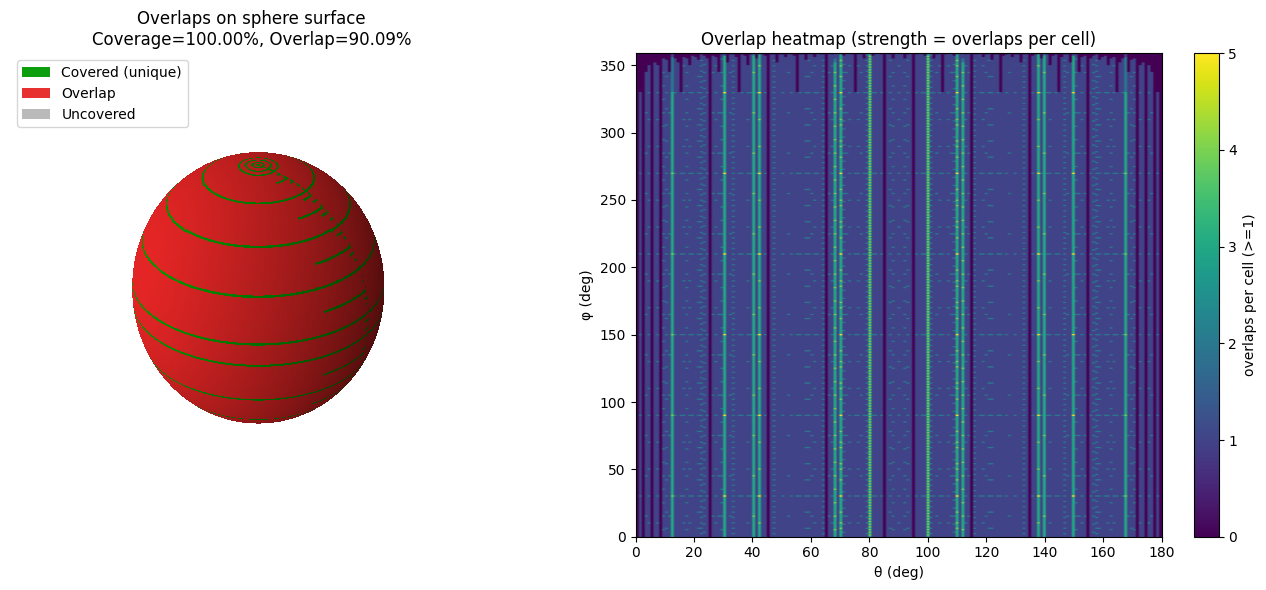

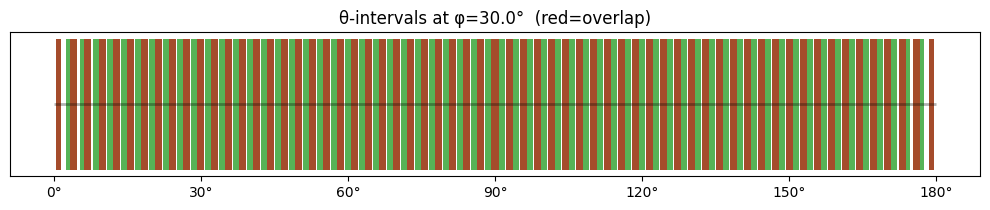

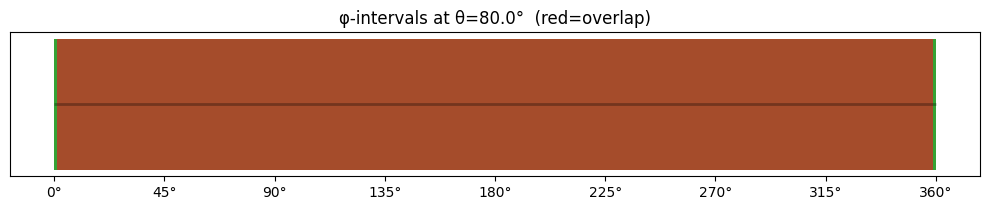

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (for old matplotlib)

# =========================
# 설정
# =========================
CSV_PATH = r"64/64_RGB coords_with_bounds.csv"  # 파일 경로
PHI_DEG_STEP   = 1.0   # φ 그리드 간격(도)
THETA_DEG_STEP = 1.0   # θ 그리드 간격(도)
TOL_PHI   = 1e-9
TOL_THETA = 1e-9

EXPORT_CONFLICTS = True
CONFLICTS_CSV = "overlap_cells_with_rgbs.csv"

PI, TWOPI = np.pi, 2*np.pi
deg = np.deg2rad
rad = np.rad2deg

# =========================
# 유틸
# =========================
def ang_norm(x):
    return (x % TWOPI + TWOPI) % TWOPI

def phi_in_interval(phi, L, R, tol=TOL_PHI):
    a = ang_norm(phi); L = ang_norm(L); R = ang_norm(R)
    if L <= R:
        return (a + tol >= L) and (a <= R + tol)
    else:
        return (a + tol >= L) or (a <= R + tol)

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH)
need = ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"컬럼 누락: {miss}")
for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)
for c in ['r','g','b']:
    df[c] = df[c].astype(int)

# =========================
# 격자 구성
# =========================
phi_deg_vals   = np.arange(0.0, 360.0, PHI_DEG_STEP)   # 0..359
theta_deg_vals = np.arange(0.0, 181.0, THETA_DEG_STEP) # 0..180
phi_vals   = deg(phi_deg_vals)
theta_vals = deg(theta_deg_vals)

H, W = len(phi_vals), len(theta_vals)

cover_count = np.zeros((H, W), dtype=np.int32)       # 셀을 덮은 구간 수
first_rgb   = np.full((H, W, 3), -1, dtype=np.int16) # 첫 RGB 기록
conf_list   = []                                      # [(phi_deg,theta_deg, rgb1, rgb2, ...)]

# =========================
# 래스터라이즈 & 충돌 기록
# =========================
for _, row in df.iterrows():
    L = float(row['phi_left']); R = float(row['phi_right'])
    t0 = float(row['theta_lower']); t1 = float(row['theta_upper'])
    r,g,b = int(row['r']), int(row['g']), int(row['b'])

    th_idx = np.where((theta_vals >= t0 - TOL_THETA) & (theta_vals <= t1 + TOL_THETA))[0]
    if th_idx.size == 0:
        continue

    if ang_norm(L) <= ang_norm(R):
        stripes = [np.where((phi_vals >= L - TOL_PHI) & (phi_vals <= R + TOL_PHI))[0]]
    else:
        s1 = np.where((phi_vals >= L - TOL_PHI) & (phi_vals <= TWOPI + TOL_PHI))[0]
        s2 = np.where((phi_vals >= 0 - TOL_PHI) & (phi_vals <= R + TOL_PHI))[0]
        stripes = [s1, s2]

    for ids in stripes:
        for i in ids:
            for j in th_idx:
                if cover_count[i, j] == 0:
                    cover_count[i, j] = 1
                    first_rgb[i, j, :] = (r,g,b)
                else:
                    # 이미 덮인 셀 → 겹침 증가
                    cover_count[i, j] += 1
                    # 충돌 RGB 수집(최초와 현재만 기록)
                    prev = tuple(first_rgb[i, j, :])
                    now  = (r,g,b)
                    if prev != now:
                        conf_list.append((float(phi_deg_vals[i]), float(theta_deg_vals[j]), prev, now))

# =========================
# 요약 메트릭
# =========================
covered = cover_count > 0
overlap_mask = cover_count > 1
global_coverage = covered.mean() * 100.0
overlap_ratio  = overlap_mask.mean() * 100.0
n_overlap_cells = int(overlap_mask.sum())

print(f"Global coverage: {global_coverage:.4f}%")
print(f"Overlap cells: {n_overlap_cells}  ({overlap_ratio:.4f}%)")

if EXPORT_CONFLICTS and len(conf_list):
    pd.DataFrame(conf_list, columns=["phi_deg","theta_deg","rgb_first","rgb_second"])\
      .to_csv(CONFLICTS_CSV, index=False)
    print(f"[저장] 겹침 셀 샘플 → {CONFLICTS_CSV}  (행 수={len(conf_list)})")

# =========================
# 3D 구 표면 시각화 (겹침=빨강, 정상=초록, 미커버=회색)
# =========================
PHI_grid, THETA_grid = np.meshgrid(phi_vals, theta_vals, indexing='ij')
X = np.sin(THETA_grid) * np.cos(PHI_grid)
Y = np.sin(THETA_grid) * np.sin(PHI_grid)
Z = np.cos(THETA_grid)

rgba = np.zeros((H, W, 4))
# 기본: 미커버 회색
rgba[..., :] = [0.7, 0.7, 0.7, 0.9]
# 정상 커버 초록
rgba[covered, :] = [0.0, 0.6, 0.0, 0.95]
# 겹침 빨강
rgba[overlap_mask, :] = [0.9, 0.15, 0.15, 0.95]

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=rgba, rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_axis_off()
ax.set_box_aspect([1,1,1])
ax.set_title(f"Overlaps on sphere surface\nCoverage={global_coverage:.2f}%, Overlap={overlap_ratio:.2f}%")
ax.legend(handles=[
    Patch(facecolor=(0.0, 0.6, 0.0, 0.95), label="Covered (unique)"),
    Patch(facecolor=(0.9, 0.15, 0.15, 0.95), label="Overlap"),
    Patch(facecolor=(0.7, 0.7, 0.7, 0.9),   label="Uncovered")
], loc='upper left')

# =========================
# 밴드(heatmap) 시각화: 겹침 강도
# =========================
ax2 = fig.add_subplot(122)
# 겹침 강도 = cover_count-1 (0이면 겹침 없음)
overlap_strength = np.maximum(cover_count - 1, 0)
im = ax2.imshow(
    overlap_strength,
    origin='lower',
    aspect='auto',
    extent=[theta_deg_vals.min(), theta_deg_vals.max(), phi_deg_vals.min(), phi_deg_vals.max()]
)
ax2.set_xlabel("θ (deg)")
ax2.set_ylabel("φ (deg)")
ax2.set_title("Overlap heatmap (strength = overlaps per cell)")
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label("overlaps per cell (>=1)")

plt.tight_layout()
plt.show()

# =========================
# 겹침이 많은 단면을 골라 밴드 막대 플롯
# - φ 고정(θ-밴드)와 θ 고정(φ-밴드) 중 하나씩 자동 선택
# =========================
# φ별 겹침 합
phi_overlap_sum = overlap_strength.sum(axis=1)  # 각 φ 행의 합
theta_overlap_sum = overlap_strength.sum(axis=0) # 각 θ 열의 합

def plot_phi_slice(phi_deg_pick):
    """해당 φ에서 θ-구간 막대 + 겹침 강조"""
    phi = deg(phi_deg_pick)
    mask = df.apply(lambda r: phi_in_interval(phi, r['phi_left'], r['phi_right'], TOL_PHI), axis=1)
    sub = df.loc[mask, ['theta_lower','theta_upper','r','g','b']].copy()
    sub = sub.sort_values('theta_lower').reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, 2.2))
    ax.hlines(0.5, 0, PI, color='black', alpha=0.3, linewidth=2)
    # 막대 그리기
    for k, row in sub.iterrows():
        lo, hi = row['theta_lower'], row['theta_upper']
        ax.broken_barh([(lo, hi-lo)], (0.35, 0.30), facecolors='tab:green', alpha=0.8, edgecolor='none')
    # 겹침 구간만 빨간 반투명 레이어로 강조
    for (a,b) in zip(sub.itertuples(), sub.iloc[1:].itertuples()):
        ov = a.theta_upper - b.theta_lower
        if ov > TOL_THETA:
            ax.broken_barh([(b.theta_lower, ov)], (0.35, 0.30), facecolors='tab:red', alpha=0.7, edgecolor='none')
    xt = np.linspace(0, PI, 7)
    ax.set_xticks(xt); ax.set_xticklabels([f"{np.degrees(x):.0f}°" for x in xt])
    ax.set_yticks([])
    ax.set_title(f"θ-intervals at φ={phi_deg_pick:.1f}°  (red=overlap)")
    plt.tight_layout(); plt.show()

def plot_theta_slice(theta_deg_pick):
    """해당 θ에서 φ-구간 막대 + 겹침/래핑 겹침 강조"""
    th = deg(theta_deg_pick)
    mask = (df['theta_lower'] - TOL_THETA <= th) & (th <= df['theta_upper'] + TOL_THETA)
    sub = df.loc[mask, ['phi_left','phi_right']].copy()
    if sub.empty:
        print(f"[θ={theta_deg_pick}°] no intervals")
        return
    sub['phi_left']  = sub['phi_left'].map(ang_norm)
    sub['phi_right'] = sub['phi_right'].map(ang_norm)
    sub = sub.sort_values('phi_left').reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, 2.2))
    ax.hlines(0.5, 0, TWOPI, color='black', alpha=0.3, linewidth=2)
    # 막대
    for k, row in sub.iterrows():
        L, R = row['phi_left'], row['phi_right']
        if L <= R:
            ax.broken_barh([(L, R-L)], (0.35, 0.30), facecolors='tab:green', alpha=0.8, edgecolor='none')
        else:
            ax.broken_barh([(L, TWOPI-L)], (0.35, 0.30), facecolors='tab:green', alpha=0.8, edgecolor='none')
            ax.broken_barh([(0.0, R)],      (0.35, 0.30), facecolors='tab:green', alpha=0.8, edgecolor='none')
    # 내부 겹침 강조
    for (a,b) in zip(sub.itertuples(), sub.iloc[1:].itertuples()):
        ov = a.phi_right - b.phi_left
        if ov > TOL_PHI:
            ax.broken_barh([(b.phi_left, ov)], (0.35, 0.30), facecolors='tab:red', alpha=0.7, edgecolor='none')
    # 래핑 겹침(끝↔처음)
    if len(sub) >= 2:
        Rlast = sub.iloc[-1]['phi_right']
        Lfirst= sub.iloc[0 ]['phi_left']
        ov_len = (Rlast - Lfirst) % TWOPI
        gap_len= (Lfirst - Rlast) % TWOPI
        if ov_len > TOL_PHI and ov_len < gap_len:
            # wrap overlap 강조(끝쪽)
            ax.broken_barh([(Rlast-ov_len, ov_len)], (0.35, 0.30), facecolors='tab:red', alpha=0.7, edgecolor='none')

    xt = np.linspace(0, TWOPI, 9)
    ax.set_xticks(xt); ax.set_xticklabels([f"{np.degrees(x):.0f}°" for x in xt])
    ax.set_yticks([])
    ax.set_title(f"φ-intervals at θ={theta_deg_pick:.1f}°  (red=overlap)")
    plt.tight_layout(); plt.show()

# 자동 선택해서 예시로 그림
if n_overlap_cells > 0:
    phi_pick = float(phi_deg_vals[np.argmax(phi_overlap_sum)])    # 겹침이 가장 많은 φ
    th_pick  = float(theta_deg_vals[np.argmax(theta_overlap_sum)])# 겹침이 가장 많은 θ
    plot_phi_slice(phi_pick)
    plot_theta_slice(th_pick)
else:
    print("겹침 셀이 없어 밴드 상세 플롯은 생략합니다.")


Global coverage = 100.0000%
Overlap conflicts = 82041


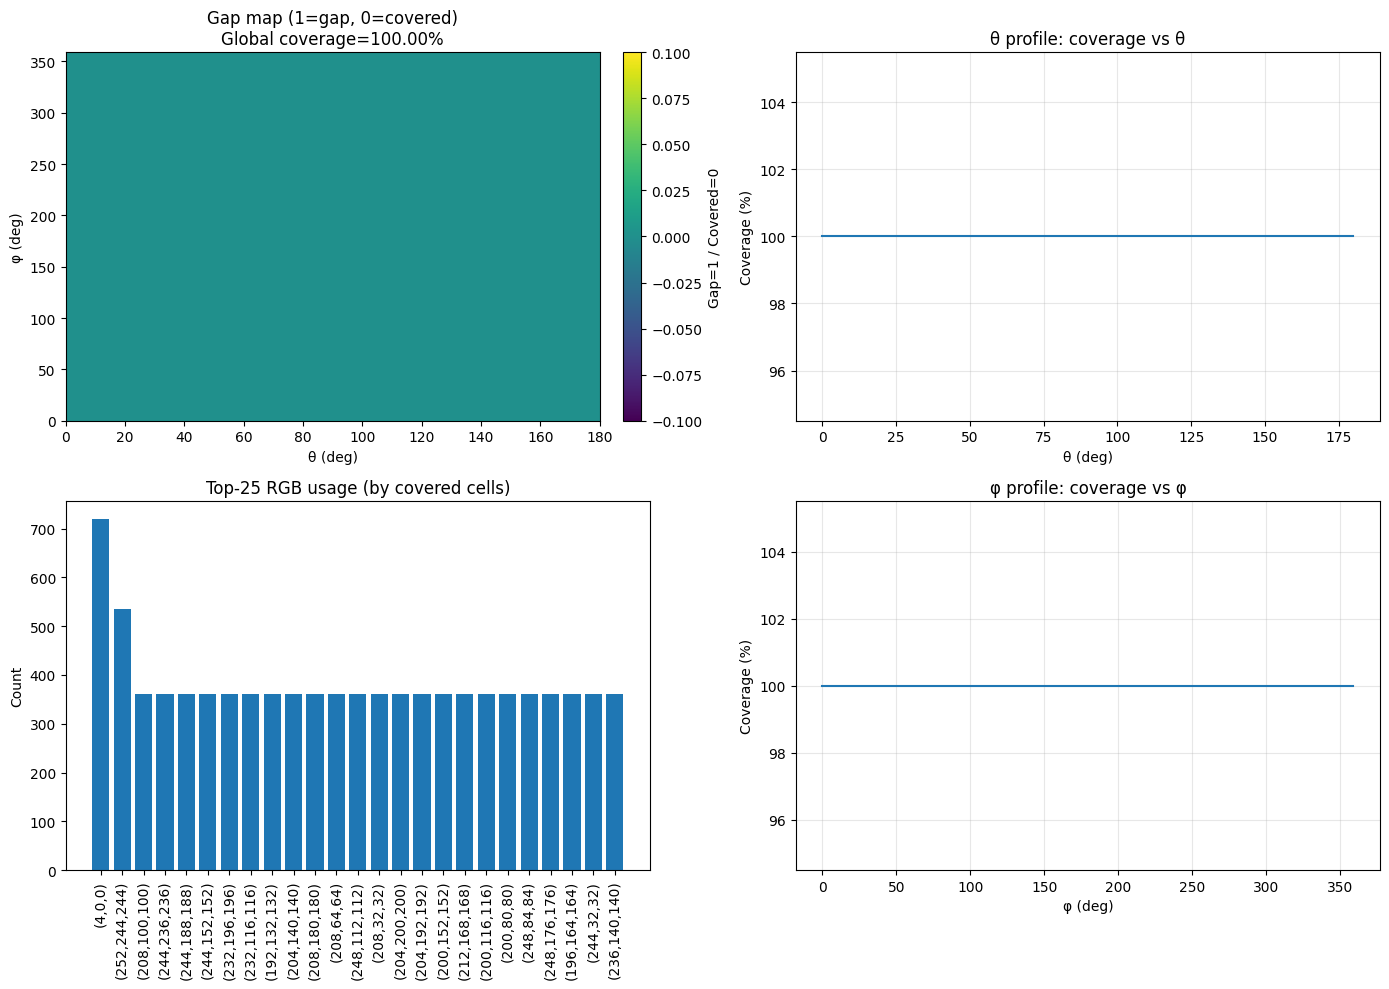

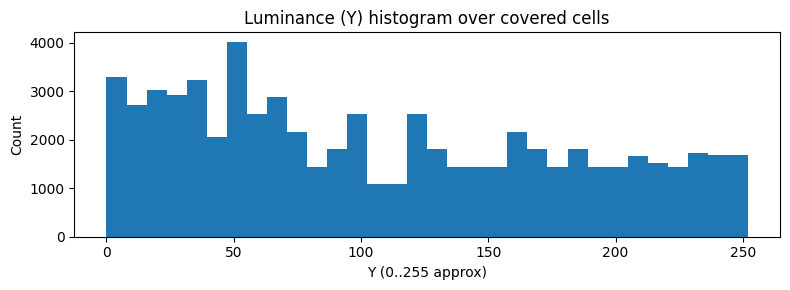

Saved: coverage_summary.csv, theta_profile.csv, phi_profile.csv, rgb_usage_counts.csv and overlap_conflicts_sample.csv


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# =========================
# 설정
# =========================
CSV_PATH = r"64/64_RGB_coords_with_bounds_FILLED.csv"   # 수정된 LUT 경로로 바꾸세요
PHI_DEG_STEP   = 1.0    # φ 분해능(도): 0.5~2.0 사이 조절 가능
THETA_DEG_STEP = 1.0    # θ 분해능(도)
TOL_PHI   = 1e-9
TOL_THETA = 1e-9

PI, TWOPI = np.pi, 2*np.pi
deg = np.deg2rad
rad = np.rad2deg

SAVE_REPORTS = True   # summary CSV들을 파일로 저장할지 여부

# =========================
# 유틸
# =========================
def ang_norm(x):
    return (x % TWOPI + TWOPI) % TWOPI

def phi_in_interval(phi, L, R, tol=TOL_PHI):
    """φ ∈ [L,R] ? (래핑 처리)"""
    a = ang_norm(phi); L = ang_norm(L); R = ang_norm(R)
    if L <= R:
        return (a + tol >= L) and (a <= R + tol)
    else:
        return (a + tol >= L) or (a <= R + tol)

# =========================
# 데이터 로드
# =========================
df = pd.read_csv(CSV_PATH)
need = ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"컬럼 누락: {miss}")
for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)
for c in ['r','g','b']:
    df[c] = df[c].astype(int)

# =========================
# 격자 구성
# =========================
phi_deg_vals   = np.arange(0.0, 360.0, PHI_DEG_STEP)        # 0..359
theta_deg_vals = np.arange(0.0, 181.0, THETA_DEG_STEP)      # 0..180
phi_vals   = deg(phi_deg_vals)
theta_vals = deg(theta_deg_vals)

H, W = len(phi_vals), len(theta_vals)
covered = np.zeros((H, W), dtype=bool)
rgb_map = np.full((H, W, 3), -1, dtype=int)     # -1: 미할당
conflicts = []                                   # (phi_deg, theta_deg, previous_rgb, new_rgb)

# =========================
# 래스터라이즈 (덮인 셀 채우기)
# =========================
for idx, row in df.iterrows():
    L = float(row['phi_left']); R = float(row['phi_right'])
    th_lo = float(row['theta_lower']); th_hi = float(row['theta_upper'])
    r,g,b = int(row['r']), int(row['g']), int(row['b'])

    # θ 인덱스 범위
    th_mask = (theta_vals >= th_lo - TOL_THETA) & (theta_vals <= th_hi + TOL_THETA)
    th_idx = np.where(th_mask)[0]
    if th_idx.size == 0:
        continue

    # φ는 원형: 빠른 마스크 생성을 위해 두 분기
    if ang_norm(L) <= ang_norm(R):
        phi_mask = (phi_vals >= L - TOL_PHI) & (phi_vals <= R + TOL_PHI)
        phi_idx = np.where(phi_mask)[0]
        stripes = [phi_idx]
    else:
        # wrap: [L,2π) U [0,R]
        phi_idx1 = np.where((phi_vals >= L - TOL_PHI) & (phi_vals <= TWOPI + TOL_PHI))[0]
        phi_idx2 = np.where((phi_vals >= 0 - TOL_PHI)  & (phi_vals <= R   + TOL_PHI))[0]
        stripes = [phi_idx1, phi_idx2]

    for ph_ids in stripes:
        for i in ph_ids:
            for j in th_idx:
                if not covered[i, j]:
                    covered[i, j] = True
                    rgb_map[i, j, :] = (r, g, b)
                else:
                    # 이미 다른 구간이 채운 셀 → 오버랩
                    prev = tuple(rgb_map[i, j, :])
                    new  = (r, g, b)
                    if prev != new:
                        conflicts.append((float(phi_deg_vals[i]), float(theta_deg_vals[j]), prev, new))

# =========================
# 리포트 메트릭
# =========================
global_coverage = covered.mean() * 100.0
n_conflicts = len(conflicts)
print(f"Global coverage = {global_coverage:.4f}%")
print(f"Overlap conflicts = {n_conflicts}")

# θ/φ 프로파일
theta_profile = covered.mean(axis=0) * 100.0   # θ 고정 시 φ 평균
phi_profile   = covered.mean(axis=1) * 100.0   # φ 고정 시 θ 평균

# RGB 분포 (덮인 셀 기준)
valid_rgb = rgb_map.reshape(-1, 3)
valid_rgb = valid_rgb[(valid_rgb[:,0] >= 0)]
rgb_df = pd.DataFrame(valid_rgb, columns=['r','g','b'])
rgb_counts = rgb_df.value_counts().reset_index(name='count').sort_values('count', ascending=False)

# Luminance(Y) 히스토그램
if len(valid_rgb) > 0:
    Y = 0.2126*valid_rgb[:,0] + 0.7152*valid_rgb[:,1] + 0.0722*valid_rgb[:,2]
else:
    Y = np.array([])

# =========================
# 시각화
# =========================
fig = plt.figure(figsize=(14, 10))

# (1) Gap heatmap
ax1 = fig.add_subplot(221)
heat = (~covered).astype(float)
im1 = ax1.imshow(
    heat,
    origin='lower',
    aspect='auto',
    extent=[theta_deg_vals.min(), theta_deg_vals.max(), phi_deg_vals.min(), phi_deg_vals.max()]
)
ax1.set_title(f"Gap map (1=gap, 0=covered)\nGlobal coverage={global_coverage:.2f}%")
ax1.set_xlabel("θ (deg)")
ax1.set_ylabel("φ (deg)")
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label="Gap=1 / Covered=0")

# (2) θ/φ coverage profiles
ax2 = fig.add_subplot(222)
ax2.plot(theta_deg_vals, theta_profile)
ax2.set_title("θ profile: coverage vs θ")
ax2.set_xlabel("θ (deg)")
ax2.set_ylabel("Coverage (%)")
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(224)
ax3.plot(phi_deg_vals, phi_profile)
ax3.set_title("φ profile: coverage vs φ")
ax3.set_xlabel("φ (deg)")
ax3.set_ylabel("Coverage (%)")
ax3.grid(True, alpha=0.3)

# (3) RGB 상위 사용 막대
ax4 = fig.add_subplot(223)
topK = 25  # 상위 K개 색만 표시(많으면 가독성 저하)
show = rgb_counts.head(topK)
labels = [f"({r},{g},{b})" for r,g,b in show[['r','g','b']].to_numpy()]
ax4.bar(range(len(show)), show['count'].to_numpy())
ax4.set_xticks(range(len(show)))
ax4.set_xticklabels(labels, rotation=90)
ax4.set_title(f"Top-{topK} RGB usage (by covered cells)")
ax4.set_ylabel("Count")

plt.tight_layout()
plt.show()

# (4) 밝기 히스토그램 (별도 도표)
plt.figure(figsize=(8,3))
if Y.size:
    plt.hist(Y, bins=32)
    plt.title("Luminance (Y) histogram over covered cells")
    plt.xlabel("Y (0..255 approx)")
    plt.ylabel("Count")
else:
    plt.title("No covered cells found")
plt.tight_layout()
plt.show()

# =========================
# 결과 저장 (선택)
# =========================
if SAVE_REPORTS:
    # 요약
    summary = pd.DataFrame([{
        "global_coverage_pct": global_coverage,
        "n_conflicts": n_conflicts,
        "phi_step_deg": PHI_DEG_STEP,
        "theta_step_deg": THETA_DEG_STEP
    }])
    summary.to_csv("coverage_summary.csv", index=False)

    # 프로파일
    pd.DataFrame({"theta_deg": theta_deg_vals, "coverage_pct": theta_profile}).to_csv("theta_profile.csv", index=False)
    pd.DataFrame({"phi_deg": phi_deg_vals,   "coverage_pct": phi_profile}).to_csv("phi_profile.csv", index=False)

    # RGB 분포
    rgb_counts.to_csv("rgb_usage_counts.csv", index=False)

    # 충돌 샘플 (많을 수 있으니 상위 5천개만)
    if n_conflicts:
        pd.DataFrame(conflicts, columns=["phi_deg","theta_deg","prev_rgb","new_rgb"]).head(5000)\
          .to_csv("overlap_conflicts_sample.csv", index=False)

    print("Saved: coverage_summary.csv, theta_profile.csv, phi_profile.csv, rgb_usage_counts.csv",
          ("and overlap_conflicts_sample.csv" if n_conflicts else ""))


In [16]:
import numpy as np
import pandas as pd

# =====================
# 설정
# =====================
IN_CSV  = r"64/64_RGB_coords_with_bounds_FILLED.csv"
OUT_CSV = r"64/64_RGB_coords_with_bounds_DEOVERLAPPED.csv"

# 단면 스윕 해상도(격자가 촘촘할수록 수렴이 빠름. 너무 작으면 느림)
PHI_DEG_STEP   = 0.5    # φ=0..359.5
THETA_DEG_STEP = 0.5    # θ=0..179.5

# 허용오차
TOL_THETA = 1e-6
TOL_PHI   = 1e-9

# 반복 패스
MAX_SUPERPASSES = 6     # (φ-스윕 → θ-스윕)을 한 세트로 최대 N번

PI, TWOPI = np.pi, 2*np.pi
deg = np.deg2rad

# =====================
# 유틸
# =====================
def ang_norm(x):
    return (x % TWOPI + TWOPI) % TWOPI

def phi_contains(phi, L, R, tol=TOL_PHI):
    """φ ∈ [L,R]? 래핑 포함"""
    a = ang_norm(phi); L = ang_norm(L); R = ang_norm(R)
    if L <= R:
        return (a + tol >= L) and (a <= R + tol)
    else:
        return (a + tol >= L) or (a <= R + tol)

def circ_mid(a, b):
    """
    원형 [0,2π)에서 a와 b 사이의 '짧은 호' 중점.
    (여기선 겹침경계만 다루므로 L<=R 정렬상 a≈upper, b≈next_left 가정)
    """
    # a->b 시계방향 길이
    d = (b - a) % TWOPI
    return ang_norm(a + 0.5*d)

def clamp_theta(x):
    return float(min(max(x, 0.0), PI))

# =====================
# 데이터 로드
# =====================
df = pd.read_csv(IN_CSV)
need = ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"입력 컬럼 누락: {miss}")

for c in ['theta_lower','theta_upper','phi_left','phi_right']:
    df[c] = df[c].astype(float)
for c in ['r','g','b']:
    df[c] = df[c].astype(int)

# =====================
# φ-고정: θ-겹침 제거
# =====================
def sweep_phi_fix_theta_overlaps(df, phi_deg_vals):
    df = df.copy()
    for phi_deg in phi_deg_vals:
        phi = deg(phi_deg)
        mask = df.apply(lambda r: phi_contains(phi, r['phi_left'], r['phi_right'], TOL_PHI), axis=1)
        if not mask.any(): 
            continue
        # θ_lower로 정렬 (원본 인덱스 유지)
        sub = df.loc[mask, ['theta_lower','theta_upper']].copy()
        sub['idx'] = df.index[mask]
        sub = sub.sort_values('theta_lower', kind='mergesort').reset_index(drop=True)

        # 인접쌍 겹침 해소
        for i in range(len(sub)-1):
            i1 = int(sub.at[i,   'idx'])
            i2 = int(sub.at[i+1, 'idx'])
            up1 = float(df.at[i1, 'theta_upper'])
            lo2 = float(df.at[i2, 'theta_lower'])

            ov = up1 - lo2
            if ov > TOL_THETA:
                mid = clamp_theta( (up1 + lo2) * 0.5 )
                df.at[i1, 'theta_upper'] = mid
                df.at[i2, 'theta_lower'] = mid
                sub.at[i,   'theta_upper'] = mid
                sub.at[i+1, 'theta_lower'] = mid
    return df

# =====================
# θ-고정: φ-겹침 제거 (원형)
# =====================
def sweep_theta_fix_phi_overlaps(df, theta_deg_vals):
    df = df.copy()
    for th_deg in theta_deg_vals:
        th = deg(th_deg)
        mask = (df['theta_lower'] - TOL_THETA <= th) & (th <= df['theta_upper'] + TOL_THETA)
        if not mask.any():
            continue

        sub = df.loc[mask, ['phi_left','phi_right']].copy()
        sub['idx'] = df.index[mask]
        # [0,2π) 정규화 + left 기준 정렬
        sub['phi_left']  = sub['phi_left'].map(ang_norm)
        sub['phi_right'] = sub['phi_right'].map(ang_norm)
        sub = sub.sort_values('phi_left', kind='mergesort').reset_index(drop=True)

        n = len(sub)
        # 내부 인접쌍
        for i in range(n-1):
            i1 = int(sub.at[i,   'idx'])
            i2 = int(sub.at[i+1, 'idx'])
            L1 = float(sub.at[i,   'phi_left'])
            R1 = float(sub.at[i,   'phi_right'])
            L2 = float(sub.at[i+1, 'phi_left'])
            R2 = float(sub.at[i+1, 'phi_right'])

            # 겹침: R1가 L2를 넘어가 있으면(선형 정렬에서) 오버랩
            # 단, 원형 특성상 '거의 붙음'은 무시
            if (R1 - L2) > TOL_PHI:
                mid = circ_mid(L2, R1)  # L2..R1 짧은 호의 중점
                df.at[i,   'phi_right'] = mid
                df.at[i+1, 'phi_left']  = mid
                sub.at[i,   'phi_right'] = mid
                sub.at[i+1, 'phi_left']  = mid

        # 래핑(마지막 ↔ 첫번째)도 검사
        if n >= 2:
            i_last = int(sub.at[n-1, 'idx'])
            i_first= int(sub.at[0,   'idx'])
            Llast = float(sub.at[n-1, 'phi_left']);  Rlast = float(sub.at[n-1, 'phi_right'])
            Lfirst= float(sub.at[0,   'phi_left']);  Rfirst= float(sub.at[0,   'phi_right'])
            # 겹침: (마지막의 오른쪽) vs (첫번째의 왼쪽) 래핑
            # 여기서도 원형 중점으로 조정
            # 선형관점: 마지막 Rlast가 2π 근처, 첫 Lfirst가 0 근처일 때 겹침이면 Rlast가 '뒤로' 넘어가 있음
            # 판정은 '짧은 호' 길이로 대체
            # Lfirst→Rlast 짧은 호 길이가 작고 양수면 오버랩으로 취급
            # (= (Rlast - Lfirst) mod 2π 가 작고 > tol)
            ov_len = (Rlast - Lfirst) % TWOPI
            if TOL_PHI < ov_len < (TWOPI - TOL_PHI):
                # 실제 겹침 여부: 기존 정렬 전제에서 보통 ov_len이 아주 작을 때만 고려
                # gap이 아닌 상황에서만 적용되도록 추가 판정
                # gap_len = (Lfirst - Rlast) % TWOPI;  gap_len이 더 작으면 gap이므로 무시
                gap_len = (Lfirst - Rlast) % TWOPI
                if ov_len < gap_len and ov_len > TOL_PHI:
                    mid = circ_mid(Lfirst, Rlast)
                    df.at[n-1, 'phi_right'] = mid
                    df.at[0,   'phi_left']  = mid
    return df

# =====================
# 오버랩 검사기(간이)
# =====================
def count_overlaps(df, phi_deg_step=1.0, theta_deg_step=1.0):
    phi_deg = np.arange(0.0, 360.0, phi_deg_step)
    th_deg  = np.arange(0.0, 181.0, theta_deg_step)
    phi_vals = deg(phi_deg); th_vals = deg(th_deg)
    n_conf = 0
    samples = []
    for ip, phi in enumerate(phi_vals):
        # φ 포함 항목
        mask_p = df.apply(lambda r: phi_contains(phi, r['phi_left'], r['phi_right'], TOL_PHI), axis=1)
        sub_p = df.loc[mask_p, ['theta_lower','theta_upper','r','g','b']]
        if sub_p.empty: 
            continue
        sub_p = sub_p.sort_values('theta_lower')
        # θ 오버랩 탐색
        for i in range(len(sub_p)-1):
            up1 = float(sub_p.iloc[i]['theta_upper'])
            lo2 = float(sub_p.iloc[i+1]['theta_lower'])
            if up1 - lo2 > TOL_THETA:
                n_conf += 1
                if len(samples) < 5000:
                    samples.append({"phi_deg": float(np.rad2deg(phi)),
                                    "where": "theta-overlap",
                                    "rgb1": tuple(map(int, sub_p.iloc[i][['r','g','b']])),
                                    "rgb2": tuple(map(int, sub_p.iloc[i+1][['r','g','b']])),
                                    "delta": float(up1 - lo2)})
    # θ-고정에서 φ 오버랩(원형)도 검사
    for jt, th in enumerate(th_vals):
        mask_t = (df['theta_lower'] - TOL_THETA <= th) & (th <= df['theta_upper'] + TOL_THETA)
        sub_t = df.loc[mask_t, ['phi_left','phi_right','r','g','b']].copy()
        if sub_t.empty:
            continue
        sub_t['phi_left']  = sub_t['phi_left'].map(ang_norm)
        sub_t['phi_right'] = sub_t['phi_right'].map(ang_norm)
        sub_t = sub_t.sort_values('phi_left')
        # 내부
        for i in range(len(sub_t)-1):
            R1 = float(sub_t.iloc[i]['phi_right'])
            L2 = float(sub_t.iloc[i+1]['phi_left'])
            if (R1 - L2) > TOL_PHI:
                n_conf += 1
                if len(samples) < 5000:
                    samples.append({"theta_deg": float(np.rad2deg(th)),
                                    "where": "phi-overlap",
                                    "rgb1": tuple(map(int, sub_t.iloc[i][['r','g','b']])),
                                    "rgb2": tuple(map(int, sub_t.iloc[i+1][['r','g','b']])),
                                    "delta": float(R1 - L2)})
        # 래핑(끝↔처음)
        if len(sub_t) >= 2:
            Rlast = float(sub_t.iloc[-1]['phi_right'])
            Lfirst= float(sub_t.iloc[0 ]['phi_left'])
            ov_len = (Rlast - Lfirst) % TWOPI
            gap_len= (Lfirst - Rlast) % TWOPI
            if ov_len > TOL_PHI and ov_len < gap_len:  # 실제 겹침
                n_conf += 1
                if len(samples) < 5000:
                    samples.append({"theta_deg": float(np.rad2deg(th)),
                                    "where": "phi-overlap-wrap",
                                    "delta": float(ov_len)})
    return n_conf, pd.DataFrame(samples)

# =====================
# 메인: 반복 수렴
# =====================
phi_deg_vals   = np.arange(0.0, 360.0, PHI_DEG_STEP)
theta_deg_vals = np.arange(0.0, 180.0, THETA_DEG_STEP)  # 179.5까지

for k in range(1, MAX_SUPERPASSES+1):
    df = sweep_phi_fix_theta_overlaps(df,   phi_deg_vals)
    df = sweep_theta_fix_phi_overlaps(df, theta_deg_vals)

    n_conf, samp = count_overlaps(df, phi_deg_step=1.0, theta_deg_step=1.0)
    print(f"[pass {k}] residual overlaps = {n_conf}")
    if n_conf == 0:
        break

# 저장 + 검증샘플 저장
df = df.sort_values(['theta_lower','theta_upper','phi_left','phi_right','r','g','b']).reset_index(drop=True)
df.to_csv(OUT_CSV, index=False)
_, samp = count_overlaps(df, phi_deg_step=1.0, theta_deg_step=1.0)
if len(samp):
    samp.to_csv("overlap_conflicts_after_fix.csv", index=False)

print(f"[완료] 겹침 제거 후 저장 → {OUT_CSV}")
print("(검증 샘플: overlap_conflicts_after_fix.csv" + (")" if len(samp) else "는 비어 있음)"))

[pass 1] residual overlaps = 19062
[pass 2] residual overlaps = 2052
[pass 3] residual overlaps = 1883
[pass 4] residual overlaps = 1883
[pass 5] residual overlaps = 1883
[pass 6] residual overlaps = 1883
[완료] 겹침 제거 후 저장 → 64/64_RGB_coords_with_bounds_DEOVERLAPPED.csv
(검증 샘플: overlap_conflicts_after_fix.csv)


[128/0 RGB coords_with_bounds.csv] coverage = 27.3649%
[128/64 RGB coords_with_bounds.csv] coverage = 19.3432%
[128/128 RGB coords_with_bounds.csv] coverage = 19.3432%
[128/192 RGB coords_with_bounds.csv] coverage = 27.3649%
[UNION of 4 files] coverage = 93.3886%


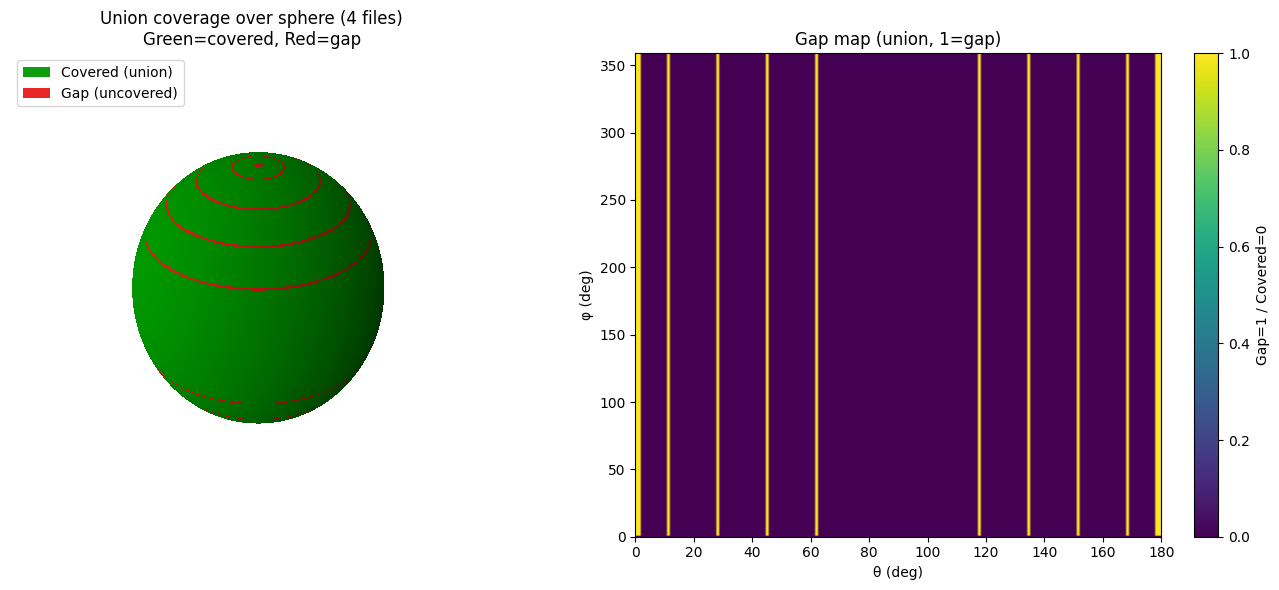

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ----------------------------
# 설정
# ----------------------------
CSV_FILES = [
    r"128/0 RGB coords_with_bounds.csv",
    r"128/64 RGB coords_with_bounds.csv",
    r"128/128 RGB coords_with_bounds.csv",
    r"128/192 RGB coords_with_bounds.csv",
]
PHI_DEG_STEP   = 1.0    # φ 해상도(도)
THETA_DEG_STEP = 1.0    # θ 해상도(도)
TOL_PHI   = 1e-12
TOL_THETA = 1e-6

deg = np.deg2rad
rad = np.rad2deg
PI, TWOPI = np.pi, 2*np.pi

required_cols = ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']

# ----------------------------
# 유틸
# ----------------------------
def ang_norm(x):
    return (x % TWOPI + TWOPI) % TWOPI

def angle_in_interval_vec(angle, left, right, tol=1e-12):
    """
    angle: float (라디안)
    left/right: np.ndarray (라디안)
    래핑 고려한 포함 판정 (벡터화)
    """
    a = ang_norm(angle)
    L = ang_norm(left)
    R = ang_norm(right)
    # 케이스1: L <= R → [L, R]
    case1 = (L <= R) & (a + tol >= L) & (a <= R + tol)
    # 케이스2: L > R → [L, 2π) ∪ [0, R]
    case2 = (L > R) & ((a + tol >= L) | (a <= R + tol))
    return case1 | case2

def merge_intervals(intervals, tol=1e-6):
    """
    θ 구간 유니온 + 갭 계산
    intervals: list[(lo, hi)]
    """
    if not intervals:
        return [], [(0.0, PI)]
    clipped = [(max(0.0, lo), min(PI, hi)) for (lo, hi) in intervals if hi > 0 and lo < PI]
    if not clipped:
        return [], [(0.0, PI)]
    clipped.sort(key=lambda x: x[0])
    merged = []
    cur_lo, cur_hi = clipped[0]
    for lo, hi in clipped[1:]:
        if lo <= cur_hi + tol:
            cur_hi = max(cur_hi, hi)
        else:
            merged.append((cur_lo, cur_hi))
            cur_lo, cur_hi = lo, hi
    merged.append((cur_lo, cur_hi))

    gaps = []
    if merged[0][0] > tol:
        gaps.append((0.0, merged[0][0]))
    for (a_lo, a_hi), (b_lo, b_hi) in zip(merged, merged[1:]):
        if b_lo - a_hi > tol:
            gaps.append((a_hi, b_lo))
    if PI - merged[-1][1] > tol:
        gaps.append((merged[-1][1], PI))
    return merged, gaps

# ----------------------------
# 데이터 로드 (4개 파일)
# ----------------------------
dfs = []
for path in CSV_FILES:
    df = pd.read_csv(path)
    miss = [c for c in required_cols if c not in df.columns]
    if miss:
        raise ValueError(f"{path} 에 필요한 컬럼 누락: {miss}")
    # 벡터화 계산을 위한 numpy 배열 캐시
    df_cache = {
        "path": path,
        "theta_lower": df["theta_lower"].to_numpy(),
        "theta_upper": df["theta_upper"].to_numpy(),
        "phi_left":   df["phi_left"].to_numpy(),
        "phi_right":  df["phi_right"].to_numpy(),
    }
    dfs.append(df_cache)

# ----------------------------
# φ/θ 그리드 생성
# ----------------------------
phi_deg_vals   = np.arange(0, 360, PHI_DEG_STEP)
theta_deg_vals = np.arange(0, 181, THETA_DEG_STEP)
phi_vals   = deg(phi_deg_vals)
theta_vals = deg(theta_deg_vals)

# 파일별 커버 마스크, 합집합 커버 마스크
covered_per_file = [np.zeros((len(phi_vals), len(theta_vals)), dtype=bool) for _ in dfs]
covered_union    = np.zeros((len(phi_vals), len(theta_vals)), dtype=bool)

# ----------------------------
# 스캔 루프
# ----------------------------
for i, phi in enumerate(phi_vals):
    union_intervals = []
    for fidx, d in enumerate(dfs):
        # φ 포함되는 행 인덱스 (벡터화)
        mask = angle_in_interval_vec(phi, d["phi_left"], d["phi_right"], tol=TOL_PHI)
        if not np.any(mask):
            continue
        lo = d["theta_lower"][mask]
        hi = d["theta_upper"][mask]
        intervals = list(zip(lo, hi))

        merged, _ = merge_intervals(intervals, tol=TOL_THETA)  # 파일별 merged
        # 파일별 커버 마스크 갱신
        for (a, b) in merged:
            idx = np.where((theta_vals >= a - TOL_THETA) & (theta_vals <= b + TOL_THETA))[0]
            if idx.size > 0:
                covered_per_file[fidx][i, idx] = True
        # 합집합용 모으기
        union_intervals.extend(merged)

    # 합집합 병합 → 전역 커버 마스크 갱신
    if union_intervals:
        merged_union, _ = merge_intervals(union_intervals, tol=TOL_THETA)
        for (a, b) in merged_union:
            idx = np.where((theta_vals >= a - TOL_THETA) & (theta_vals <= b + TOL_THETA))[0]
            if idx.size > 0:
                covered_union[i, idx] = True

# ----------------------------
# 통계 출력
# ----------------------------
for fidx, d in enumerate(dfs):
    ratio = covered_per_file[fidx].mean() * 100.0
    print(f"[{d['path']}] coverage = {ratio:.4f}%")
print(f"[UNION of 4 files] coverage = {covered_union.mean() * 100.0:.4f}%")

# ----------------------------
# 3D 구 시각화 (합집합 결과)
# ----------------------------
PHI_grid, THETA_grid = np.meshgrid(phi_vals, theta_vals, indexing='ij')
X = np.sin(THETA_grid) * np.cos(PHI_grid)
Y = np.sin(THETA_grid) * np.sin(PHI_grid)
Z = np.cos(THETA_grid)

rgba = np.zeros((covered_union.shape[0], covered_union.shape[1], 4))
rgba[ covered_union] = [0.0, 0.6, 0.0, 0.95]  # covered → green
rgba[~covered_union] = [0.9, 0.1, 0.1, 0.95]  # gaps    → red

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=rgba, rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_box_aspect([1,1,1])
ax.set_title("Union coverage over sphere (4 files)\nGreen=covered, Red=gap")
ax.set_axis_off()
ax.legend(
    handles=[
        Patch(facecolor=(0.0, 0.6, 0.0, 0.95), label="Covered (union)"),
        Patch(facecolor=(0.9, 0.1, 0.1, 0.95), label="Gap (uncovered)")
    ],
    loc='upper left'
)

# ----------------------------
# 2D 히트맵 (합집합)
# ----------------------------
ax2 = fig.add_subplot(122)
heat_union = (~covered_union).astype(float)  # gap=1, covered=0
im = ax2.imshow(
    heat_union,
    origin='lower',
    aspect='auto',
    extent=[theta_deg_vals.min(), theta_deg_vals.max(), phi_deg_vals.min(), phi_deg_vals.max()]
)
ax2.set_xlabel("θ (deg)")
ax2.set_ylabel("φ (deg)")
ax2.set_title("Gap map (union, 1=gap)")
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label("Gap=1 / Covered=0")

plt.tight_layout()
plt.show()


In [12]:
def quantized_images_to_theta_phi_dict(quantized_class_images, rgb_to_theta_phi):
    """
    quantized_class_images: dict {class_id: [이미지, ...]}, 각 이미지 shape (32,32,3)
    rgb_to_theta_phi: (r,g,b) -> (theta, phi) 반환 함수
    """
    theta_phi_dict = {i: [] for i in range(10)}
    for class_id, images in quantized_class_images.items():
        for img in images:
            theta_phi_img = np.zeros((32, 32, 2), dtype=np.float32)
            # 0~63 변환 (이미 4단위 양자화이므로 //4)
            r63 = img[:, :, 0]
            g63 = img[:, :, 1]
            b63 = img[:, :, 2]
            for i in range(32):
                for j in range(32):
                    r, g, b = int(r63[i, j]), int(g63[i, j]), int(b63[i, j])
                    theta, phi = rgb_to_theta_phi(r, g, b)
                    theta_phi_img[i, j, 0] = theta
                    theta_phi_img[i, j, 1] = phi
            theta_phi_dict[class_id].append(theta_phi_img)
    return theta_phi_dict

In [ ]:
# 방법 1: 새 dict 생성
quantized_class_images_div4 = {
    k: [arr / 4 for arr in v]
    for k, v in quantized_class_images.items()
}

In [ ]:
theta_phi_dict = quantized_images_to_theta_phi_dict(quantized_class_images_div4, rgb_to_theta_phi)